In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import json
import matplotlib.pyplot as plt
from init_objects import *
from functions.helpers import organise_data
from qe_model import *
from matplotlib import style
import scipy.stats as stats
import statsmodels.api as sm
import math
#from functions.find_bubbles import *
import matplotlib.transforms as mtransforms

In [2]:
def confidence_interval(data, av):
    sample_stdev = np.std(data)
    sigma = sample_stdev/math.sqrt(len(data))
    return stats.t.interval(alpha = 0.95, df= 24, loc=av, scale=sigma) 

In [3]:
style.use('seaborn-ticks')

# QE - QT experiments

In [4]:
params_nb = {"fundamental_value": 105,
              "trader_sample_size": 15, "n_traders": 500,
              "ticks": 500, "std_fundamental": 0.01,
              "std_noise": 0.159, "w_random": 0.25,
              "strat_share_chartists": 0.40,
              "init_assets": 740, "base_risk_aversion": 4.051,
              'spread_max': 0.004, "horizon": 200,
              "fundamentalist_horizon_multiplier": 2.2,
              "trades_per_tick": 3, "mutation_intensity": 0.0477,
              "average_learning_ability": 0.02, 'money_multiplier': 2.2,
              "bond_mean_reversion": 0.0, 'cb_pf_range': 0.05,
              "qe_perc_size": 0.16, "cb_size": 0.02, "qe_asset_index": 0}

In [5]:
NRUNS = 4
burn_in_period = 0

In [6]:
scenarios = [None, 'BLR', 'BUSTQE', 'BUSTQT', 'BOOMQE', 'BOOMQT']
#scenarios = ['BUSTQE']

In [18]:
steps = 5
qe_size = [x / 100.0 for x in range(0, 100 + steps, steps)]
qe_size = qe_size[0:-12]
qe_size

[0.0, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4]

In [19]:
experiments = len(qe_size)

In [20]:
full_qe_size = []
for exp in range(experiments):
    for seed in range(NRUNS):
        full_qe_size.append(qe_size[exp])

In [21]:
prices = []
fundamentals = []
volumes = []
qe_periods = []
qt_periods = []

for scenario in scenarios:
    for exp in range(experiments):
        params_nb['qe_perc_size'] = qe_size[exp]
        trdrs = []
        orbs = []
        central_banks = []
        
        for seed_nb in range(NRUNS): 
            traders_nb, central_bank_nb, orderbook_nb = init_objects(params_nb, seed_nb)
            traders_nb, central_bank_nb, orderbook_nb = qe_model(traders_nb, central_bank_nb, orderbook_nb, params_nb, scenario=scenario, seed=seed_nb)
            central_banks.append(central_bank_nb)
            trdrs.append(traders_nb)
            orbs.append(orderbook_nb)

        prices.append(pd.DataFrame([orbs[run].tick_close_price for run in range(NRUNS)]).transpose())
        fundamentals.append(pd.DataFrame([orbs[run].fundamental for run in range(NRUNS)]).transpose())
        volumes.append(pd.DataFrame([[sum(v) for v in orbs[run].transaction_volumes_history] for run in range(NRUNS)]).transpose())
        # bug here!!
        qe_periods.append(pd.DataFrame([[orbs[run].qe_period] for run in range(NRUNS)]).transpose())
        qt_periods.append(pd.DataFrame([[orbs[run].qt_period] for run in range(NRUNS)]).transpose())

Start of simulation  0
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277
278
279
280
281
282
283
284
285
286
287
288
289
290
291
292
293
294
295
296
297
298
299
300
301
302
303
304
305
306
307
308
309
310
311
312
313
314
315
316
317
318
319
320
321
322
323
324
325
326
327
328
329
330
331
332
333
334
335
336
337
338
339
340
341
342
343
344
345
346
347
348
349
350
351
352
353
354
355
356
357
358
359
360
361
362
363
364
365
366
367
368
369
370
371
372
373
374
375
376
377
378
379
380
381
382
383
384
385
386
387
388
389
390
391
392
393
394
395
396
397
398
399
400
401
402
403
404
405
406
407
408
409
410
411
412
413
414
415
416
417
418
419
debug
420
421
422
423
424
425
426
427
428
429
430
431
432
433
434
435
436
437
438
439
440
441
442
443

216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277
278
279
280
281
282
283
284
285
286
287
288
289
290
291
292
293
294
295
296
297
298
299
300
301
302
303
304
305
306
307
308
309
310
311
312
313
314
315
316
317
318
319
320
321
322
323
324
325
326
327
328
329
330
331
332
333
334
335
336
337
338
339
340
341
342
343
344
345
346
347
348
349
350
351
352
353
354
355
356
357
358
359
360
361
362
363
364
365
366
367
368
369
370
371
372
373
374
375
376
377
378
379
380
381
382
383
384
385
386
387
388
389
390
391
392
393
394
395
396
397
398
399
400
401
402
403
404
405
406
407
408
409
410
411
412
413
414
415
416
417
418
419
debug
420
421
422
423
424
425
426
427
428
429
430
431
432
433
434
435
436
437
438
439
440
441
442
443
444
445
446
447
448
449
450
451
452
453
454
455
456
457
458
459
460
461
462
463
46

238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277
278
279
280
281
282
283
284
285
286
287
288
289
290
291
292
293
294
295
296
297
298
299
300
301
302
303
304
305
306
307
308
309
310
311
312
313
314
315
316
317
318
319
320
321
322
323
324
325
326
327
328
329
330
331
332
333
334
335
336
337
338
339
340
341
342
343
344
345
346
347
348
349
350
351
352
353
354
355
356
357
358
359
360
361
362
363
364
365
366
367
368
369
370
371
372
373
374
375
376
377
378
379
380
381
382
383
384
385
386
387
388
389
390
391
392
393
394
395
396
397
398
399
400
401
402
403
404
405
406
407
408
409
410
411
412
413
414
415
416
417
418
419
debug
420
421
422
423
424
425
426
427
428
429
430
431
432
433
434
435
436
437
438
439
440
441
442
443
444
445
446
447
448
449
450
451
452
453
454
455
456
457
458
459
460
461
462
463
464
465
466
467
468
469
470
471
472
473
474
475
476
477
478
479
480
481
482
483
484
485
48

259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277
278
279
280
281
282
283
284
285
286
287
288
289
290
291
292
293
294
295
296
297
298
299
300
301
302
303
304
305
306
307
308
309
310
311
312
313
314
315
316
317
318
319
320
321
322
323
324
325
326
327
328
329
330
331
332
333
334
335
336
337
338
339
340
341
342
343
344
345
346
347
348
349
350
351
352
353
354
355
356
357
358
359
360
361
362
363
364
365
366
367
368
369
370
371
372
373
374
375
376
377
378
379
380
381
382
383
384
385
386
387
388
389
390
391
392
393
394
395
396
397
398
399
400
401
402
403
404
405
406
407
408
409
410
411
412
413
414
415
416
417
418
419
debug
420
421
422
423
424
425
426
427
428
429
430
431
432
433
434
435
436
437
438
439
440
441
442
443
444
445
446
447
448
449
450
451
452
453
454
455
456
457
458
459
460
461
462
463
464
465
466
467
468
469
470
471
472
473
474
475
476
477
478
479
480
481
482
483
484
485
486
487
488
489
490
491
492
493
494
495
496
497
498
499
500
501
502
503
504
505
506
50

280
281
282
283
284
285
286
287
288
289
290
291
292
293
294
295
296
297
298
299
300
301
302
303
304
305
306
307
308
309
310
311
312
313
314
315
316
317
318
319
320
321
322
323
324
325
326
327
328
329
330
331
332
333
334
335
336
337
338
339
340
341
342
343
344
345
346
347
348
349
350
351
352
353
354
355
356
357
358
359
360
361
362
363
364
365
366
367
368
369
370
371
372
373
374
375
376
377
378
379
380
381
382
383
384
385
386
387
388
389
390
391
392
393
394
395
396
397
398
399
400
401
402
403
404
405
406
407
408
409
410
411
412
413
414
415
416
417
418
419
debug
420
421
422
423
424
425
426
427
428
429
430
431
432
433
434
435
436
437
438
439
440
441
442
443
444
445
446
447
448
449
450
451
452
453
454
455
456
457
458
459
460
461
462
463
464
465
466
467
468
469
470
471
472
473
474
475
476
477
478
479
480
481
482
483
484
485
486
487
488
489
490
491
492
493
494
495
496
497
498
499
500
501
502
503
504
505
506
507
508
509
510
511
512
513
514
515
516
517
518
519
520
521
522
523
524
525
526
527
52

300
301
302
303
304
305
306
307
308
309
310
311
312
313
314
315
316
317
318
319
320
321
322
323
324
325
326
327
328
329
330
331
332
333
334
335
336
337
338
339
340
341
342
343
344
345
346
347
348
349
350
351
352
353
354
355
356
357
358
359
360
361
362
363
364
365
366
367
368
369
370
371
372
373
374
375
376
377
378
379
380
381
382
383
384
385
386
387
388
389
390
391
392
393
394
395
396
397
398
399
400
401
402
403
404
405
406
407
408
409
410
411
412
413
414
415
416
417
418
419
debug
420
421
422
423
424
425
426
427
428
429
430
431
432
433
434
435
436
437
438
439
440
441
442
443
444
445
446
447
448
449
450
451
452
453
454
455
456
457
458
459
460
461
462
463
464
465
466
467
468
469
470
471
472
473
474
475
476
477
478
479
480
481
482
483
484
485
486
487
488
489
490
491
492
493
494
495
496
497
498
499
500
501
502
503
504
505
506
507
508
509
510
511
512
513
514
515
516
517
518
519
520
521
522
523
524
525
526
527
528
529
530
531
532
533
534
535
536
537
538
539
540
541
542
543
544
545
546
547
54

321
322
323
324
325
326
327
328
329
330
331
332
333
334
335
336
337
338
339
340
341
342
343
344
345
346
347
348
349
350
351
352
353
354
355
356
357
358
359
360
361
362
363
364
365
366
367
368
369
370
371
372
373
374
375
376
377
378
379
380
381
382
383
384
385
386
387
388
389
390
391
392
393
394
395
396
397
398
399
400
401
402
403
404
405
406
407
408
409
410
411
412
413
414
415
416
417
418
419
debug
420
421
422
423
424
425
426
427
428
429
430
431
432
433
434
435
436
437
438
439
440
441
442
443
444
445
446
447
448
449
450
451
452
453
454
455
456
457
458
459
460
461
462
463
464
465
466
467
468
469
470
471
472
473
474
475
476
477
478
479
480
481
482
483
484
485
486
487
488
489
490
491
492
493
494
495
496
497
498
499
500
501
502
503
504
505
506
507
508
509
510
511
512
513
514
515
516
517
518
519
520
521
522
523
524
525
526
527
528
529
530
531
532
533
534
535
536
537
538
539
540
541
542
543
544
545
546
547
548
549
550
551
552
553
554
555
556
557
558
559
560
561
562
563
564
565
566
567
568
56

341
342
343
344
345
346
347
348
349
350
351
352
353
354
355
356
357
358
359
360
361
362
363
364
365
366
367
368
369
370
371
372
373
374
375
376
377
378
379
380
381
382
383
384
385
386
387
388
389
390
391
392
393
394
395
396
397
398
399
400
401
402
403
404
405
406
407
408
409
410
411
412
413
414
415
416
417
418
419
debug
420
421
422
423
424
425
426
427
428
429
430
431
432
433
434
435
436
437
438
439
440
441
442
443
444
445
446
447
448
449
450
451
452
453
454
455
456
457
458
459
460
461
462
463
464
465
466
467
468
469
470
471
472
473
474
475
476
477
478
479
480
481
482
483
484
485
486
487
488
489
490
491
492
493
494
495
496
497
498
499
500
501
502
503
504
505
506
507
508
509
510
511
512
513
514
515
516
517
518
519
520
521
522
523
524
525
526
527
528
529
530
531
532
533
534
535
536
537
538
539
540
541
542
543
544
545
546
547
548
549
550
551
552
553
554
555
556
557
558
559
560
561
562
563
564
565
566
567
568
569
570
571
572
573
574
575
576
577
578
579
580
581
582
583
584
585
586
587
588
58

363
364
365
366
367
368
369
370
371
372
373
374
375
376
377
378
379
380
381
382
383
384
385
386
387
388
389
390
391
392
393
394
395
396
397
398
399
400
401
402
403
404
405
406
407
408
409
410
411
412
413
414
415
416
417
418
419
debug
420
421
422
423
424
425
426
427
428
429
430
431
432
433
434
435
436
437
438
439
440
441
442
443
444
445
446
447
448
449
450
451
452
453
454
455
456
457
458
459
460
461
462
463
464
465
466
467
468
469
470
471
472
473
474
475
476
477
478
479
480
481
482
483
484
485
486
487
488
489
490
491
492
493
494
495
496
497
498
499
500
501
502
503
504
505
506
507
508
509
510
511
512
513
514
515
516
517
518
519
520
521
522
523
524
525
526
527
528
529
530
531
532
533
534
535
536
537
538
539
540
541
542
543
544
545
546
547
548
549
550
551
552
553
554
555
556
557
558
559
560
561
562
563
564
565
566
567
568
569
570
571
572
573
574
575
576
577
578
579
580
581
582
583
584
585
586
587
588
589
590
591
592
593
594
595
596
597
598
599
600
601
602
603
604
605
606
607
608
609
610
61

385
386
387
388
389
390
391
392
393
394
395
396
397
398
399
400
401
402
403
404
405
406
407
408
409
410
411
412
413
414
415
416
417
418
419
debug
420
421
422
423
424
425
426
427
428
429
430
431
432
433
434
435
436
437
438
439
440
441
442
443
444
445
446
447
448
449
450
451
452
453
454
455
456
457
458
459
460
461
462
463
464
465
466
467
468
469
470
471
472
473
474
475
476
477
478
479
480
481
482
483
484
485
486
487
488
489
490
491
492
493
494
495
496
497
498
499
500
501
502
503
504
505
506
507
508
509
510
511
512
513
514
515
516
517
518
519
520
521
522
523
524
525
526
527
528
529
530
531
532
533
534
535
536
537
538
539
540
541
542
543
544
545
546
547
548
549
550
551
552
553
554
555
556
557
558
559
560
561
562
563
564
565
566
567
568
569
570
571
572
573
574
575
576
577
578
579
580
581
582
583
584
585
586
587
588
589
590
591
592
593
594
595
596
597
598
599
600
601
602
603
604
605
606
607
608
609
610
611
612
613
614
615
616
617
618
619
620
621
622
623
624
625
626
627
628
629
630
631
632
63

cb QE
263
cb QE
cb QE
cb QE
264
cb QE
cb QE
cb QE
265
cb QE
cb QE
cb QE
266
cb QE
cb QE
cb QE
267
cb QT
cb QT
268
cb QT
cb QT
cb QT
269
cb QT
270
271
cb QE
cb QE
272
273
274
275
cb QE
cb QE
276
cb QE
cb QE
cb QE
277
cb QE
cb QE
cb QE
278
cb QE
cb QE
cb QE
279
cb QE
cb QE
cb QE
280
cb QE
cb QE
cb QE
281
cb QE
cb QE
cb QE
282
283
cb QT
cb QT
cb QT
284
cb QT
cb QT
cb QT
285
cb QT
cb QT
cb QT
286
287
cb QE
cb QE
cb QE
288
289
cb QE
290
cb QE
cb QE
cb QE
291
cb QE
cb QE
cb QE
292
cb QE
cb QE
cb QE
293
cb QE
cb QE
cb QE
294
cb QE
cb QE
cb QE
295
cb QE
cb QE
cb QE
296
cb QE
cb QE
cb QE
297
cb QE
298
cb QT
cb QT
299
cb QT
cb QT
cb QT
300
cb QT
cb QT
cb QT
301
cb QT
cb QT
cb QT
302
cb QT
cb QT
cb QT
303
cb QT
cb QT
cb QT
304
cb QT
cb QT
305
306
cb QT
307
cb QT
cb QT
cb QT
308
cb QT
cb QT
cb QT
309
cb QT
cb QT
cb QT
310
cb QT
cb QT
cb QT
311
cb QT
cb QT
312
313
314
cb QE
315
cb QE
cb QE
cb QE
316
cb QE
cb QE
cb QE
317
318
319
cb QE
cb QE
320
cb QE
cb QE
321
cb QE
cb QE
cb QE
322
cb QE
cb QE
323


282
cb QE
cb QE
cb QE
283
cb QE
cb QE
cb QE
284
cb QE
285
286
287
288
289
cb QE
290
cb QE
cb QE
291
cb QE
cb QE
cb QE
292
cb QE
cb QE
cb QE
293
cb QE
cb QE
cb QE
294
cb QE
cb QE
cb QE
295
cb QE
cb QE
cb QE
296
cb QE
297
298
299
300
301
302
303
304
cb QE
cb QE
305
cb QE
cb QE
306
307
cb QE
cb QE
308
cb QE
cb QE
309
310
cb QE
311
cb QE
cb QE
312
313
314
315
316
317
318
319
320
321
322
323
cb QT
cb QT
324
cb QT
cb QT
cb QT
325
cb QT
cb QT
cb QT
326
cb QT
cb QT
cb QT
327
328
329
330
cb QT
331
cb QT
cb QT
cb QT
332
cb QT
cb QT
cb QT
333
cb QT
cb QT
cb QT
334
cb QT
cb QT
cb QT
335
cb QT
cb QT
cb QT
336
cb QT
cb QT
cb QT
337
cb QT
cb QT
cb QT
338
cb QT
cb QT
339
340
341
342
cb QT
343
cb QT
344
cb QT
cb QT
cb QT
345
cb QT
cb QT
cb QT
346
cb QT
cb QT
cb QT
347
cb QT
cb QT
348
cb QT
cb QT
cb QT
349
cb QT
cb QT
cb QT
350
cb QT
cb QT
cb QT
351
cb QT
cb QT
cb QT
352
cb QT
cb QT
cb QT
353
cb QT
cb QT
cb QT
354
cb QT
cb QT
cb QT
355
cb QT
cb QT
cb QT
356
cb QT
cb QT
cb QT
357
cb QT
cb QT
cb QT
358
cb

cb QE
cb QE
332
cb QE
cb QE
cb QE
333
cb QE
cb QE
cb QE
334
cb QE
cb QE
335
336
337
338
339
cb QE
cb QE
cb QE
340
cb QE
cb QE
cb QE
341
cb QE
cb QE
cb QE
342
cb QE
cb QE
cb QE
343
cb QE
cb QE
cb QE
344
cb QE
cb QE
cb QE
345
cb QE
cb QE
cb QE
346
cb QE
cb QE
cb QE
347
cb QE
cb QE
cb QE
348
cb QE
cb QE
cb QE
349
cb QE
cb QE
cb QE
350
cb QE
cb QE
cb QE
351
cb QE
cb QE
cb QE
352
cb QE
cb QE
cb QE
353
cb QE
cb QE
cb QE
354
cb QE
cb QE
cb QE
355
356
cb QE
357
cb QE
cb QE
cb QE
358
359
360
361
cb QE
362
cb QE
cb QE
cb QE
363
cb QE
cb QE
cb QE
364
cb QE
cb QE
cb QE
365
cb QE
cb QE
cb QE
366
cb QE
cb QE
cb QE
367
cb QE
cb QE
cb QE
368
cb QE
cb QE
cb QE
369
cb QE
cb QE
cb QE
370
cb QE
cb QE
cb QT
371
cb QT
cb QT
372
cb QT
cb QT
cb QT
373
cb QT
cb QT
cb QT
374
cb QT
cb QT
cb QT
375
cb QT
cb QT
376
cb QT
cb QT
cb QT
377
cb QT
cb QT
cb QT
378
cb QT
cb QT
cb QT
379
cb QT
cb QT
cb QT
380
cb QT
cb QT
cb QT
381
cb QT
cb QT
cb QT
382
cb QT
cb QT
cb QT
383
cb QT
cb QT
384
cb QE
cb QE
385
cb QE
cb QE
cb Q

cb QE
335
cb QE
cb QE
cb QE
336
cb QE
cb QE
cb QE
337
cb QE
cb QE
cb QE
338
cb QE
cb QE
cb QE
339
cb QT
cb QT
cb QT
340
cb QT
cb QT
cb QT
341
cb QT
cb QT
cb QT
342
cb QT
cb QT
cb QT
343
cb QT
cb QT
cb QT
344
cb QT
345
cb QE
346
cb QE
cb QE
cb QE
347
cb QE
cb QE
cb QE
348
cb QE
cb QE
cb QE
349
cb QE
cb QE
350
351
352
353
354
355
356
cb QT
cb QT
cb QT
357
cb QT
358
359
cb QT
360
cb QT
cb QT
361
362
363
cb QT
cb QT
364
cb QT
cb QT
cb QT
365
cb QT
cb QT
366
cb QT
cb QT
367
cb QT
cb QT
cb QT
368
cb QT
cb QT
369
cb QT
cb QT
370
cb QT
cb QT
cb QT
371
cb QT
cb QT
372
cb QE
373
cb QE
cb QE
cb QE
374
cb QE
cb QE
cb QE
375
cb QE
cb QE
cb QE
376
cb QE
cb QE
cb QE
377
378
379
cb QT
cb QT
380
cb QT
381
cb QT
cb QT
382
cb QT
cb QT
cb QT
383
cb QT
cb QT
cb QT
384
cb QT
cb QT
385
386
cb QT
cb QT
cb QT
387
388
cb QT
389
cb QT
cb QT
cb QT
390
cb QT
cb QT
cb QT
391
cb QT
cb QT
cb QT
392
cb QT
cb QT
cb QT
393
cb QT
cb QT
cb QT
394
cb QT
cb QT
cb QT
395
cb QT
cb QT
cb QT
396
cb QT
cb QT
cb QT
397
cb QT
cb Q

cb QE
388
cb QE
cb QE
cb QE
389
cb QE
390
cb QE
cb QE
cb QE
391
cb QE
cb QE
cb QE
392
393
394
cb QT
395
cb QT
cb QT
396
cb QT
cb QT
cb QT
397
cb QT
cb QT
398
cb QT
cb QT
cb QT
399
cb QT
cb QT
400
cb QE
401
cb QE
cb QE
402
cb QE
403
cb QE
cb QE
cb QE
404
cb QE
405
406
407
408
409
cb QT
cb QT
410
cb QT
cb QT
cb QT
411
cb QT
cb QT
cb QT
412
cb QT
cb QT
cb QT
413
cb QT
cb QT
cb QT
414
cb QT
cb QT
cb QT
415
cb QT
cb QT
416
417
418
419
debug
cb QE
420
cb QE
cb QE
421
cb QE
422
cb QE
cb QE
cb QE
423
cb QE
424
cb QE
cb QE
425
426
cb QT
cb QT
cb QT
427
cb QT
cb QT
cb QT
428
cb QT
cb QT
cb QT
429
430
431
432
433
434
cb QT
cb QT
435
cb QT
cb QT
436
437
438
439
440
cb QT
cb QT
441
cb QT
cb QT
cb QT
442
cb QT
cb QT
cb QT
443
444
445
cb QE
cb QE
446
cb QE
cb QE
cb QE
447
cb QE
cb QE
cb QE
448
cb QE
cb QE
449
cb QE
cb QE
cb QE
450
cb QE
451
452
cb QT
cb QT
453
cb QT
cb QT
cb QT
454
cb QT
cb QT
cb QT
455
456
cb QE
cb QE
457
cb QE
cb QE
cb QE
458
cb QE
cb QE
459
460
461
cb QE
cb QE
cb QE
462
463
464
46

473
cb QE
474
cb QE
cb QE
cb QE
475
cb QE
cb QE
476
cb QE
cb QE
cb QE
477
cb QE
cb QE
cb QE
478
cb QE
cb QE
cb QE
479
cb QE
cb QE
cb QE
480
cb QE
481
cb QT
482
cb QT
cb QT
cb QT
483
cb QT
cb QT
cb QT
484
cb QT
cb QT
cb QT
485
cb QT
cb QT
cb QT
486
cb QT
cb QT
cb QT
487
cb QT
cb QT
cb QT
488
cb QT
cb QT
cb QT
489
cb QT
cb QT
cb QT
490
cb QT
491
492
493
494
cb QE
cb QE
495
cb QE
cb QE
cb QE
496
497
498
499
cb QT
cb QT
500
cb QT
cb QT
cb QT
501
502
503
504
505
506
507
508
509
510
cb QE
cb QE
511
cb QE
cb QE
cb QE
512
cb QE
cb QE
cb QE
513
cb QE
cb QE
cb QE
514
cb QE
515
516
cb QE
517
cb QE
cb QE
cb QE
518
cb QE
cb QE
cb QE
519
cb QE
cb QE
cb QE
520
cb QE
cb QE
cb QE
521
cb QE
cb QE
cb QE
522
cb QE
cb QE
cb QE
523
cb QE
cb QE
cb QE
524
525
526
527
cb QE
cb QE
528
cb QE
cb QE
529
530
cb QE
cb QE
cb QE
531
cb QE
cb QE
cb QE
532
cb QE
cb QE
cb QE
533
cb QE
cb QE
cb QE
534
cb QE
535
536
537
cb QE
cb QE
cb QE
538
539
540
541
542
543
544
545
546
cb QT
cb QT
cb QT
547
cb QT
cb QT
cb QT
548
cb QT


cb QE
545
cb QE
546
547
548
cb QE
cb QE
549
cb QE
cb QE
550
cb QE
cb QE
cb QE
551
cb QE
cb QE
cb QE
552
cb QE
cb QE
cb QE
553
cb QE
cb QE
cb QE
554
cb QE
cb QE
555
556
557
cb QT
cb QT
558
559
560
561
cb QT
cb QT
cb QT
562
cb QT
cb QE
563
564
cb QE
cb QE
565
cb QE
cb QE
566
cb QE
567
568
cb QE
cb QE
cb QE
569
570
571
572
573
cb QT
cb QT
574
cb QT
cb QT
cb QT
575
cb QT
cb QT
cb QT
576
cb QT
cb QT
cb QT
577
cb QT
cb QT
cb QT
578
cb QT
cb QT
cb QT
579
cb QT
cb QT
cb QT
580
cb QT
581
582
cb QE
cb QE
cb QE
583
cb QE
cb QE
cb QE
584
cb QE
cb QE
cb QE
585
cb QE
cb QE
cb QE
586
cb QE
cb QE
cb QE
587
588
589
590
cb QE
591
cb QE
cb QE
cb QE
592
cb QE
cb QE
cb QE
593
cb QE
cb QE
cb QE
594
cb QE
cb QE
cb QE
595
cb QE
cb QE
cb QE
596
cb QE
cb QE
cb QE
597
cb QE
cb QE
cb QT
598
cb QT
cb QT
cb QT
599
cb QT
600
601
cb QE
cb QE
cb QE
602
cb QE
cb QE
cb QE
603
604
605
cb QE
cb QE
cb QE
606
607
cb QT
cb QT
608
609
610
611
612
613
614
615
616
617
618
cb QT
cb QT
619
cb QT
cb QT
620
621
cb QT
cb QT
622
cb Q

582
cb QE
cb QE
cb QE
583
cb QE
cb QE
cb QT
584
cb QT
cb QT
cb QT
585
cb QT
cb QT
cb QT
586
cb QT
587
cb QT
cb QT
588
cb QT
cb QT
589
590
cb QE
cb QE
591
cb QE
cb QE
cb QE
592
cb QE
cb QE
593
594
595
cb QT
cb QT
cb QT
596
cb QT
cb QT
cb QT
597
cb QT
cb QT
cb QT
598
cb QT
cb QT
cb QT
599
cb QT
cb QT
cb QT
600
cb QT
cb QT
601
cb QT
cb QT
cb QT
602
cb QT
603
cb QT
cb QT
cb QT
604
cb QT
cb QT
cb QT
605
cb QT
cb QE
606
cb QE
cb QE
cb QE
607
cb QE
cb QE
cb QE
608
cb QE
cb QE
cb QE
609
cb QE
cb QE
cb QE
610
cb QE
cb QE
cb QE
611
cb QE
cb QE
cb QE
612
cb QE
cb QE
cb QE
613
614
615
cb QT
616
cb QT
cb QT
cb QT
617
cb QT
cb QT
cb QT
618
cb QT
cb QT
cb QT
619
cb QT
cb QT
620
621
622
cb QT
cb QT
623
cb QT
cb QT
cb QT
624
cb QT
cb QT
625
626
cb QT
627
cb QT
628
629
630
cb QT
631
cb QT
cb QT
cb QT
632
cb QT
cb QT
cb QT
633
cb QT
634
635
636
cb QT
cb QT
637
cb QT
cb QT
cb QT
638
cb QT
cb QT
cb QT
639
cb QT
640
cb QT
641
642
643
644
cb QE
cb QE
645
cb QE
cb QE
646
647
cb QT
648
cb QT
cb QT
cb QT
649
cb

663
cb QE
cb QE
cb QE
664
cb QE
cb QE
665
666
667
668
669
670
671
672
673
674
675
676
cb QT
cb QT
677
cb QT
cb QT
cb QT
678
cb QT
cb QT
cb QT
679
cb QT
cb QT
cb QT
680
cb QT
cb QT
cb QE
681
cb QE
cb QE
cb QE
682
cb QE
683
684
685
686
cb QE
cb QE
cb QE
687
cb QE
cb QE
cb QE
688
cb QE
cb QE
689
690
691
cb QE
cb QE
692
cb QE
cb QE
cb QE
693
694
695
cb QT
696
cb QT
cb QT
cb QT
697
698
699
cb QE
cb QE
700
Start of simulation  1
201
202
203
cb QT
cb QT
cb QT
204
cb QT
cb QT
cb QT
205
cb QT
cb QT
cb QT
206
207
cb QT
208
cb QT
cb QT
cb QT
209
cb QT
cb QT
cb QT
210
cb QT
cb QT
211
212
cb QT
cb QT
cb QT
213
cb QT
cb QT
cb QT
214
cb QT
cb QT
cb QT
215
cb QT
cb QT
cb QT
216
cb QT
cb QT
217
218
219
220
221
222
cb QE
223
cb QE
cb QE
cb QE
224
cb QE
cb QE
cb QE
225
cb QE
cb QE
cb QE
226
cb QE
cb QE
227
cb QE
228
cb QE
cb QE
cb QE
229
cb QE
cb QE
cb QE
230
cb QE
cb QE
cb QE
231
cb QE
cb QE
cb QE
232
cb QE
cb QE
cb QE
233
cb QE
cb QE
cb QE
234
cb QE
cb QE
cb QE
235
cb QE
cb QE
cb QE
236
cb QE
cb QE
cb 

cb QT
266
cb QT
cb QT
cb QT
267
cb QT
cb QT
cb QT
268
cb QT
cb QT
cb QT
269
cb QT
270
271
272
cb QE
cb QE
273
cb QE
cb QE
cb QE
274
cb QE
cb QE
cb QE
275
cb QE
cb QE
cb QE
276
cb QE
cb QE
cb QE
277
cb QE
cb QE
cb QE
278
cb QE
cb QE
cb QE
279
280
cb QT
281
cb QT
cb QT
cb QT
282
cb QT
cb QT
cb QT
283
cb QT
cb QT
cb QT
284
cb QT
cb QT
cb QT
285
cb QT
cb QT
cb QT
286
287
cb QT
cb QT
cb QT
288
289
cb QE
290
cb QE
cb QE
291
cb QE
cb QE
cb QE
292
cb QE
cb QE
cb QE
293
cb QE
cb QE
cb QE
294
cb QE
cb QE
cb QE
295
cb QE
cb QE
296
cb QE
cb QE
cb QE
297
cb QE
cb QE
cb QE
298
cb QE
cb QE
299
cb QE
cb QE
cb QE
300
cb QE
301
302
cb QT
303
cb QT
cb QT
cb QT
304
cb QT
cb QT
cb QT
305
cb QT
cb QT
cb QT
306
cb QT
cb QT
cb QT
307
cb QT
cb QT
cb QT
308
cb QT
cb QT
cb QT
309
cb QT
cb QT
cb QT
310
311
cb QE
cb QE
312
313
cb QE
cb QE
cb QE
314
cb QE
cb QE
cb QE
315
cb QE
cb QE
cb QE
316
cb QE
cb QE
cb QE
317
cb QE
cb QE
cb QE
318
cb QE
319
cb QE
320
321
cb QE
cb QE
322
cb QE
cb QE
cb QE
323
cb QE
cb QE
324
cb

cb QE
319
cb QE
cb QE
cb QE
320
cb QE
321
322
323
324
cb QE
325
cb QE
cb QE
cb QE
326
cb QE
cb QE
327
cb QE
cb QE
cb QE
328
cb QE
cb QE
329
cb QE
cb QE
cb QE
330
cb QE
cb QE
cb QE
331
cb QE
cb QE
cb QE
332
cb QE
cb QE
cb QE
333
cb QE
334
335
cb QE
cb QE
cb QE
336
cb QE
cb QE
cb QE
337
cb QE
cb QE
cb QE
338
cb QE
cb QE
cb QE
339
cb QE
cb QT
cb QT
340
cb QT
cb QT
cb QT
341
cb QT
cb QT
cb QT
342
cb QT
cb QT
cb QT
343
cb QT
cb QT
cb QT
344
cb QT
cb QT
cb QT
345
cb QT
346
347
348
349
350
351
cb QT
cb QT
cb QT
352
cb QT
cb QT
cb QT
353
cb QT
cb QT
cb QT
354
355
356
cb QT
cb QT
cb QT
357
cb QT
358
359
cb QT
360
cb QT
cb QT
361
362
cb QT
363
cb QT
cb QT
cb QT
364
cb QT
cb QT
cb QT
365
cb QT
366
367
368
369
370
371
372
cb QE
373
cb QE
cb QE
cb QE
374
cb QE
cb QE
cb QE
375
cb QE
cb QE
cb QE
376
cb QE
cb QE
cb QT
377
cb QT
378
379
cb QT
cb QT
380
cb QT
cb QT
381
cb QT
cb QT
cb QT
382
cb QT
cb QT
cb QT
383
cb QT
384
385
386
cb QT
cb QT
cb QT
387
388
cb QT
389
cb QT
cb QT
cb QT
390
cb QT
cb QT
cb Q

381
cb QE
cb QE
cb QE
382
cb QE
cb QE
cb QE
383
cb QE
cb QE
cb QE
384
cb QE
cb QE
cb QE
385
cb QE
cb QE
cb QE
386
cb QE
cb QE
cb QE
387
cb QE
cb QE
cb QE
388
cb QE
389
cb QT
cb QT
390
cb QT
391
392
393
394
cb QT
cb QT
cb QT
395
cb QT
cb QT
cb QT
396
cb QT
cb QT
cb QT
397
cb QT
cb QT
398
cb QT
cb QT
cb QT
399
cb QT
cb QE
400
cb QE
cb QE
cb QE
401
cb QE
cb QE
cb QE
402
cb QE
cb QE
cb QE
403
cb QE
cb QE
cb QE
404
cb QE
405
406
407
408
cb QT
cb QT
cb QT
409
cb QT
cb QT
cb QT
410
cb QT
cb QT
cb QT
411
cb QT
cb QT
cb QT
412
cb QT
cb QT
cb QT
413
cb QT
cb QT
cb QT
414
cb QT
cb QT
cb QT
415
cb QT
cb QT
cb QT
416
cb QT
cb QT
cb QT
417
cb QT
cb QE
cb QE
418
cb QE
cb QE
cb QE
419
debug
cb QE
cb QE
cb QE
420
cb QE
cb QE
cb QE
421
cb QE
cb QE
422
cb QE
cb QE
cb QE
423
424
425
cb QT
426
cb QT
cb QT
cb QT
427
cb QT
cb QT
cb QT
428
cb QT
cb QT
cb QT
429
cb QT
430
431
432
cb QT
cb QT
433
cb QT
434
cb QT
cb QT
435
cb QT
cb QT
cb QT
436
cb QT
cb QT
cb QT
437
cb QT
cb QT
cb QT
438
439
440
cb QT
cb QT
441


480
cb QT
cb QT
481
cb QT
cb QT
cb QT
482
cb QT
cb QT
cb QT
483
cb QT
cb QT
cb QT
484
cb QT
cb QT
cb QT
485
cb QT
cb QT
cb QT
486
cb QT
cb QT
cb QT
487
cb QT
488
489
490
491
492
493
cb QE
494
cb QE
cb QE
495
cb QE
cb QE
cb QE
496
cb QT
497
cb QT
cb QT
498
cb QT
cb QT
cb QT
499
cb QT
cb QT
cb QT
500
cb QT
cb QT
cb QT
501
cb QT
cb QT
502
503
504
505
cb QE
cb QE
cb QE
506
507
508
cb QE
cb QE
cb QE
509
cb QE
cb QE
cb QE
510
cb QE
cb QE
cb QE
511
cb QE
cb QE
cb QE
512
cb QE
cb QE
cb QE
513
cb QE
cb QE
cb QE
514
cb QE
515
cb QE
516
cb QE
cb QE
517
cb QE
cb QE
cb QE
518
cb QE
cb QE
cb QE
519
cb QE
cb QE
cb QE
520
cb QE
cb QE
521
522
523
524
525
526
527
cb QE
cb QE
528
cb QE
cb QE
529
cb QE
cb QE
cb QE
530
531
532
533
cb QT
cb QT
534
535
cb QT
cb QT
cb QT
536
cb QT
537
cb QE
cb QE
cb QE
538
cb QE
cb QE
cb QE
539
cb QE
540
541
542
543
544
545
546
cb QT
cb QT
cb QT
547
cb QT
cb QT
cb QT
548
cb QT
cb QT
cb QT
549
cb QT
cb QT
cb QT
550
cb QT
cb QT
551
552
553
554
cb QT
cb QT
cb QT
555
556
557
558


cb QE
cb QE
552
cb QE
cb QE
cb QE
553
cb QE
cb QE
554
555
556
557
558
559
560
cb QT
cb QT
cb QT
561
cb QT
cb QT
cb QT
562
cb QT
cb QT
cb QT
563
cb QE
564
cb QE
cb QE
565
cb QE
cb QE
566
567
568
569
570
571
572
573
cb QT
574
cb QT
cb QT
cb QT
575
cb QT
576
cb QT
cb QT
cb QT
577
cb QT
cb QT
cb QT
578
cb QT
cb QT
cb QT
579
cb QT
cb QT
cb QT
580
cb QT
cb QE
cb QE
581
cb QE
cb QE
cb QE
582
cb QE
cb QE
cb QE
583
cb QE
cb QE
cb QE
584
cb QE
cb QE
cb QE
585
cb QE
cb QE
cb QE
586
cb QT
cb QT
cb QT
587
588
589
590
591
cb QE
cb QE
cb QE
592
cb QE
593
594
595
cb QE
cb QE
596
cb QE
cb QE
cb QE
597
cb QE
cb QE
cb QE
598
599
600
601
602
603
604
605
cb QT
606
cb QT
cb QT
cb QT
607
cb QT
cb QT
cb QT
608
cb QT
cb QT
cb QT
609
610
611
612
cb QE
cb QE
cb QE
613
cb QE
cb QE
614
615
616
617
618
619
620
621
622
cb QT
cb QT
623
cb QT
cb QT
cb QT
624
cb QT
cb QT
cb QT
625
cb QT
cb QT
cb QT
626
cb QT
627
628
cb QT
629
cb QT
cb QT
cb QT
630
cb QT
631
cb QT
cb QT
cb QT
632
cb QT
cb QT
cb QT
633
634
cb QT
cb QT
cb

cb QE
655
cb QE
cb QE
cb QE
656
cb QE
cb QE
cb QE
657
cb QE
cb QE
cb QE
658
cb QE
cb QE
659
660
661
662
663
664
665
666
cb QE
cb QE
667
cb QE
cb QE
cb QE
668
cb QE
cb QE
cb QE
669
cb QE
cb QE
cb QE
670
cb QE
cb QE
cb QE
671
cb QE
cb QE
cb QE
672
cb QE
cb QE
cb QE
673
cb QT
674
cb QT
cb QT
675
cb QT
cb QT
cb QT
676
cb QT
cb QT
cb QT
677
cb QT
cb QT
cb QT
678
cb QT
cb QT
cb QT
679
cb QE
cb QE
680
681
682
cb QE
cb QE
683
cb QE
cb QE
cb QE
684
cb QE
cb QE
cb QE
685
cb QE
cb QE
cb QE
686
cb QE
cb QE
cb QE
687
cb QE
688
cb QT
cb QT
689
cb QT
cb QT
cb QT
690
cb QT
cb QT
cb QT
691
cb QT
cb QT
cb QT
692
cb QT
cb QT
cb QT
693
cb QT
694
cb QE
cb QE
695
cb QE
cb QE
696
cb QE
cb QE
cb QE
697
cb QE
698
cb QE
cb QE
699
cb QE
cb QE
cb QE
700
cb QE
cb QE
cb QE
Start of simulation  0
201
202
203
204
205
206
207
208
209
210
211
cb QT
cb QT
212
cb QT
cb QT
cb QT
213
cb QT
cb QT
214
215
216
217
218
cb QE
cb QE
219
cb QE
220
221
222
cb QE
cb QE
cb QE
223
cb QE
cb QE
224
cb QE
cb QE
cb QE
225
cb QE
cb QE
cb 

258
cb QE
cb QE
cb QE
259
cb QE
cb QE
cb QE
260
cb QE
cb QE
cb QT
261
cb QT
cb QT
cb QT
262
cb QT
cb QT
cb QT
263
cb QT
cb QT
cb QT
264
cb QT
cb QT
cb QT
265
266
cb QT
cb QT
cb QT
267
cb QT
cb QT
cb QT
268
cb QT
cb QT
cb QE
269
cb QE
cb QE
270
271
272
273
cb QE
cb QE
cb QE
274
cb QE
cb QE
275
cb QE
cb QE
276
cb QE
cb QE
cb QE
277
cb QE
278
cb QE
cb QE
279
cb QE
cb QE
cb QE
280
cb QE
cb QE
cb QE
281
cb QE
cb QE
cb QE
282
cb QE
cb QE
cb QE
283
cb QE
284
285
cb QT
cb QT
286
cb QT
cb QT
cb QT
287
288
289
290
291
292
cb QE
293
cb QE
cb QE
cb QE
294
cb QE
cb QE
cb QE
295
cb QE
cb QE
cb QE
296
cb QE
cb QE
cb QE
297
298
cb QT
299
cb QT
cb QT
cb QT
300
301
302
303
304
305
306
307
cb QE
cb QE
308
cb QE
cb QE
cb QE
309
cb QE
310
311
312
313
314
cb QT
315
cb QT
cb QT
cb QT
316
cb QT
cb QT
cb QT
317
cb QT
cb QT
cb QT
318
cb QT
319
320
321
322
323
324
cb QT
325
cb QT
326
327
328
329
330
331
cb QT
332
cb QT
cb QT
cb QT
333
cb QT
cb QT
cb QT
334
cb QT
cb QT
cb QT
335
cb QT
cb QT
cb QT
336
cb QT
cb QT


364
cb QT
cb QT
cb QT
365
cb QT
cb QT
cb QT
366
cb QT
cb QT
cb QT
367
cb QT
cb QT
cb QE
368
cb QE
cb QE
cb QE
369
cb QE
cb QE
cb QE
370
cb QE
cb QE
cb QE
371
cb QE
cb QE
cb QE
372
cb QE
373
374
cb QE
375
cb QE
cb QE
376
377
cb QT
cb QT
378
379
cb QT
cb QT
380
cb QT
cb QT
cb QT
381
cb QT
382
383
cb QE
cb QE
cb QE
384
cb QE
cb QE
cb QE
385
cb QE
cb QE
cb QE
386
cb QE
cb QE
cb QE
387
cb QE
cb QE
cb QE
388
389
390
cb QT
cb QT
391
cb QT
cb QT
cb QT
392
cb QT
cb QT
cb QT
393
cb QT
cb QT
cb QT
394
cb QT
cb QT
cb QE
395
cb QE
cb QE
cb QE
396
cb QE
cb QE
cb QE
397
cb QE
cb QE
cb QE
398
cb QE
cb QE
cb QE
399
cb QE
cb QE
cb QE
400
cb QE
cb QT
cb QT
401
cb QT
cb QT
cb QT
402
cb QT
403
cb QT
cb QT
cb QT
404
cb QT
cb QT
405
406
407
408
409
410
411
412
413
414
415
416
417
418
419
debug
cb QT
cb QT
cb QT
420
cb QT
cb QT
cb QT
421
422
cb QE
cb QE
423
cb QE
cb QE
cb QE
424
cb QE
cb QE
cb QE
425
cb QE
cb QE
cb QE
426
cb QE
cb QE
cb QE
427
428
429
cb QE
430
cb QE
cb QE
cb QE
431
cb QE
cb QE
cb QE
432
cb Q

cb QT
cb QT
484
cb QT
cb QT
485
cb QT
cb QT
486
cb QT
cb QT
cb QT
487
cb QT
cb QT
cb QE
488
cb QE
cb QE
cb QE
489
cb QE
cb QE
cb QE
490
cb QE
491
492
493
494
495
cb QE
cb QE
cb QE
496
cb QE
cb QE
cb QE
497
cb QE
498
499
500
501
502
cb QT
cb QT
cb QT
503
cb QT
cb QT
cb QT
504
cb QT
505
cb QE
cb QE
cb QE
506
cb QE
cb QE
cb QE
507
cb QE
cb QE
cb QE
508
cb QE
cb QE
cb QE
509
cb QE
cb QE
cb QE
510
cb QE
cb QE
cb QT
511
cb QT
cb QT
512
513
cb QT
cb QT
514
cb QT
515
cb QT
cb QT
cb QT
516
cb QT
cb QT
517
cb QT
cb QT
cb QT
518
cb QE
cb QE
cb QE
519
cb QE
cb QE
cb QE
520
cb QE
cb QE
cb QE
521
cb QE
cb QE
cb QE
522
cb QE
cb QE
cb QE
523
cb QE
cb QE
cb QE
524
cb QE
cb QT
cb QT
525
cb QT
cb QT
cb QT
526
cb QT
cb QT
cb QT
527
cb QT
cb QT
cb QT
528
cb QT
cb QT
cb QT
529
cb QT
cb QT
cb QT
530
cb QT
cb QT
cb QT
531
cb QT
cb QE
cb QE
532
cb QE
cb QE
cb QE
533
cb QE
cb QE
cb QE
534
cb QE
cb QE
cb QE
535
cb QE
cb QE
536
537
538
539
540
541
542
cb QT
cb QT
543
cb QT
cb QT
cb QT
544
545
546
547
cb QT
cb QT


556
557
558
cb QE
559
cb QE
cb QE
cb QE
560
cb QE
cb QE
cb QE
561
cb QE
cb QE
cb QE
562
cb QE
cb QE
cb QE
563
cb QE
564
565
566
cb QE
cb QE
cb QE
567
cb QE
cb QE
cb QE
568
cb QE
cb QE
cb QE
569
cb QE
570
571
572
573
574
cb QT
575
cb QT
cb QT
cb QT
576
577
cb QT
cb QT
578
cb QT
cb QT
cb QT
579
cb QT
cb QT
cb QT
580
cb QT
cb QT
cb QT
581
cb QT
cb QT
cb QT
582
cb QT
cb QT
cb QT
583
cb QT
cb QT
cb QT
584
cb QT
585
cb QE
586
cb QE
cb QE
587
588
589
590
591
592
cb QT
593
cb QT
cb QT
cb QT
594
cb QT
595
596
597
cb QE
598
cb QE
cb QE
599
cb QE
cb QE
cb QE
600
cb QE
cb QE
cb QE
601
cb QE
cb QE
cb QE
602
cb QE
cb QE
cb QE
603
cb QE
cb QE
604
cb QE
cb QE
cb QE
605
cb QE
cb QE
cb QE
606
607
608
609
cb QT
cb QT
610
cb QT
cb QT
cb QT
611
cb QT
cb QT
cb QT
612
cb QT
cb QT
cb QT
613
cb QT
cb QT
cb QT
614
615
616
cb QE
cb QE
cb QE
617
cb QE
cb QE
cb QE
618
cb QE
619
cb QE
cb QE
620
cb QE
cb QE
cb QE
621
622
623
624
cb QT
cb QT
cb QT
625
cb QT
cb QT
626
627
628
629
630
cb QE
cb QE
631
cb QE
cb QE
cb QE


649
650
651
652
653
654
cb QE
cb QE
cb QE
655
cb QE
cb QE
656
cb QE
cb QE
cb QE
657
658
659
660
cb QE
cb QE
cb QE
661
cb QE
cb QE
cb QE
662
cb QE
cb QE
cb QE
663
cb QE
cb QE
cb QE
664
665
cb QT
666
cb QT
cb QT
cb QT
667
cb QT
cb QT
cb QT
668
669
cb QE
cb QE
cb QE
670
cb QE
cb QE
cb QE
671
cb QE
672
673
674
cb QT
cb QT
cb QT
675
676
677
678
679
cb QE
cb QE
680
cb QE
cb QE
681
682
683
684
cb QE
cb QE
685
cb QE
cb QE
cb QE
686
cb QE
cb QE
cb QE
687
cb QE
cb QE
cb QE
688
cb QT
cb QT
689
cb QT
cb QT
cb QT
690
cb QT
cb QT
cb QT
691
cb QT
cb QT
692
693
694
cb QE
cb QE
695
cb QE
cb QE
696
697
698
cb QE
699
cb QE
cb QE
700
Start of simulation  2
201
202
203
204
205
cb QE
cb QE
206
cb QE
cb QE
cb QE
207
cb QE
cb QE
cb QE
208
cb QE
cb QE
cb QE
209
cb QE
cb QE
cb QE
210
cb QE
cb QE
cb QT
211
cb QT
cb QT
cb QT
212
cb QT
cb QT
cb QT
213
cb QT
cb QT
cb QT
214
cb QT
cb QT
cb QT
215
cb QT
cb QT
cb QT
216
cb QT
217
218
219
220
221
222
223
224
225
226
227
228
229
cb QT
cb QT
cb QT
230
231
232
233
234
235

231
232
233
234
cb QT
cb QT
235
cb QT
cb QT
cb QT
236
cb QT
cb QT
cb QT
237
cb QT
cb QT
cb QT
238
239
240
241
cb QE
cb QE
cb QE
242
cb QE
cb QE
cb QE
243
cb QE
cb QE
cb QE
244
cb QE
cb QE
cb QE
245
cb QE
cb QE
cb QE
246
cb QE
cb QE
cb QE
247
cb QE
cb QE
248
cb QE
cb QE
cb QE
249
cb QE
cb QE
cb QE
250
cb QT
cb QT
cb QT
251
cb QT
cb QT
cb QT
252
cb QT
253
cb QT
cb QT
254
cb QT
cb QT
cb QT
255
cb QT
cb QT
cb QT
256
cb QT
cb QT
cb QT
257
cb QT
cb QT
cb QT
258
cb QT
259
cb QE
cb QE
260
261
cb QE
262
cb QE
cb QE
cb QE
263
cb QE
cb QE
cb QE
264
cb QE
cb QE
cb QE
265
cb QE
cb QE
cb QE
266
cb QE
cb QE
267
cb QE
cb QE
268
269
cb QT
cb QT
270
cb QT
cb QT
271
272
273
274
275
cb QT
276
cb QT
cb QT
cb QT
277
cb QT
cb QT
cb QT
278
cb QT
cb QT
cb QT
279
cb QT
cb QT
cb QT
280
cb QT
cb QT
cb QT
281
cb QT
cb QE
282
cb QE
cb QE
cb QE
283
cb QE
cb QE
cb QE
284
cb QE
cb QE
cb QE
285
cb QE
cb QE
cb QE
286
cb QE
287
cb QE
cb QE
cb QE
288
cb QE
289
290
cb QT
cb QT
291
cb QT
cb QT
292
293
294
295
cb QT
cb QT
cb

291
292
293
cb QE
cb QE
294
cb QE
cb QE
cb QE
295
cb QE
cb QE
296
297
298
cb QT
299
cb QT
cb QT
cb QT
300
cb QT
cb QT
301
cb QT
cb QT
302
cb QT
cb QT
cb QT
303
304
305
306
cb QT
307
cb QT
cb QT
cb QT
308
cb QT
cb QT
cb QT
309
cb QT
cb QT
cb QT
310
cb QT
cb QT
cb QT
311
cb QT
cb QT
cb QE
312
cb QE
cb QE
cb QE
313
cb QE
cb QE
cb QE
314
cb QE
cb QE
315
cb QE
cb QE
cb QE
316
cb QE
cb QE
cb QE
317
cb QE
cb QE
318
319
320
321
cb QT
322
cb QT
cb QT
cb QT
323
324
325
326
327
cb QT
cb QT
cb QT
328
cb QT
cb QT
cb QT
329
cb QT
cb QT
cb QT
330
cb QT
cb QT
cb QT
331
332
333
334
cb QT
cb QT
335
cb QT
cb QT
cb QT
336
337
338
339
cb QE
cb QE
cb QE
340
cb QE
cb QE
cb QE
341
cb QE
cb QE
cb QE
342
cb QE
cb QE
cb QE
343
344
cb QE
345
cb QE
cb QE
cb QE
346
347
348
349
350
cb QE
cb QE
cb QE
351
cb QE
cb QE
cb QE
352
cb QE
cb QE
cb QE
353
cb QE
cb QE
354
355
356
cb QT
cb QT
cb QT
357
cb QT
cb QT
cb QT
358
359
360
cb QT
cb QT
cb QT
361
cb QT
cb QT
cb QT
362
cb QT
cb QT
363
cb QT
364
cb QT
cb QT
cb QT
365
cb Q

433
434
435
436
437
438
439
440
441
442
cb QT
cb QT
443
444
445
cb QE
cb QE
cb QE
446
cb QE
cb QE
cb QE
447
cb QE
cb QE
cb QE
448
449
450
cb QE
cb QE
cb QE
451
cb QE
452
cb QE
453
cb QE
cb QE
cb QE
454
cb QE
cb QE
cb QE
455
456
457
458
459
460
461
462
463
464
cb QT
cb QT
465
cb QT
cb QT
cb QT
466
cb QT
cb QT
cb QT
467
cb QT
468
469
cb QE
cb QE
470
cb QE
cb QE
cb QE
471
cb QE
cb QE
cb QE
472
cb QE
cb QE
cb QE
473
474
475
476
cb QE
477
cb QE
cb QE
cb QE
478
cb QE
cb QE
cb QE
479
cb QE
cb QE
480
cb QT
cb QT
481
cb QT
cb QT
cb QT
482
cb QT
cb QT
cb QT
483
cb QT
cb QT
484
cb QT
cb QT
485
cb QT
cb QT
cb QT
486
cb QT
cb QT
cb QT
487
cb QT
cb QE
cb QE
488
cb QE
489
490
cb QE
cb QE
cb QE
491
cb QE
cb QE
492
493
494
cb QE
495
cb QE
cb QE
cb QE
496
cb QT
497
cb QT
cb QT
cb QT
498
cb QT
499
cb QT
cb QT
cb QT
500
cb QT
cb QT
cb QT
501
cb QT
cb QT
502
503
504
505
506
507
508
509
510
cb QE
cb QE
511
cb QE
cb QE
cb QE
512
cb QE
cb QE
cb QE
513
cb QE
cb QE
cb QE
514
cb QE
515
cb QE
cb QE
cb QE
516
cb Q

535
cb QT
cb QT
536
cb QT
cb QT
cb QT
537
cb QT
cb QT
cb QT
538
cb QT
cb QT
cb QT
539
cb QT
cb QE
cb QE
540
cb QE
cb QE
cb QE
541
cb QE
cb QE
cb QE
542
cb QE
cb QE
cb QE
543
cb QE
cb QE
cb QE
544
cb QE
cb QE
cb QE
545
cb QE
cb QE
cb QE
546
cb QT
cb QT
cb QT
547
cb QT
cb QT
cb QT
548
cb QT
cb QT
cb QT
549
cb QT
cb QT
cb QT
550
cb QE
cb QE
cb QE
551
cb QE
cb QE
cb QE
552
cb QE
cb QE
cb QE
553
cb QE
cb QE
cb QE
554
cb QE
cb QE
cb QE
555
cb QE
cb QE
cb QE
556
cb QE
cb QE
cb QE
557
cb QT
cb QT
cb QT
558
cb QT
cb QT
cb QT
559
cb QT
cb QT
cb QT
560
cb QT
cb QT
cb QT
561
cb QT
cb QT
cb QT
562
cb QT
cb QE
cb QE
563
cb QE
cb QE
cb QE
564
cb QE
cb QE
cb QE
565
cb QE
566
567
568
cb QE
cb QE
cb QE
569
cb QE
cb QE
cb QE
570
cb QE
571
cb QE
572
573
cb QT
cb QT
574
cb QT
cb QT
cb QT
575
cb QT
cb QT
cb QT
576
cb QT
cb QT
cb QT
577
578
579
cb QE
cb QE
580
cb QE
cb QE
cb QE
581
cb QE
582
583
cb QE
cb QE
cb QE
584
cb QE
cb QE
cb QE
585
cb QE
586
587
588
589
590
591
cb QE
cb QE
cb QE
592
cb QE
cb QE
593
59

609
610
611
612
cb QT
cb QT
613
cb QT
cb QT
cb QT
614
cb QT
615
cb QT
cb QT
616
cb QT
cb QT
cb QT
617
cb QT
cb QT
cb QT
618
cb QT
cb QT
619
620
621
622
623
624
625
626
cb QT
627
cb QT
cb QT
cb QT
628
629
630
631
cb QT
cb QT
632
cb QT
cb QT
cb QT
633
cb QT
cb QT
634
635
636
cb QT
cb QT
637
cb QT
cb QT
cb QT
638
cb QT
cb QT
cb QT
639
cb QT
cb QT
cb QT
640
cb QT
cb QT
cb QT
641
cb QT
cb QT
cb QT
642
cb QT
cb QT
cb QE
643
cb QE
cb QE
644
cb QE
cb QE
cb QE
645
cb QE
cb QE
cb QE
646
cb QE
cb QE
cb QE
647
cb QE
cb QE
cb QE
648
cb QE
cb QT
cb QT
649
cb QT
cb QT
cb QT
650
cb QT
cb QT
cb QT
651
cb QT
652
cb QE
653
cb QE
cb QE
cb QE
654
cb QE
655
cb QE
cb QE
cb QE
656
cb QE
cb QE
cb QE
657
cb QE
cb QE
cb QE
658
cb QE
cb QE
659
660
661
cb QT
662
cb QT
cb QT
cb QT
663
cb QT
664
665
666
cb QE
cb QE
667
cb QE
cb QE
cb QE
668
cb QE
cb QE
669
cb QE
cb QE
cb QE
670
cb QE
cb QE
cb QE
671
cb QE
cb QE
cb QE
672
cb QE
cb QT
673
674
cb QT
675
cb QT
cb QT
cb QT
676
cb QT
cb QT
cb QT
677
cb QT
cb QT
cb QT
678


224
cb QE
cb QE
cb QE
225
cb QE
cb QE
cb QE
226
cb QE
cb QE
cb QE
227
cb QE
cb QE
cb QE
228
cb QE
cb QE
cb QE
229
cb QE
230
cb QT
cb QT
cb QT
231
cb QT
232
233
234
235
236
237
cb QT
cb QT
cb QT
238
cb QT
cb QT
cb QT
239
cb QT
cb QT
cb QT
240
cb QT
cb QT
cb QT
241
cb QT
cb QE
cb QE
242
243
244
245
246
247
cb QT
248
cb QT
cb QT
cb QT
249
cb QT
cb QT
250
251
cb QE
252
cb QE
cb QE
cb QE
253
cb QE
cb QE
cb QE
254
cb QE
cb QE
cb QE
255
cb QE
256
cb QE
257
cb QE
cb QE
cb QE
258
cb QE
cb QE
cb QE
259
cb QE
cb QE
cb QE
260
cb QE
cb QE
cb QE
261
cb QT
cb QT
cb QT
262
cb QT
cb QT
cb QT
263
cb QT
cb QT
cb QT
264
cb QT
cb QT
cb QT
265
cb QT
266
cb QT
cb QT
267
cb QT
cb QT
cb QT
268
cb QT
cb QT
cb QT
269
270
271
272
273
cb QE
cb QE
cb QE
274
cb QE
cb QE
275
cb QE
276
cb QE
cb QE
cb QE
277
cb QE
278
cb QE
279
cb QE
cb QE
cb QE
280
cb QE
cb QE
cb QE
281
cb QE
cb QE
cb QE
282
cb QE
cb QE
cb QE
283
cb QE
284
cb QT
285
cb QT
cb QT
cb QT
286
cb QT
287
288
289
cb QE
290
cb QE
cb QE
cb QE
291
cb QE
cb QE
cb

cb QE
cb QE
316
317
cb QE
cb QE
318
319
320
cb QT
321
322
323
324
cb QE
cb QE
325
cb QE
cb QE
cb QE
326
327
cb QT
cb QT
cb QT
328
cb QT
cb QT
cb QT
329
cb QT
330
331
332
333
334
335
336
337
338
339
cb QE
cb QE
340
cb QE
cb QE
cb QE
341
cb QE
cb QE
cb QE
342
cb QE
cb QE
cb QE
343
cb QE
cb QE
cb QE
344
cb QE
cb QE
cb QE
345
cb QE
cb QE
cb QE
346
cb QT
cb QT
cb QT
347
cb QT
cb QT
cb QT
348
cb QT
cb QT
cb QT
349
cb QT
cb QT
350
cb QT
cb QT
cb QT
351
cb QT
cb QE
cb QE
352
cb QE
cb QE
cb QE
353
cb QE
cb QE
cb QE
354
cb QE
cb QE
cb QE
355
356
357
358
359
cb QT
360
cb QT
cb QT
cb QT
361
cb QT
cb QT
cb QT
362
cb QT
cb QE
cb QE
363
cb QE
cb QE
cb QE
364
cb QE
365
366
cb QE
cb QE
367
cb QE
cb QE
cb QE
368
cb QE
cb QE
cb QE
369
cb QE
cb QE
cb QE
370
cb QE
cb QT
cb QT
371
cb QT
cb QT
cb QT
372
cb QT
cb QT
373
374
375
376
cb QT
cb QT
cb QT
377
cb QT
378
379
380
cb QT
cb QT
381
cb QT
cb QT
cb QT
382
cb QT
383
cb QE
cb QE
cb QE
384
cb QE
cb QE
cb QE
385
cb QE
cb QE
cb QE
386
cb QE
cb QE
387
388
389
39

410
cb QE
411
412
413
414
415
416
417
cb QT
cb QT
cb QT
418
cb QT
419
debug
420
421
422
423
424
cb QE
cb QE
cb QE
425
cb QE
cb QE
cb QE
426
cb QE
cb QE
cb QE
427
cb QE
cb QE
cb QE
428
cb QE
cb QE
cb QE
429
cb QE
cb QE
cb QE
430
cb QE
cb QE
431
cb QE
cb QE
432
433
cb QE
434
cb QE
cb QE
cb QE
435
cb QE
cb QE
436
437
438
439
440
441
442
443
444
cb QE
cb QE
445
446
cb QE
447
cb QE
cb QE
cb QE
448
cb QE
cb QE
cb QE
449
cb QE
cb QE
cb QE
450
cb QE
cb QE
cb QE
451
cb QE
cb QE
cb QE
452
cb QE
cb QE
453
454
cb QE
cb QE
cb QE
455
456
cb QE
cb QE
457
cb QE
cb QE
cb QE
458
cb QE
cb QE
cb QE
459
cb QE
cb QE
460
461
462
463
cb QT
cb QT
cb QT
464
cb QT
cb QT
cb QT
465
cb QT
cb QT
cb QT
466
cb QT
cb QT
cb QT
467
cb QT
cb QT
cb QT
468
cb QT
cb QT
cb QT
469
cb QT
cb QT
cb QT
470
cb QT
cb QT
cb QE
471
cb QE
cb QE
cb QE
472
cb QE
cb QE
cb QE
473
cb QE
cb QE
cb QE
474
cb QE
cb QE
cb QT
475
cb QT
cb QT
cb QT
476
cb QT
cb QT
cb QT
477
cb QT
cb QT
cb QE
478
cb QE
cb QE
cb QE
479
480
481
cb QT
482
cb QT
cb QT


228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277
278
279
280
281
282
283
284
285
286
287
288
289
290
291
292
293
294
295
296
297
298
299
300
301
302
303
304
305
306
307
308
309
310
311
312
313
314
315
316
317
318
319
320
321
322
323
324
325
326
327
328
329
330
331
332
333
334
335
336
337
338
339
340
341
342
343
344
345
346
347
348
349
350
351
352
353
354
355
356
357
358
359
360
361
362
363
364
365
366
367
368
369
370
371
372
373
374
375
376
377
378
379
380
381
382
383
384
385
386
387
388
389
390
391
392
393
394
395
396
397
398
399
400
401
402
403
404
405
406
407
408
409
410
411
412
413
414
415
416
417
418
419
debug
420
421
422
423
424
425
426
427
428
429
430
431
432
433
434
435
436
437
438
439
440
441
442
443
444
445
446
447
448
449
450
451
452
453
454
455
456
457
458
459
460
461
462
463
464
465
466
467
468
469
470
471
472
473
474
475
47

497
498
499
500
501
502
503
504
505
506
507
508
509
510
511
512
513
514
515
516
517
518
519
520
521
522
523
524
525
526
527
cb QE
528
cb QE
cb QE
529
cb QE
cb QE
cb QE
530
cb QE
cb QE
cb QE
531
cb QE
cb QE
cb QE
532
cb QE
cb QE
cb QE
533
cb QE
cb QE
534
535
536
cb QE
cb QE
cb QE
537
cb QE
cb QE
cb QE
538
cb QE
cb QE
cb QE
539
cb QE
cb QE
540
541
542
543
544
545
546
547
548
549
550
551
552
553
554
555
556
557
558
559
560
561
562
563
564
565
566
567
568
569
570
571
572
573
574
575
576
577
578
579
580
581
582
583
584
585
586
587
588
589
590
591
592
593
594
595
596
597
598
599
600
601
602
603
604
605
606
607
608
609
610
611
612
613
614
615
616
617
618
619
620
621
622
623
624
625
626
627
628
629
630
631
632
633
634
635
636
637
638
639
640
641
642
643
644
645
646
647
648
649
650
651
652
653
654
655
656
657
658
659
660
661
662
663
664
665
666
667
668
669
670
671
672
673
674
675
676
677
678
679
cb QE
cb QE
680
cb QE
cb QE
cb QE
681
cb QE
cb QE
682
683
684
685
686
687
688
689
690
691
692
693
69

486
487
488
489
490
491
492
493
494
495
496
497
498
499
500
501
502
503
504
505
506
507
508
509
510
511
512
513
514
515
516
517
518
519
520
521
522
523
524
525
526
527
528
529
530
531
532
533
534
535
536
537
538
539
540
541
542
543
544
545
546
547
548
549
550
551
552
553
554
555
556
557
558
559
560
561
562
563
564
565
566
567
568
569
570
571
572
573
574
575
576
577
578
579
580
581
582
583
584
585
586
587
588
589
590
591
592
593
594
595
596
597
598
599
600
601
602
603
604
605
606
607
608
609
610
611
612
613
614
615
616
617
618
619
620
621
622
623
624
625
626
627
628
629
630
631
632
633
634
635
636
637
638
639
640
641
642
643
644
645
646
647
648
649
650
651
652
653
654
655
656
657
658
659
660
661
662
663
664
665
666
667
668
669
670
671
672
673
674
675
676
677
678
679
680
681
682
683
684
685
686
687
688
689
690
691
692
693
694
695
696
697
698
699
700
Start of simulation  1
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
2

678
679
680
681
682
683
684
685
686
687
688
689
690
691
692
693
694
695
696
697
698
699
700
Start of simulation  0
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
cb QE
224
cb QE
cb QE
cb QE
225
cb QE
cb QE
cb QE
226
cb QE
cb QE
cb QE
227
cb QE
cb QE
cb QE
228
cb QE
cb QE
cb QE
229
cb QE
cb QE
cb QE
230
cb QE
cb QE
cb QE
231
cb QE
cb QE
cb QE
232
cb QE
cb QE
cb QE
233
cb QE
cb QE
cb QE
234
cb QE
cb QE
cb QE
235
cb QE
cb QE
cb QE
236
cb QE
cb QE
cb QE
237
cb QE
cb QE
cb QE
238
cb QE
cb QE
cb QE
239
cb QE
cb QE
cb QE
240
cb QE
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277
278
279
280
281
282
283
284
285
286
287
288
cb QE
289
290
291
cb QE
cb QE
292
cb QE
cb QE
cb QE
293
cb QE
cb QE
cb QE
294
cb QE
cb QE
cb QE
295
cb QE
cb QE
cb QE
296
cb QE
297
298
299
300
301
302
303
304
305
306
307
308
309
310
311
312
313
314
315
316
317
318
319
320
321
322
3

367
368
369
370
371
372
373
374
375
376
377
378
379
380
381
382
383
384
385
386
387
388
389
390
391
392
393
394
395
396
397
398
399
400
401
402
403
404
405
406
407
408
409
410
411
412
413
414
415
416
417
418
419
debug
420
421
422
423
424
425
426
427
428
429
430
431
432
433
434
435
436
437
438
439
440
441
442
443
444
445
446
cb QE
447
cb QE
cb QE
cb QE
448
cb QE
cb QE
cb QE
449
cb QE
cb QE
cb QE
450
cb QE
cb QE
cb QE
451
cb QE
cb QE
452
cb QE
cb QE
453
cb QE
cb QE
cb QE
454
cb QE
cb QE
cb QE
455
cb QE
cb QE
cb QE
456
cb QE
cb QE
cb QE
457
cb QE
cb QE
cb QE
458
cb QE
cb QE
cb QE
459
cb QE
cb QE
460
461
462
463
464
465
466
467
468
469
470
471
472
473
474
475
476
477
478
479
480
481
482
483
484
485
486
487
488
489
490
491
492
493
494
495
496
497
498
499
500
501
502
503
504
505
506
507
508
509
510
511
512
513
514
515
516
517
518
519
520
521
522
523
524
525
526
527
528
529
530
531
532
533
534
535
536
537
538
539
540
541
542
543
544
545
546
547
548
549
550
551
552
553
554
555
556
557
558
559


cb QE
597
cb QE
cb QE
cb QE
598
cb QE
599
600
cb QE
cb QE
601
cb QE
cb QE
cb QE
602
cb QE
cb QE
cb QE
603
604
cb QE
605
cb QE
cb QE
cb QE
606
607
608
609
610
611
612
613
614
615
616
617
618
619
620
621
622
623
624
625
626
627
628
629
630
631
632
633
634
635
636
637
638
639
640
641
642
643
644
645
646
647
648
649
650
651
652
653
654
655
656
657
658
659
660
661
662
663
cb QE
cb QE
cb QE
664
cb QE
cb QE
cb QE
665
cb QE
cb QE
666
667
668
669
670
671
672
673
674
675
676
677
678
679
680
681
682
683
684
685
686
687
688
689
690
691
692
693
694
695
cb QE
696
cb QE
cb QE
cb QE
697
cb QE
cb QE
cb QE
698
cb QE
cb QE
cb QE
699
cb QE
cb QE
700
Start of simulation  3
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
cb QE
245
cb QE
cb QE
cb QE
246
247
248
cb QE
cb QE
cb QE
249
cb QE
cb QE
cb QE
250
cb QE
cb QE
cb QE
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
2

249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277
278
279
280
281
282
283
284
285
286
287
288
289
290
291
292
293
294
295
296
297
298
299
300
301
302
303
304
305
306
307
308
309
310
311
312
313
314
315
316
317
318
319
320
321
322
323
324
325
326
327
328
329
330
331
332
333
334
335
336
337
338
339
cb QE
cb QE
340
cb QE
cb QE
cb QE
341
cb QE
cb QE
cb QE
342
cb QE
cb QE
cb QE
343
cb QE
cb QE
cb QE
344
cb QE
cb QE
cb QE
345
cb QE
cb QE
cb QE
346
cb QE
cb QE
cb QE
347
cb QE
348
349
350
351
352
353
354
355
356
357
358
359
360
361
362
363
364
365
366
367
368
369
370
371
372
373
374
375
376
377
378
379
380
381
382
383
384
385
386
387
388
389
390
391
392
393
394
395
396
397
398
399
400
401
402
403
404
405
406
407
408
409
410
411
412
413
414
415
416
417
418
419
debug
420
421
422
423
424
425
426
427
428
429
430
431
432
433
434
435
436
437
438
439
440
441
442
443
444
445
446
447
448
449
450
451
452
453
454
455
456
457
458
459
460
46

507
508
509
510
511
512
513
514
515
516
517
518
519
520
521
522
523
524
525
526
527
528
529
530
531
532
533
534
535
536
537
cb QE
cb QE
cb QE
538
cb QE
cb QE
cb QE
539
cb QE
cb QE
cb QE
540
cb QE
cb QE
541
542
543
544
545
546
547
548
549
550
551
552
553
554
555
556
557
558
559
560
561
562
563
564
565
566
567
568
569
570
571
572
573
574
575
576
577
578
579
580
581
582
583
584
585
586
587
588
589
590
591
592
593
594
595
596
597
598
599
600
601
602
603
604
605
606
607
608
609
610
611
612
613
614
615
616
617
618
619
620
621
622
623
624
625
626
627
628
629
630
631
632
633
634
635
636
637
638
639
640
641
642
643
644
645
646
647
648
649
650
651
652
653
654
655
656
657
658
659
660
661
662
663
664
665
666
667
668
669
670
671
672
673
674
675
676
677
678
679
680
681
682
683
684
685
686
687
688
689
690
691
692
693
694
695
696
697
698
699
700
Start of simulation  2
201
202
203
204
205
cb QE
cb QE
206
cb QE
cb QE
cb QE
207
cb QE
cb QE
cb QE
208
cb QE
cb QE
cb QE
209
cb QE
cb QE
cb QE
210
cb QE
cb QE

256
cb QE
cb QE
cb QE
257
cb QE
cb QE
258
259
cb QE
cb QE
260
cb QE
cb QE
cb QE
261
cb QE
cb QE
cb QE
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277
278
279
cb QE
280
cb QE
cb QE
281
282
283
284
285
286
287
288
289
290
291
292
293
294
295
296
297
298
299
300
301
302
303
304
305
306
307
308
309
310
311
312
313
314
315
316
317
318
319
320
321
322
323
324
325
326
327
328
329
330
331
332
333
334
335
336
337
338
339
340
341
342
343
344
345
346
347
348
349
350
351
352
353
354
355
356
357
358
359
360
361
362
363
364
365
366
367
368
369
370
371
372
373
374
375
376
377
378
379
380
381
382
383
384
385
386
387
388
389
390
391
392
393
394
395
396
397
398
399
400
401
402
403
404
405
406
407
408
409
410
411
412
413
414
415
416
417
418
419
debug
420
421
422
423
424
425
426
427
428
429
430
431
432
433
434
435
436
437
438
439
440
441
442
443
444
445
446
447
448
449
450
451
452
453
454
455
456
457
458
459
460
461
462
463
464
465
466
467
468
469
470
471
472
473
474
475
476
477
478
479
48

495
496
497
498
499
500
501
502
503
504
505
506
507
508
509
510
511
512
513
514
515
516
517
518
519
520
521
522
523
524
525
526
527
528
529
530
531
532
533
534
535
536
537
538
539
540
541
542
543
544
545
546
547
548
549
550
551
552
553
554
555
556
557
558
559
560
561
562
563
564
565
566
567
568
569
570
571
572
573
574
575
576
577
578
579
580
581
582
583
584
585
586
587
588
589
590
591
592
593
594
595
596
597
598
599
600
601
602
603
604
605
606
607
608
609
610
611
612
613
614
615
616
617
618
619
620
621
622
623
624
625
626
627
628
629
630
631
632
633
634
635
636
637
638
639
640
641
642
643
644
645
646
647
648
649
650
651
652
653
654
655
656
657
658
659
660
661
662
663
664
665
666
667
668
669
670
671
672
673
674
675
676
677
678
679
680
681
682
683
684
685
686
687
688
689
690
691
692
693
694
695
696
697
698
699
700
Start of simulation  1
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
2

306
307
308
309
310
311
312
313
314
315
316
317
318
319
320
321
322
323
324
325
326
327
328
329
330
331
332
333
334
335
336
337
338
339
340
341
342
343
344
345
346
347
348
349
350
351
352
353
354
355
356
357
358
359
360
361
362
363
364
365
366
367
368
369
370
371
372
373
374
375
376
377
378
379
380
381
382
383
384
385
386
387
388
389
390
391
392
393
394
395
396
397
398
399
400
401
402
403
404
405
406
407
408
409
410
411
412
413
414
415
416
417
418
419
debug
420
421
422
423
424
425
426
427
428
429
430
431
432
433
434
435
436
437
438
439
440
441
442
443
444
445
446
447
448
449
450
451
452
453
454
455
456
457
458
459
460
461
462
463
464
465
466
467
468
469
470
471
472
473
474
475
476
477
478
479
480
481
482
483
484
485
486
487
488
489
490
491
492
493
494
495
496
497
498
499
500
501
502
503
504
505
506
507
508
509
510
511
512
513
514
515
516
517
518
519
520
521
522
523
524
525
526
527
528
529
530
531
532
533
534
535
536
537
538
539
540
541
542
543
544
545
546
547
548
549
550
551
552
553
55

cb QT
cb QT
245
cb QT
cb QT
cb QT
246
cb QT
cb QT
cb QT
247
cb QT
cb QT
cb QT
248
cb QT
cb QT
cb QT
249
cb QT
cb QT
cb QT
250
cb QT
cb QT
cb QT
251
cb QT
cb QT
cb QT
252
cb QT
cb QT
cb QT
253
cb QT
cb QT
cb QT
254
cb QT
cb QT
cb QT
255
cb QT
cb QT
cb QT
256
cb QT
cb QT
cb QT
257
cb QT
cb QT
cb QT
258
cb QT
cb QT
cb QT
259
cb QT
cb QT
cb QT
260
cb QT
cb QT
cb QT
261
cb QT
cb QT
cb QT
262
cb QT
cb QT
cb QT
263
cb QT
cb QT
cb QT
264
cb QT
cb QT
cb QT
265
cb QT
cb QT
cb QT
266
cb QT
cb QT
cb QT
267
cb QT
cb QT
cb QT
268
cb QT
cb QT
cb QT
269
cb QT
cb QT
cb QT
270
cb QT
cb QT
cb QT
271
cb QT
cb QT
cb QT
272
cb QT
cb QT
cb QT
273
cb QT
cb QT
cb QT
274
cb QT
cb QT
cb QT
275
cb QT
cb QT
cb QT
276
cb QT
cb QT
cb QT
277
cb QT
cb QT
cb QT
278
cb QT
cb QT
cb QT
279
cb QT
cb QT
cb QT
280
cb QT
cb QT
cb QT
281
cb QT
cb QT
cb QT
282
cb QT
cb QT
cb QT
283
cb QT
cb QT
cb QT
284
cb QT
cb QT
cb QT
285
cb QT
cb QT
cb QT
286
cb QT
cb QT
cb QT
287
cb QT
cb QT
cb QT
288
cb QT
cb QT
cb QT
289
cb QT
cb QT
cb Q

402
cb QT
cb QT
cb QT
403
cb QT
404
cb QT
cb QT
cb QT
405
cb QT
cb QT
cb QT
406
cb QT
cb QT
cb QT
407
cb QT
cb QT
cb QT
408
cb QT
cb QT
cb QT
409
cb QT
cb QT
cb QT
410
cb QT
cb QT
cb QT
411
cb QT
cb QT
cb QT
412
cb QT
cb QT
cb QT
413
cb QT
cb QT
cb QT
414
cb QT
cb QT
cb QT
415
cb QT
cb QT
cb QT
416
cb QT
cb QT
cb QT
417
cb QT
cb QT
cb QT
418
cb QT
cb QT
419
debug
cb QT
cb QT
cb QT
420
cb QT
cb QT
cb QT
421
cb QT
cb QT
cb QT
422
cb QT
cb QT
cb QT
423
cb QT
cb QT
cb QT
424
cb QT
cb QT
cb QT
425
cb QT
cb QT
cb QT
426
cb QT
cb QT
cb QT
427
cb QT
cb QT
cb QT
428
cb QT
cb QT
cb QT
429
cb QT
cb QT
cb QT
430
cb QT
cb QT
cb QT
431
cb QT
cb QT
cb QT
432
cb QT
cb QT
cb QT
433
cb QT
cb QT
cb QT
434
cb QT
cb QT
cb QT
435
cb QT
cb QT
cb QT
436
cb QT
cb QT
cb QT
437
cb QT
cb QT
cb QT
438
cb QT
cb QT
cb QT
439
cb QT
cb QT
cb QT
440
cb QT
cb QT
cb QT
441
cb QT
cb QT
cb QT
442
cb QT
cb QT
cb QT
443
cb QT
cb QT
cb QT
444
cb QT
cb QT
cb QT
445
cb QT
cb QT
cb QT
446
cb QT
cb QT
cb QT
447
cb QT
cb QT
cb QT


319
cb QT
cb QT
cb QT
320
cb QT
cb QT
cb QT
321
cb QT
cb QT
cb QT
322
cb QT
cb QT
cb QT
323
cb QT
cb QT
cb QT
324
cb QT
cb QT
cb QT
325
cb QT
cb QT
cb QT
326
cb QT
cb QT
cb QT
327
cb QT
328
329
330
331
332
333
334
335
336
337
338
339
340
341
342
343
344
345
346
347
348
349
350
351
352
353
354
355
356
357
358
359
360
361
362
363
364
365
366
367
368
369
370
371
372
373
374
375
376
377
378
379
380
381
382
383
384
385
386
387
388
389
390
391
392
393
394
395
396
397
398
399
400
401
402
403
404
405
406
407
408
409
410
411
412
413
414
415
416
417
418
419
debug
420
421
422
423
424
425
426
427
428
429
430
431
432
433
434
435
436
437
438
439
440
441
442
443
444
445
446
447
448
449
450
451
452
453
454
455
456
457
458
459
460
461
462
463
464
465
466
467
468
469
470
471
472
473
474
475
476
477
478
479
480
481
482
483
484
485
486
487
488
489
490
491
492
493
494
495
496
497
498
499
500
501
502
503
504
505
506
507
508
509
510
511
512
513
514
515
516
517
518
519
520
521
522
523
524
525
526
527
528
529


cb QT
440
cb QT
cb QT
cb QT
441
cb QT
cb QT
cb QT
442
cb QT
cb QT
cb QT
443
cb QT
cb QT
cb QT
444
cb QT
cb QT
cb QT
445
cb QT
cb QT
cb QT
446
cb QT
cb QT
cb QT
447
cb QT
cb QT
cb QT
448
cb QT
cb QT
cb QT
449
cb QT
cb QT
cb QT
450
cb QT
cb QT
cb QT
451
cb QT
cb QT
452
453
454
455
456
457
458
459
460
461
462
463
464
465
466
467
468
469
470
471
472
473
474
475
476
477
478
479
480
481
482
483
484
485
486
487
488
489
490
491
492
493
494
495
496
497
498
499
500
501
502
503
504
505
506
507
508
509
510
511
512
513
514
515
516
517
518
519
520
521
522
523
524
525
526
527
528
529
530
531
532
533
534
535
536
537
538
539
540
541
542
543
544
545
546
547
548
549
550
551
552
553
554
555
556
557
558
559
560
561
562
563
564
565
566
567
568
569
570
571
572
573
574
575
576
577
578
579
580
581
582
583
584
585
586
587
588
589
590
591
592
593
594
595
596
597
598
599
600
601
602
603
604
605
606
607
608
609
610
611
612
613
614
615
616
617
618
619
620
621
622
623
624
625
626
627
628
629
630
631
632
633
634
635


470
471
472
473
474
475
476
477
478
479
480
481
482
483
484
485
486
487
488
489
490
491
492
493
494
495
496
497
498
499
500
501
502
503
504
505
506
507
508
509
510
511
512
513
514
515
516
517
518
519
520
521
522
523
524
525
526
527
528
529
530
531
532
533
534
535
536
537
538
539
540
541
542
543
544
545
546
547
548
549
550
551
552
553
554
555
556
557
558
559
560
561
562
563
564
565
566
567
568
569
570
571
572
573
574
575
576
577
578
579
580
581
582
583
584
585
586
587
588
589
590
591
592
593
594
595
596
597
598
599
600
601
602
603
604
605
606
607
608
609
610
611
612
613
614
615
616
617
618
619
620
621
622
623
624
625
626
627
628
629
630
631
632
633
634
635
636
637
638
639
640
641
642
643
644
645
646
647
648
649
650
651
652
653
654
655
656
657
658
659
660
661
662
663
664
665
666
667
668
669
670
671
672
673
674
675
676
677
678
679
680
681
682
683
684
685
686
687
688
689
690
691
692
693
694
695
696
697
698
699
700
Start of simulation  1
201
202
203
204
205
206
207
208
209
210
211
212
213
2

516
517
518
519
520
521
522
523
524
525
526
527
528
529
530
531
532
533
534
535
536
537
538
539
540
541
542
543
544
545
546
547
548
549
550
551
552
553
554
555
556
557
558
559
560
561
562
563
564
565
566
567
568
569
570
571
572
573
574
575
576
577
578
579
580
581
582
583
584
585
586
587
588
589
590
591
592
593
594
595
596
597
598
599
600
601
602
603
604
605
606
607
608
609
610
611
612
613
614
615
616
617
618
619
620
621
622
623
624
625
626
627
628
629
630
631
632
633
634
635
636
637
638
639
640
641
642
643
644
645
646
647
648
649
650
651
652
653
654
655
656
657
658
659
660
661
662
663
664
665
666
667
668
669
670
671
672
673
674
675
676
677
678
679
680
681
682
683
684
685
686
687
688
689
690
691
692
693
694
695
696
697
698
699
700
Start of simulation  3
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
cb QT
245
cb QT
cb QT
cb QT
246
cb QT
cb QT
cb QT
247
cb QT
c

591
592
593
594
595
596
597
598
599
600
601
602
603
604
605
606
607
608
609
610
611
612
613
614
615
616
617
618
619
620
621
622
623
624
625
626
627
628
629
630
631
632
633
634
635
636
637
638
639
640
641
642
643
644
645
646
647
648
649
650
651
652
653
654
655
656
657
658
659
660
661
662
663
664
665
666
667
668
669
670
671
672
673
674
675
676
677
678
679
680
681
682
683
684
685
686
687
688
689
690
691
692
693
694
695
696
697
698
699
700
Start of simulation  1
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
cb QT
cb QT
247
cb QT
248
249
250
cb QT
251
cb QT
cb QT
cb QT
252
cb QT
cb QT
cb QT
253
cb QT
cb QT
cb QT
254
cb QT
cb QT
cb QT
255
cb QT
cb QT
cb QT
256
cb QT
cb QT
cb QT
257
cb QT
cb QT
cb QT
258
cb QT
cb QT
cb QT
259
cb QT
cb QT
cb QT
260
cb QT
cb QT
cb QT
261
cb QT
cb QT
cb QT
262
cb QT
cb QT
cb QT
263
cb QT
cb QT
cb QT
264
cb QT
cb QT
cb QT
265
c

611
612
613
614
615
616
617
618
619
620
621
622
623
624
625
626
627
628
629
630
631
632
633
634
635
636
637
638
639
640
641
642
643
644
645
646
647
648
649
650
651
652
653
654
655
656
657
658
659
660
661
662
663
664
665
666
667
668
669
670
671
672
673
674
675
676
677
678
679
680
681
682
683
684
685
686
687
688
689
690
691
692
693
694
695
696
697
698
699
700
Start of simulation  3
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
cb QT
245
cb QT
cb QT
cb QT
246
cb QT
cb QT
cb QT
247
cb QT
cb QT
cb QT
248
cb QT
cb QT
cb QT
249
cb QT
cb QT
cb QT
250
cb QT
cb QT
cb QT
251
cb QT
cb QT
cb QT
252
cb QT
cb QT
cb QT
253
cb QT
cb QT
cb QT
254
cb QT
cb QT
cb QT
255
cb QT
cb QT
cb QT
256
cb QT
cb QT
cb QT
257
cb QT
cb QT
cb QT
258
cb QT
cb QT
cb QT
259
cb QT
cb QT
cb QT
260
cb QT
cb QT
cb QT
261
cb QT
cb QT
cb QT
262
cb QT
cb QT
cb QT
263
cb QT
cb QT
cb QT
264
cb QT
cb QT
c

296
cb QT
cb QT
cb QT
297
cb QT
cb QT
cb QT
298
cb QT
cb QT
cb QT
299
cb QT
cb QT
cb QT
300
cb QT
cb QT
cb QT
301
cb QT
cb QT
cb QT
302
cb QT
cb QT
cb QT
303
cb QT
cb QT
cb QT
304
cb QT
cb QT
cb QT
305
cb QT
cb QT
cb QT
306
cb QT
cb QT
cb QT
307
cb QT
cb QT
cb QT
308
cb QT
cb QT
cb QT
309
cb QT
cb QT
cb QT
310
cb QT
cb QT
cb QT
311
cb QT
cb QT
cb QT
312
cb QT
cb QT
cb QT
313
cb QT
cb QT
cb QT
314
cb QT
cb QT
cb QT
315
cb QT
cb QT
cb QT
316
cb QT
cb QT
cb QT
317
cb QT
cb QT
cb QT
318
cb QT
cb QT
cb QT
319
cb QT
cb QT
cb QT
320
cb QT
cb QT
cb QT
321
cb QT
cb QT
cb QT
322
cb QT
cb QT
cb QT
323
cb QT
cb QT
cb QT
324
cb QT
cb QT
cb QT
325
cb QT
cb QT
cb QT
326
cb QT
cb QT
cb QT
327
cb QT
cb QT
cb QT
328
cb QT
cb QT
cb QT
329
cb QT
cb QT
cb QT
330
cb QT
cb QT
cb QT
331
cb QT
cb QT
cb QT
332
cb QT
cb QT
cb QT
333
cb QT
cb QT
cb QT
334
cb QT
cb QT
cb QT
335
cb QT
cb QT
cb QT
336
cb QT
cb QT
cb QT
337
cb QT
cb QT
cb QT
338
cb QT
cb QT
cb QT
339
cb QT
cb QT
cb QT
340
cb QT
cb QT
cb QT
341
cb QT


cb QT
cb QT
313
cb QT
cb QT
cb QT
314
cb QT
cb QT
cb QT
315
cb QT
cb QT
cb QT
316
cb QT
cb QT
cb QT
317
cb QT
cb QT
cb QT
318
cb QT
cb QT
cb QT
319
cb QT
cb QT
cb QT
320
cb QT
cb QT
cb QT
321
cb QT
cb QT
cb QT
322
cb QT
cb QT
cb QT
323
cb QT
cb QT
cb QT
324
cb QT
cb QT
cb QT
325
cb QT
cb QT
cb QT
326
cb QT
cb QT
cb QT
327
cb QT
cb QT
cb QT
328
cb QT
cb QT
cb QT
329
cb QT
cb QT
cb QT
330
cb QT
cb QT
cb QT
331
cb QT
cb QT
cb QT
332
cb QT
cb QT
cb QT
333
cb QT
cb QT
cb QT
334
cb QT
cb QT
cb QT
335
cb QT
cb QT
cb QT
336
cb QT
cb QT
cb QT
337
cb QT
cb QT
cb QT
338
cb QT
cb QT
cb QT
339
cb QT
cb QT
cb QT
340
cb QT
cb QT
cb QT
341
cb QT
cb QT
cb QT
342
cb QT
cb QT
cb QT
343
cb QT
cb QT
cb QT
344
cb QT
cb QT
cb QT
345
cb QT
cb QT
cb QT
346
cb QT
cb QT
cb QT
347
cb QT
cb QT
cb QT
348
cb QT
cb QT
cb QT
349
cb QT
cb QT
cb QT
350
cb QT
cb QT
cb QT
351
cb QT
cb QT
cb QT
352
cb QT
cb QT
cb QT
353
cb QT
cb QT
cb QT
354
cb QT
cb QT
cb QT
355
cb QT
cb QT
cb QT
356
cb QT
cb QT
cb QT
357
cb QT
358
359
36

550
551
552
553
554
555
556
557
558
559
560
561
562
563
564
565
566
567
568
569
570
571
572
573
574
575
576
577
578
579
580
581
582
583
584
585
586
587
588
589
590
591
592
593
594
595
596
597
598
599
600
601
602
603
604
605
606
607
608
609
610
611
612
613
614
615
616
617
618
619
620
621
622
623
624
625
626
627
628
629
630
631
632
633
634
635
636
637
638
639
640
641
642
643
644
645
646
647
648
649
650
651
652
653
654
655
656
657
658
659
660
661
662
663
664
665
666
667
668
669
670
671
672
673
674
675
676
677
678
679
680
681
682
683
684
685
686
687
688
689
690
691
692
693
694
695
696
697
698
699
700
Start of simulation  2
201
202
203
204
205
cb QT
cb QT
206
cb QT
cb QT
cb QT
207
cb QT
cb QT
208
cb QT
cb QT
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
cb QT
248
cb QT
cb QT
cb QT
249
cb QT
cb QT
cb QT
250
cb QT
251
252
253
cb QT
cb QT
cb QT
254
cb QT
cb QT
cb QT
255
cb QT
cb QT
cb 

567
568
569
570
571
572
573
574
575
576
577
578
579
580
581
582
583
584
585
586
587
588
589
590
591
592
593
594
595
596
597
598
599
600
601
602
603
604
605
606
607
608
609
610
611
612
613
614
615
616
617
618
619
620
621
622
623
624
625
626
627
628
629
630
631
632
633
634
635
636
637
638
639
640
641
642
643
644
645
646
647
648
649
650
651
652
653
654
655
656
657
658
659
660
661
662
663
664
665
666
667
668
669
670
671
672
673
674
675
676
677
678
679
680
681
682
683
684
685
686
687
688
689
690
691
692
693
694
695
696
697
698
699
700
Start of simulation  0
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
cb QT
224
cb QT
cb QT
cb QT
225
cb QT
cb QT
cb QT
226
cb QT
cb QT
cb QT
227
cb QT
cb QT
cb QT
228
cb QT
cb QT
cb QT
229
cb QT
cb QT
cb QT
230
cb QT
cb QT
cb QT
231
cb QT
cb QT
cb QT
232
cb QT
cb QT
cb QT
233
cb QT
cb QT
cb QT
234
cb QT
cb QT
cb QT
235
cb QT
cb QT
cb QT
236
cb QT
cb QT
cb QT
237
cb QT
cb QT
cb QT
238
cb QT
cb QT
cb QT
239
cb QT
cb 

334
cb QT
cb QT
cb QT
335
cb QT
cb QT
cb QT
336
cb QT
cb QT
cb QT
337
cb QT
cb QT
cb QT
338
cb QT
cb QT
cb QT
339
cb QT
cb QT
cb QT
340
cb QT
cb QT
cb QT
341
cb QT
cb QT
cb QT
342
cb QT
cb QT
cb QT
343
cb QT
cb QT
cb QT
344
cb QT
cb QT
cb QT
345
cb QT
cb QT
cb QT
346
cb QT
cb QT
cb QT
347
cb QT
cb QT
cb QT
348
cb QT
cb QT
cb QT
349
cb QT
cb QT
cb QT
350
cb QT
cb QT
cb QT
351
352
353
354
355
356
357
358
359
360
361
362
363
364
365
366
367
368
369
370
371
372
373
374
375
376
377
378
379
380
381
382
383
384
385
386
387
388
389
390
391
392
393
394
395
396
397
398
399
400
401
402
403
404
405
406
407
408
409
410
411
412
413
414
415
416
417
418
419
debug
420
421
422
423
424
425
426
427
428
429
430
431
432
433
434
435
436
437
438
439
440
441
442
443
444
445
446
447
448
449
450
451
452
453
454
455
456
457
458
459
460
461
462
463
464
465
466
467
468
469
470
471
472
473
474
475
476
477
478
479
480
481
482
483
484
485
486
487
488
489
490
491
492
493
494
495
496
497
498
499
500
501
502
503
504
505


287
cb QT
cb QT
cb QT
288
cb QT
cb QT
cb QT
289
cb QT
cb QT
cb QT
290
cb QT
cb QT
cb QT
291
cb QT
cb QT
cb QT
292
cb QT
cb QT
cb QT
293
cb QT
cb QT
cb QT
294
295
296
297
298
299
300
301
302
303
304
305
306
307
308
309
310
311
312
313
314
315
316
317
318
319
320
321
322
323
324
325
326
327
328
329
330
331
332
333
334
335
336
337
338
339
340
341
342
343
344
345
346
347
348
349
350
351
352
353
354
355
356
357
358
359
360
361
362
363
364
365
366
367
368
369
370
371
372
373
374
375
376
377
378
379
380
381
382
383
384
385
386
387
388
389
390
391
392
393
394
395
396
397
398
399
400
401
402
403
404
405
406
407
408
409
410
411
412
413
414
415
416
417
418
419
debug
420
421
422
423
424
425
426
427
428
429
430
431
432
433
434
435
436
437
438
439
440
441
442
443
444
445
446
447
448
449
450
451
452
453
454
455
456
457
458
459
460
461
462
463
464
465
466
467
468
469
470
471
472
473
474
475
476
477
478
479
480
481
482
483
484
485
486
487
488
489
490
491
492
493
494
495
496
497
498
499
500
501
502
503


426
427
428
429
430
431
432
433
434
435
436
437
438
439
440
441
442
443
444
445
446
447
448
449
450
451
452
453
454
455
456
457
458
459
460
461
462
463
464
465
466
467
468
469
470
471
472
473
474
475
476
477
478
479
480
481
482
483
484
485
486
487
488
489
490
491
492
493
494
495
496
497
498
499
500
501
502
503
504
505
506
507
508
509
510
511
512
513
514
515
516
517
518
519
520
521
522
523
524
525
526
527
528
529
530
531
532
533
534
535
536
537
538
539
540
541
542
543
544
545
546
547
548
549
550
551
552
553
554
555
556
557
558
559
560
561
562
563
564
565
566
567
568
569
570
571
572
573
574
575
576
577
578
579
580
581
582
583
584
585
586
587
588
589
590
591
592
593
594
595
596
597
598
599
600
601
602
603
604
605
606
607
608
609
610
611
612
613
614
615
616
617
618
619
620
621
622
623
624
625
626
627
628
629
630
631
632
633
634
635
636
637
638
639
640
641
642
643
644
645
646
647
648
649
650
651
652
653
654
655
656
657
658
659
660
661
662
663
664
665
666
667
668
669
670
671
672
673
674
675


349
cb QE
cb QE
cb QE
350
cb QE
cb QE
cb QE
351
cb QE
cb QE
cb QE
352
cb QE
cb QE
cb QE
353
cb QE
cb QE
cb QE
354
cb QE
cb QE
cb QE
355
cb QE
cb QE
cb QE
356
cb QE
cb QE
cb QE
357
cb QE
cb QE
cb QE
358
cb QE
cb QE
cb QE
359
cb QE
cb QE
cb QE
360
cb QE
cb QE
cb QE
361
cb QE
cb QE
cb QE
362
cb QE
cb QE
cb QE
363
cb QE
cb QE
cb QE
364
cb QE
cb QE
cb QE
365
cb QE
cb QE
cb QE
366
cb QE
cb QE
cb QE
367
cb QE
cb QE
cb QE
368
cb QE
cb QE
cb QE
369
cb QE
cb QE
cb QE
370
cb QE
cb QE
cb QE
371
cb QE
cb QE
cb QE
372
cb QE
cb QE
cb QE
373
cb QE
cb QE
cb QE
374
cb QE
cb QE
cb QE
375
cb QE
cb QE
cb QE
376
cb QE
cb QE
cb QE
377
cb QE
cb QE
cb QE
378
cb QE
cb QE
cb QE
379
cb QE
cb QE
cb QE
380
cb QE
cb QE
cb QE
381
cb QE
cb QE
cb QE
382
cb QE
cb QE
cb QE
383
cb QE
cb QE
cb QE
384
cb QE
cb QE
cb QE
385
cb QE
cb QE
cb QE
386
cb QE
cb QE
cb QE
387
cb QE
cb QE
cb QE
388
cb QE
cb QE
cb QE
389
cb QE
cb QE
cb QE
390
cb QE
cb QE
cb QE
391
cb QE
cb QE
cb QE
392
cb QE
cb QE
cb QE
393
cb QE
cb QE
cb QE
394
cb QE


223
cb QE
cb QE
cb QE
224
cb QE
cb QE
cb QE
225
cb QE
cb QE
cb QE
226
cb QE
cb QE
cb QE
227
cb QE
cb QE
cb QE
228
cb QE
cb QE
cb QE
229
cb QE
cb QE
cb QE
230
cb QE
cb QE
cb QE
231
cb QE
cb QE
cb QE
232
cb QE
cb QE
cb QE
233
cb QE
cb QE
cb QE
234
cb QE
cb QE
cb QE
235
cb QE
cb QE
cb QE
236
cb QE
cb QE
cb QE
237
cb QE
cb QE
cb QE
238
cb QE
cb QE
cb QE
239
cb QE
cb QE
cb QE
240
cb QE
cb QE
cb QE
241
cb QE
cb QE
cb QE
242
cb QE
cb QE
cb QE
243
cb QE
cb QE
cb QE
244
cb QE
cb QE
cb QE
245
cb QE
cb QE
cb QE
246
cb QE
cb QE
cb QE
247
cb QE
cb QE
cb QE
248
cb QE
cb QE
cb QE
249
cb QE
cb QE
cb QE
250
cb QE
cb QE
cb QE
251
cb QE
cb QE
cb QE
252
cb QE
cb QE
cb QE
253
cb QE
cb QE
cb QE
254
cb QE
cb QE
cb QE
255
cb QE
cb QE
cb QE
256
cb QE
cb QE
cb QE
257
cb QE
cb QE
cb QE
258
cb QE
cb QE
cb QE
259
cb QE
cb QE
cb QE
260
cb QE
cb QE
cb QE
261
cb QE
cb QE
cb QE
262
cb QE
cb QE
cb QE
263
cb QE
cb QE
cb QE
264
cb QE
cb QE
cb QE
265
cb QE
cb QE
cb QE
266
cb QE
cb QE
cb QE
267
cb QE
cb QE
cb QE
268
cb QE


cb QE
cb QE
598
cb QE
cb QE
cb QE
599
cb QE
cb QE
cb QE
600
cb QE
cb QE
cb QE
601
cb QE
cb QE
cb QE
602
cb QE
cb QE
cb QE
603
cb QE
cb QE
cb QE
604
cb QE
cb QE
cb QE
605
cb QE
cb QE
cb QE
606
cb QE
cb QE
cb QE
607
cb QE
cb QE
cb QE
608
cb QE
cb QE
cb QE
609
cb QE
cb QE
cb QE
610
cb QE
cb QE
cb QE
611
cb QE
cb QE
cb QE
612
cb QE
cb QE
cb QE
613
cb QE
cb QE
cb QE
614
cb QE
cb QE
cb QE
615
cb QE
cb QE
cb QE
616
cb QE
cb QE
cb QE
617
cb QE
cb QE
cb QE
618
cb QE
cb QE
cb QE
619
cb QE
cb QE
cb QE
620
cb QE
cb QE
cb QE
621
cb QE
cb QE
cb QE
622
cb QE
cb QE
cb QE
623
cb QE
cb QE
cb QE
624
cb QE
cb QE
cb QE
625
cb QE
cb QE
cb QE
626
cb QE
cb QE
cb QE
627
cb QE
cb QE
cb QE
628
cb QE
cb QE
cb QE
629
cb QE
cb QE
cb QE
630
cb QE
cb QE
cb QE
631
cb QE
cb QE
cb QE
632
cb QE
cb QE
cb QE
633
cb QE
cb QE
cb QE
634
cb QE
cb QE
cb QE
635
cb QE
cb QE
cb QE
636
cb QE
cb QE
cb QE
637
cb QE
cb QE
cb QE
638
cb QE
cb QE
cb QE
639
cb QE
cb QE
cb QE
640
cb QE
cb QE
cb QE
641
cb QE
cb QE
cb QE
642
cb QE
cb QE
cb Q

cb QE
cb QE
479
cb QE
cb QE
cb QE
480
cb QE
cb QE
cb QE
481
cb QE
cb QE
cb QE
482
cb QE
cb QE
cb QE
483
cb QE
cb QE
cb QE
484
cb QE
cb QE
cb QE
485
cb QE
cb QE
cb QE
486
cb QE
cb QE
cb QE
487
cb QE
cb QE
cb QE
488
cb QE
cb QE
cb QE
489
cb QE
cb QE
cb QE
490
cb QE
cb QE
cb QE
491
cb QE
cb QE
cb QE
492
cb QE
cb QE
cb QE
493
cb QE
cb QE
cb QE
494
cb QE
cb QE
cb QE
495
cb QE
cb QE
cb QE
496
cb QE
cb QE
cb QE
497
cb QE
cb QE
cb QE
498
cb QE
cb QE
cb QE
499
cb QE
cb QE
cb QE
500
cb QE
cb QE
cb QE
501
cb QE
cb QE
cb QE
502
cb QE
cb QE
cb QE
503
cb QE
cb QE
cb QE
504
cb QE
cb QE
cb QE
505
cb QE
cb QE
cb QE
506
cb QE
cb QE
cb QE
507
cb QE
cb QE
cb QE
508
cb QE
cb QE
cb QE
509
cb QE
cb QE
cb QE
510
cb QE
cb QE
cb QE
511
cb QE
cb QE
cb QE
512
cb QE
cb QE
cb QE
513
cb QE
cb QE
cb QE
514
cb QE
cb QE
cb QE
515
cb QE
cb QE
cb QE
516
cb QE
cb QE
cb QE
517
cb QE
cb QE
cb QE
518
cb QE
cb QE
cb QE
519
cb QE
cb QE
cb QE
520
cb QE
cb QE
cb QE
521
cb QE
cb QE
cb QE
522
cb QE
cb QE
cb QE
523
cb QE
cb QE
cb Q

cb QE
cb QE
354
cb QE
cb QE
cb QE
355
cb QE
cb QE
cb QE
356
cb QE
cb QE
cb QE
357
cb QE
cb QE
cb QE
358
cb QE
cb QE
cb QE
359
cb QE
cb QE
cb QE
360
cb QE
cb QE
cb QE
361
cb QE
cb QE
cb QE
362
cb QE
cb QE
cb QE
363
cb QE
cb QE
cb QE
364
cb QE
cb QE
cb QE
365
cb QE
cb QE
cb QE
366
cb QE
cb QE
cb QE
367
cb QE
cb QE
cb QE
368
cb QE
cb QE
cb QE
369
cb QE
cb QE
cb QE
370
cb QE
cb QE
cb QE
371
cb QE
cb QE
cb QE
372
cb QE
cb QE
cb QE
373
cb QE
cb QE
cb QE
374
cb QE
cb QE
cb QE
375
cb QE
cb QE
cb QE
376
cb QE
cb QE
cb QE
377
cb QE
cb QE
cb QE
378
cb QE
cb QE
cb QE
379
cb QE
cb QE
cb QE
380
cb QE
cb QE
cb QE
381
cb QE
cb QE
cb QE
382
cb QE
cb QE
cb QE
383
cb QE
cb QE
cb QE
384
cb QE
cb QE
cb QE
385
cb QE
cb QE
cb QE
386
cb QE
cb QE
cb QE
387
cb QE
cb QE
cb QE
388
cb QE
cb QE
cb QE
389
cb QE
cb QE
cb QE
390
cb QE
cb QE
cb QE
391
cb QE
cb QE
cb QE
392
cb QE
cb QE
cb QE
393
cb QE
cb QE
cb QE
394
cb QE
cb QE
cb QE
395
cb QE
cb QE
cb QE
396
cb QE
cb QE
cb QE
397
cb QE
cb QE
cb QE
398
cb QE
cb QE
cb Q

cb QE
cb QE
238
cb QE
cb QE
cb QE
239
cb QE
cb QE
cb QE
240
cb QE
cb QE
cb QE
241
cb QE
cb QE
cb QE
242
cb QE
cb QE
cb QE
243
cb QE
cb QE
cb QE
244
cb QE
cb QE
cb QE
245
cb QE
cb QE
cb QE
246
cb QE
cb QE
cb QE
247
cb QE
cb QE
cb QE
248
cb QE
cb QE
cb QE
249
cb QE
cb QE
cb QE
250
cb QE
cb QE
cb QE
251
cb QE
cb QE
cb QE
252
cb QE
cb QE
cb QE
253
cb QE
cb QE
cb QE
254
cb QE
cb QE
cb QE
255
cb QE
cb QE
cb QE
256
cb QE
cb QE
cb QE
257
cb QE
cb QE
cb QE
258
cb QE
cb QE
cb QE
259
cb QE
cb QE
cb QE
260
cb QE
cb QE
cb QE
261
cb QE
cb QE
cb QE
262
cb QE
cb QE
cb QE
263
cb QE
cb QE
cb QE
264
cb QE
cb QE
cb QE
265
cb QE
cb QE
cb QE
266
cb QE
cb QE
cb QE
267
cb QE
cb QE
cb QE
268
cb QE
cb QE
cb QE
269
cb QE
cb QE
cb QE
270
cb QE
cb QE
cb QE
271
cb QE
cb QE
cb QE
272
cb QE
cb QE
cb QE
273
cb QE
cb QE
cb QE
274
cb QE
cb QE
cb QE
275
cb QE
cb QE
cb QE
276
cb QE
cb QE
cb QE
277
cb QE
cb QE
cb QE
278
cb QE
cb QE
cb QE
279
cb QE
cb QE
cb QE
280
cb QE
cb QE
cb QE
281
cb QE
cb QE
cb QE
282
cb QE
cb QE
cb Q

cb QE
610
cb QE
cb QE
cb QE
611
cb QE
cb QE
cb QE
612
cb QE
cb QE
cb QE
613
cb QE
cb QE
cb QE
614
cb QE
cb QE
cb QE
615
cb QE
cb QE
cb QE
616
cb QE
cb QE
cb QE
617
cb QE
cb QE
cb QE
618
cb QE
cb QE
cb QE
619
cb QE
cb QE
cb QE
620
cb QE
cb QE
cb QE
621
cb QE
cb QE
cb QE
622
cb QE
cb QE
cb QE
623
cb QE
cb QE
cb QE
624
cb QE
cb QE
cb QE
625
cb QE
cb QE
cb QE
626
cb QE
cb QE
cb QE
627
cb QE
cb QE
cb QE
628
cb QE
cb QE
cb QE
629
cb QE
cb QE
cb QE
630
cb QE
cb QE
cb QE
631
cb QE
cb QE
cb QE
632
cb QE
cb QE
cb QE
633
cb QE
cb QE
cb QE
634
cb QE
cb QE
cb QE
635
cb QE
cb QE
cb QE
636
cb QE
cb QE
cb QE
637
cb QE
cb QE
cb QE
638
cb QE
cb QE
cb QE
639
cb QE
cb QE
cb QE
640
cb QE
cb QE
cb QE
641
cb QE
cb QE
cb QE
642
cb QE
cb QE
cb QE
643
cb QE
cb QE
cb QE
644
cb QE
cb QE
cb QE
645
cb QE
cb QE
cb QE
646
cb QE
cb QE
cb QE
647
cb QE
cb QE
cb QE
648
cb QE
cb QE
cb QE
649
cb QE
cb QE
cb QE
650
cb QE
cb QE
cb QE
651
cb QE
cb QE
cb QE
652
cb QE
cb QE
cb QE
653
cb QE
cb QE
cb QE
654
cb QE
cb QE
cb QE
655


cb QE
cb QE
485
cb QE
cb QE
cb QE
486
cb QE
cb QE
cb QE
487
cb QE
cb QE
cb QE
488
cb QE
cb QE
cb QE
489
cb QE
cb QE
cb QE
490
cb QE
cb QE
cb QE
491
cb QE
cb QE
cb QE
492
cb QE
cb QE
cb QE
493
cb QE
cb QE
cb QE
494
cb QE
cb QE
cb QE
495
cb QE
cb QE
cb QE
496
cb QE
cb QE
cb QE
497
cb QE
cb QE
cb QE
498
cb QE
cb QE
cb QE
499
cb QE
cb QE
cb QE
500
cb QE
cb QE
cb QE
501
cb QE
cb QE
cb QE
502
cb QE
cb QE
cb QE
503
cb QE
cb QE
cb QE
504
cb QE
cb QE
cb QE
505
cb QE
cb QE
cb QE
506
cb QE
cb QE
cb QE
507
cb QE
cb QE
cb QE
508
cb QE
cb QE
cb QE
509
cb QE
cb QE
cb QE
510
cb QE
cb QE
cb QE
511
cb QE
cb QE
cb QE
512
cb QE
cb QE
cb QE
513
cb QE
cb QE
cb QE
514
cb QE
cb QE
cb QE
515
cb QE
cb QE
cb QE
516
cb QE
cb QE
cb QE
517
cb QE
cb QE
cb QE
518
cb QE
cb QE
cb QE
519
cb QE
cb QE
cb QE
520
cb QE
cb QE
cb QE
521
cb QE
cb QE
cb QE
522
cb QE
cb QE
cb QE
523
cb QE
cb QE
cb QE
524
cb QE
cb QE
cb QE
525
cb QE
cb QE
cb QE
526
cb QE
cb QE
cb QE
527
cb QE
cb QE
cb QE
528
cb QE
cb QE
cb QE
529
cb QE
cb QE
cb Q

367
cb QE
cb QE
cb QE
368
cb QE
cb QE
cb QE
369
cb QE
cb QE
cb QE
370
cb QE
cb QE
cb QE
371
cb QE
cb QE
cb QE
372
cb QE
cb QE
cb QE
373
cb QE
cb QE
cb QE
374
cb QE
cb QE
cb QE
375
cb QE
cb QE
cb QE
376
cb QE
cb QE
cb QE
377
cb QE
cb QE
cb QE
378
cb QE
cb QE
cb QE
379
cb QE
cb QE
cb QE
380
cb QE
cb QE
cb QE
381
cb QE
cb QE
cb QE
382
cb QE
cb QE
cb QE
383
cb QE
cb QE
cb QE
384
cb QE
cb QE
cb QE
385
cb QE
cb QE
cb QE
386
cb QE
cb QE
cb QE
387
cb QE
cb QE
cb QE
388
cb QE
cb QE
cb QE
389
cb QE
cb QE
cb QE
390
cb QE
cb QE
cb QE
391
cb QE
cb QE
cb QE
392
cb QE
cb QE
cb QE
393
cb QE
cb QE
cb QE
394
cb QE
cb QE
cb QE
395
cb QE
cb QE
cb QE
396
cb QE
cb QE
cb QE
397
cb QE
cb QE
cb QE
398
cb QE
cb QE
cb QE
399
cb QE
cb QE
cb QE
400
cb QE
cb QE
cb QE
401
cb QE
cb QE
cb QE
402
cb QE
cb QE
cb QE
403
cb QE
cb QE
cb QE
404
cb QE
cb QE
cb QE
405
cb QE
cb QE
cb QE
406
cb QE
cb QE
cb QE
407
cb QE
cb QE
cb QE
408
cb QE
cb QE
cb QE
409
cb QE
cb QE
cb QE
410
cb QE
cb QE
cb QE
411
cb QE
cb QE
cb QE
412
cb QE


cb QE
cb QE
241
cb QE
cb QE
cb QE
242
cb QE
cb QE
cb QE
243
cb QE
cb QE
cb QE
244
cb QE
cb QE
cb QE
245
cb QE
cb QE
cb QE
246
cb QE
cb QE
cb QE
247
cb QE
cb QE
cb QE
248
cb QE
cb QE
cb QE
249
cb QE
cb QE
cb QE
250
cb QE
cb QE
cb QE
251
cb QE
cb QE
cb QE
252
cb QE
cb QE
cb QE
253
cb QE
cb QE
cb QE
254
cb QE
cb QE
cb QE
255
cb QE
cb QE
cb QE
256
cb QE
cb QE
cb QE
257
cb QE
cb QE
cb QE
258
cb QE
cb QE
cb QE
259
cb QE
cb QE
cb QE
260
cb QE
cb QE
cb QE
261
cb QE
cb QE
cb QE
262
cb QE
cb QE
cb QE
263
cb QE
cb QE
cb QE
264
cb QE
cb QE
cb QE
265
cb QE
cb QE
cb QE
266
cb QE
cb QE
cb QE
267
cb QE
cb QE
cb QE
268
cb QE
cb QE
cb QE
269
cb QE
cb QE
cb QE
270
cb QE
cb QE
cb QE
271
cb QE
cb QE
cb QE
272
cb QE
cb QE
cb QE
273
cb QE
cb QE
cb QE
274
cb QE
cb QE
cb QE
275
cb QE
cb QE
cb QE
276
cb QE
cb QE
cb QE
277
cb QE
cb QE
cb QE
278
cb QE
cb QE
cb QE
279
cb QE
cb QE
cb QE
280
cb QE
cb QE
cb QE
281
cb QE
cb QE
cb QE
282
cb QE
cb QE
cb QE
283
cb QE
cb QE
cb QE
284
cb QE
cb QE
cb QE
285
cb QE
cb QE
cb Q

613
cb QE
cb QE
cb QE
614
cb QE
cb QE
cb QE
615
cb QE
cb QE
cb QE
616
cb QE
cb QE
cb QE
617
cb QE
cb QE
cb QE
618
cb QE
cb QE
cb QE
619
cb QE
cb QE
cb QE
620
cb QE
cb QE
cb QE
621
cb QE
cb QE
cb QE
622
cb QE
cb QE
cb QE
623
cb QE
cb QE
cb QE
624
cb QE
cb QE
cb QE
625
cb QE
cb QE
cb QE
626
cb QE
cb QE
cb QE
627
cb QE
cb QE
cb QE
628
cb QE
cb QE
cb QE
629
cb QE
cb QE
cb QE
630
cb QE
cb QE
cb QE
631
cb QE
cb QE
cb QE
632
cb QE
cb QE
cb QE
633
cb QE
cb QE
cb QE
634
cb QE
cb QE
cb QE
635
cb QE
cb QE
cb QE
636
cb QE
cb QE
cb QE
637
cb QE
cb QE
cb QE
638
cb QE
cb QE
cb QE
639
cb QE
cb QE
cb QE
640
cb QE
cb QE
cb QE
641
cb QE
cb QE
cb QE
642
cb QE
cb QE
cb QE
643
cb QE
cb QE
cb QE
644
cb QE
cb QE
cb QE
645
cb QE
cb QE
cb QE
646
cb QE
cb QE
cb QE
647
cb QE
cb QE
cb QE
648
cb QE
cb QE
cb QE
649
cb QE
cb QE
cb QE
650
cb QE
cb QE
cb QE
651
cb QE
cb QE
cb QE
652
cb QE
cb QE
cb QE
653
cb QE
cb QE
cb QE
654
cb QE
cb QE
cb QE
655
cb QE
cb QE
cb QE
656
cb QE
cb QE
cb QE
657
cb QE
cb QE
cb QE
658
cb QE


cb QE
494
cb QE
cb QE
cb QE
495
cb QE
cb QE
cb QE
496
cb QE
cb QE
cb QE
497
cb QE
cb QE
cb QE
498
cb QE
cb QE
cb QE
499
cb QE
cb QE
cb QE
500
cb QE
cb QE
cb QE
501
cb QE
cb QE
cb QE
502
cb QE
cb QE
cb QE
503
cb QE
cb QE
cb QE
504
cb QE
cb QE
cb QE
505
cb QE
cb QE
cb QE
506
cb QE
cb QE
cb QE
507
cb QE
cb QE
cb QE
508
cb QE
cb QE
cb QE
509
cb QE
cb QE
cb QE
510
cb QE
cb QE
cb QE
511
cb QE
cb QE
cb QE
512
cb QE
cb QE
cb QE
513
cb QE
cb QE
cb QE
514
cb QE
cb QE
cb QE
515
cb QE
cb QE
cb QE
516
cb QE
cb QE
cb QE
517
cb QE
cb QE
cb QE
518
cb QE
cb QE
cb QE
519
cb QE
cb QE
cb QE
520
cb QE
cb QE
cb QE
521
cb QE
cb QE
cb QE
522
cb QE
cb QE
cb QE
523
cb QE
cb QE
cb QE
524
cb QE
cb QE
cb QE
525
cb QE
cb QE
cb QE
526
cb QE
cb QE
cb QE
527
cb QE
cb QE
cb QE
528
cb QE
cb QE
cb QE
529
cb QE
cb QE
cb QE
530
cb QE
cb QE
cb QE
531
cb QE
cb QE
cb QE
532
cb QE
cb QE
cb QE
533
cb QE
cb QE
cb QE
534
cb QE
cb QE
cb QE
535
cb QE
cb QE
cb QE
536
cb QE
cb QE
cb QE
537
cb QE
cb QE
cb QE
538
cb QE
cb QE
cb QE
539


cb QE
cb QE
370
cb QE
cb QE
cb QE
371
cb QE
cb QE
cb QE
372
cb QE
cb QE
cb QE
373
cb QE
cb QE
cb QE
374
cb QE
cb QE
cb QE
375
cb QE
cb QE
cb QE
376
cb QE
cb QE
cb QE
377
cb QE
cb QE
cb QE
378
cb QE
cb QE
cb QE
379
cb QE
cb QE
cb QE
380
cb QE
cb QE
cb QE
381
cb QE
cb QE
cb QE
382
cb QE
cb QE
cb QE
383
cb QE
cb QE
cb QE
384
cb QE
cb QE
cb QE
385
cb QE
cb QE
cb QE
386
cb QE
cb QE
cb QE
387
cb QE
cb QE
cb QE
388
cb QE
cb QE
cb QE
389
cb QE
cb QE
cb QE
390
cb QE
cb QE
cb QE
391
cb QE
cb QE
cb QE
392
cb QE
cb QE
cb QE
393
cb QE
cb QE
cb QE
394
cb QE
cb QE
cb QE
395
cb QE
cb QE
cb QE
396
cb QE
cb QE
cb QE
397
cb QE
cb QE
cb QE
398
cb QE
cb QE
cb QE
399
cb QE
cb QE
cb QE
400
cb QE
cb QE
cb QE
401
cb QE
cb QE
cb QE
402
cb QE
cb QE
cb QE
403
cb QE
cb QE
cb QE
404
cb QE
cb QE
cb QE
405
cb QE
cb QE
cb QE
406
cb QE
cb QE
cb QE
407
cb QE
cb QE
cb QE
408
cb QE
cb QE
cb QE
409
cb QE
cb QE
cb QE
410
cb QE
cb QE
cb QE
411
cb QE
cb QE
cb QE
412
cb QE
cb QE
cb QE
413
cb QE
cb QE
cb QE
414
cb QE
cb QE
cb Q

251
cb QE
cb QE
cb QE
252
cb QE
cb QE
cb QE
253
cb QE
cb QE
cb QE
254
cb QE
cb QE
cb QE
255
cb QE
cb QE
cb QE
256
cb QE
cb QE
cb QE
257
cb QE
cb QE
cb QE
258
cb QE
cb QE
cb QE
259
cb QE
cb QE
cb QE
260
cb QE
cb QE
cb QE
261
cb QE
cb QE
cb QE
262
cb QE
cb QE
cb QE
263
cb QE
cb QE
cb QE
264
cb QE
cb QE
cb QE
265
cb QE
cb QE
cb QE
266
cb QE
cb QE
cb QE
267
cb QE
cb QE
cb QE
268
cb QE
cb QE
cb QE
269
cb QE
cb QE
cb QE
270
cb QE
cb QE
cb QE
271
cb QE
cb QE
cb QE
272
cb QE
cb QE
cb QE
273
cb QE
cb QE
cb QE
274
cb QE
cb QE
cb QE
275
cb QE
cb QE
cb QE
276
cb QE
cb QE
cb QE
277
cb QE
cb QE
cb QE
278
cb QE
cb QE
cb QE
279
cb QE
cb QE
cb QE
280
cb QE
cb QE
cb QE
281
cb QE
cb QE
cb QE
282
cb QE
cb QE
cb QE
283
cb QE
cb QE
cb QE
284
cb QE
cb QE
cb QE
285
cb QE
cb QE
cb QE
286
cb QE
cb QE
cb QE
287
cb QE
cb QE
cb QE
288
cb QE
cb QE
cb QE
289
cb QE
cb QE
cb QE
290
cb QE
cb QE
cb QE
291
cb QE
cb QE
cb QE
292
cb QE
cb QE
cb QE
293
cb QE
cb QE
cb QE
294
cb QE
cb QE
cb QE
295
cb QE
cb QE
cb QE
296
cb QE


626
cb QE
cb QE
cb QE
627
cb QE
cb QE
cb QE
628
cb QE
cb QE
cb QE
629
cb QE
cb QE
cb QE
630
cb QE
cb QE
cb QE
631
cb QE
cb QE
cb QE
632
cb QE
cb QE
cb QE
633
cb QE
cb QE
cb QE
634
cb QE
cb QE
cb QE
635
cb QE
cb QE
cb QE
636
cb QE
cb QE
cb QE
637
cb QE
cb QE
cb QE
638
cb QE
cb QE
cb QE
639
cb QE
cb QE
cb QE
640
cb QE
cb QE
cb QE
641
cb QE
cb QE
cb QE
642
cb QE
cb QE
cb QE
643
cb QE
cb QE
cb QE
644
cb QE
cb QE
cb QE
645
cb QE
cb QE
cb QE
646
cb QE
cb QE
cb QE
647
cb QE
cb QE
cb QE
648
cb QE
cb QE
cb QE
649
cb QE
cb QE
cb QE
650
cb QE
cb QE
cb QE
651
cb QE
cb QE
cb QE
652
cb QE
cb QE
cb QE
653
cb QE
cb QE
cb QE
654
cb QE
cb QE
cb QE
655
cb QE
cb QE
cb QE
656
cb QE
cb QE
cb QE
657
cb QE
cb QE
cb QE
658
cb QE
cb QE
cb QE
659
cb QE
cb QE
cb QE
660
cb QE
cb QE
cb QE
661
cb QE
cb QE
cb QE
662
cb QE
cb QE
cb QE
663
cb QE
cb QE
cb QE
664
cb QE
cb QE
cb QE
665
cb QE
cb QE
cb QE
666
cb QE
cb QE
cb QE
667
cb QE
cb QE
cb QE
668
cb QE
cb QE
cb QE
669
cb QE
cb QE
cb QE
670
cb QE
cb QE
cb QE
671
cb QE


cb QE
500
cb QE
cb QE
cb QE
501
cb QE
cb QE
cb QE
502
cb QE
cb QE
cb QE
503
cb QE
cb QE
cb QE
504
cb QE
cb QE
cb QE
505
cb QE
cb QE
cb QE
506
cb QE
cb QE
cb QE
507
cb QE
cb QE
cb QE
508
cb QE
cb QE
cb QE
509
cb QE
cb QE
cb QE
510
cb QE
cb QE
cb QE
511
cb QE
cb QE
cb QE
512
cb QE
cb QE
cb QE
513
cb QE
cb QE
cb QE
514
cb QE
cb QE
cb QE
515
cb QE
cb QE
cb QE
516
cb QE
cb QE
cb QE
517
cb QE
cb QE
cb QE
518
cb QE
cb QE
cb QE
519
cb QE
cb QE
cb QE
520
cb QE
cb QE
cb QE
521
cb QE
cb QE
cb QE
522
cb QE
cb QE
cb QE
523
cb QE
cb QE
cb QE
524
cb QE
cb QE
cb QE
525
cb QE
cb QE
cb QE
526
cb QE
cb QE
cb QE
527
cb QE
cb QE
cb QE
528
cb QE
cb QE
cb QE
529
cb QE
cb QE
cb QE
530
cb QE
cb QE
cb QE
531
cb QE
cb QE
cb QE
532
cb QE
cb QE
cb QE
533
cb QE
cb QE
cb QE
534
cb QE
cb QE
cb QE
535
cb QE
cb QE
cb QE
536
cb QE
cb QE
cb QE
537
cb QE
cb QE
cb QE
538
cb QE
cb QE
cb QE
539
cb QE
cb QE
cb QE
540
cb QE
cb QE
cb QE
541
cb QE
cb QE
cb QE
542
cb QE
cb QE
cb QE
543
cb QE
cb QE
cb QE
544
cb QE
cb QE
cb QE
545


381
cb QE
cb QE
cb QE
382
cb QE
cb QE
cb QE
383
cb QE
cb QE
cb QE
384
cb QE
cb QE
cb QE
385
cb QE
cb QE
cb QE
386
cb QE
cb QE
cb QE
387
cb QE
cb QE
cb QE
388
cb QE
cb QE
cb QE
389
cb QE
cb QE
cb QE
390
cb QE
cb QE
cb QE
391
cb QE
cb QE
cb QE
392
cb QE
cb QE
cb QE
393
cb QE
cb QE
cb QE
394
cb QE
cb QE
cb QE
395
cb QE
cb QE
cb QE
396
cb QE
cb QE
cb QE
397
cb QE
cb QE
cb QE
398
cb QE
cb QE
cb QE
399
cb QE
cb QE
cb QE
400
cb QE
cb QE
cb QE
401
cb QE
cb QE
cb QE
402
cb QE
cb QE
cb QE
403
cb QE
cb QE
cb QE
404
cb QE
cb QE
cb QE
405
cb QE
cb QE
cb QE
406
cb QE
cb QE
cb QE
407
cb QE
cb QE
cb QE
408
cb QE
cb QE
cb QE
409
cb QE
cb QE
cb QE
410
cb QE
cb QE
cb QE
411
cb QE
cb QE
cb QE
412
cb QE
cb QE
cb QE
413
cb QE
cb QE
cb QE
414
cb QE
cb QE
cb QE
415
cb QE
cb QE
cb QE
416
cb QE
cb QE
cb QE
417
cb QE
cb QE
cb QE
418
cb QE
cb QE
cb QE
419
debug
cb QE
cb QE
cb QE
420
cb QE
cb QE
cb QE
421
cb QE
cb QE
cb QE
422
cb QE
cb QE
cb QE
423
cb QE
cb QE
cb QE
424
cb QE
cb QE
cb QE
425
cb QE
cb QE
cb QE
426


cb QE
cb QE
255
cb QE
cb QE
cb QE
256
cb QE
cb QE
cb QE
257
cb QE
cb QE
cb QE
258
cb QE
cb QE
cb QE
259
cb QE
cb QE
cb QE
260
cb QE
cb QE
cb QE
261
cb QE
cb QE
cb QE
262
cb QE
cb QE
cb QE
263
cb QE
cb QE
cb QE
264
cb QE
cb QE
cb QE
265
cb QE
cb QE
cb QE
266
cb QE
cb QE
cb QE
267
cb QE
cb QE
cb QE
268
cb QE
cb QE
cb QE
269
cb QE
cb QE
cb QE
270
cb QE
cb QE
cb QE
271
cb QE
cb QE
cb QE
272
cb QE
cb QE
cb QE
273
cb QE
cb QE
cb QE
274
cb QE
cb QE
cb QE
275
cb QE
cb QE
cb QE
276
cb QE
cb QE
cb QE
277
cb QE
cb QE
cb QE
278
cb QE
cb QE
cb QE
279
cb QE
cb QE
cb QE
280
cb QE
cb QE
cb QE
281
cb QE
cb QE
cb QE
282
cb QE
cb QE
cb QE
283
cb QE
cb QE
cb QE
284
cb QE
cb QE
cb QE
285
cb QE
cb QE
cb QE
286
cb QE
cb QE
cb QE
287
cb QE
cb QE
cb QE
288
cb QE
cb QE
cb QE
289
cb QE
cb QE
cb QE
290
cb QE
cb QE
cb QE
291
cb QE
cb QE
cb QE
292
cb QE
cb QE
cb QE
293
cb QE
cb QE
cb QE
294
cb QE
cb QE
cb QE
295
cb QE
cb QE
cb QE
296
cb QE
cb QE
cb QE
297
cb QE
cb QE
cb QE
298
cb QE
cb QE
cb QE
299
cb QE
cb QE
cb Q

629
cb QE
cb QE
cb QE
630
cb QE
cb QE
cb QE
631
cb QE
cb QE
cb QE
632
cb QE
cb QE
cb QE
633
cb QE
cb QE
cb QE
634
cb QE
cb QE
cb QE
635
cb QE
cb QE
cb QE
636
cb QE
cb QE
cb QE
637
cb QE
cb QE
cb QE
638
cb QE
cb QE
cb QE
639
cb QE
cb QE
cb QE
640
cb QE
cb QE
cb QE
641
cb QE
cb QE
cb QE
642
cb QE
cb QE
cb QE
643
cb QE
cb QE
cb QE
644
cb QE
cb QE
cb QE
645
cb QE
cb QE
cb QE
646
cb QE
cb QE
cb QE
647
cb QE
cb QE
cb QE
648
cb QE
cb QE
cb QE
649
cb QE
cb QE
cb QE
650
cb QE
cb QE
cb QE
651
cb QE
cb QE
cb QE
652
cb QE
cb QE
cb QE
653
cb QE
cb QE
cb QE
654
cb QE
cb QE
cb QE
655
cb QE
cb QE
cb QE
656
cb QE
cb QE
cb QE
657
cb QE
cb QE
cb QE
658
cb QE
cb QE
cb QE
659
cb QE
cb QE
cb QE
660
cb QE
cb QE
cb QE
661
cb QE
cb QE
cb QE
662
cb QE
cb QE
cb QE
663
cb QE
cb QE
cb QE
664
cb QE
cb QE
cb QE
665
cb QE
cb QE
cb QE
666
cb QE
cb QE
cb QE
667
cb QE
cb QE
cb QE
668
cb QE
cb QE
cb QE
669
cb QE
cb QE
cb QE
670
cb QE
cb QE
cb QE
671
cb QE
cb QE
cb QE
672
cb QE
cb QE
cb QE
673
cb QE
cb QE
cb QE
674
cb QE


509
cb QE
cb QE
cb QE
510
cb QE
cb QE
cb QE
511
cb QE
cb QE
cb QE
512
cb QE
cb QE
cb QE
513
cb QE
cb QE
cb QE
514
cb QE
cb QE
cb QE
515
cb QE
cb QE
cb QE
516
cb QE
cb QE
cb QE
517
cb QE
cb QE
cb QE
518
cb QE
cb QE
cb QE
519
cb QE
cb QE
cb QE
520
cb QE
cb QE
cb QE
521
cb QE
cb QE
cb QE
522
cb QE
cb QE
cb QE
523
cb QE
cb QE
cb QE
524
cb QE
cb QE
cb QE
525
cb QE
cb QE
cb QE
526
cb QE
cb QE
cb QE
527
cb QE
cb QE
cb QE
528
cb QE
cb QE
cb QE
529
cb QE
cb QE
cb QE
530
cb QE
cb QE
cb QE
531
cb QE
cb QE
cb QE
532
cb QE
cb QE
cb QE
533
cb QE
cb QE
cb QE
534
cb QE
cb QE
cb QE
535
cb QE
cb QE
cb QE
536
cb QE
cb QE
cb QE
537
cb QE
cb QE
cb QE
538
cb QE
cb QE
cb QE
539
cb QE
cb QE
cb QE
540
cb QE
cb QE
cb QE
541
cb QE
cb QE
cb QE
542
cb QE
cb QE
cb QE
543
cb QE
cb QE
cb QE
544
cb QE
cb QE
cb QE
545
cb QE
cb QE
cb QE
546
cb QE
cb QE
cb QE
547
cb QE
cb QE
cb QE
548
cb QE
cb QE
cb QE
549
cb QE
cb QE
cb QE
550
cb QE
cb QE
cb QE
551
cb QE
cb QE
cb QE
552
cb QE
cb QE
cb QE
553
cb QE
cb QE
cb QE
554
cb QE


cb QE
384
cb QE
cb QE
cb QE
385
cb QE
cb QE
cb QE
386
cb QE
cb QE
cb QE
387
cb QE
cb QE
cb QE
388
cb QE
cb QE
cb QE
389
cb QE
cb QE
cb QE
390
cb QE
cb QE
cb QE
391
cb QE
cb QE
cb QE
392
cb QE
cb QE
cb QE
393
cb QE
cb QE
cb QE
394
cb QE
cb QE
cb QE
395
cb QE
cb QE
cb QE
396
cb QE
cb QE
cb QE
397
cb QE
cb QE
cb QE
398
cb QE
cb QE
cb QE
399
cb QE
cb QE
cb QE
400
cb QE
cb QE
cb QE
401
cb QE
cb QE
cb QE
402
cb QE
cb QE
cb QE
403
cb QE
cb QE
cb QE
404
cb QE
cb QE
cb QE
405
cb QE
cb QE
cb QE
406
cb QE
cb QE
cb QE
407
cb QE
cb QE
cb QE
408
cb QE
cb QE
cb QE
409
cb QE
cb QE
cb QE
410
cb QE
cb QE
cb QE
411
cb QE
cb QE
cb QE
412
cb QE
cb QE
cb QE
413
cb QE
cb QE
cb QE
414
cb QE
cb QE
cb QE
415
cb QE
cb QE
cb QE
416
cb QE
cb QE
cb QE
417
cb QE
cb QE
cb QE
418
cb QE
cb QE
cb QE
419
debug
cb QE
cb QE
cb QE
420
cb QE
cb QE
cb QE
421
cb QE
cb QE
cb QE
422
cb QE
cb QE
cb QE
423
cb QE
cb QE
cb QE
424
cb QE
cb QE
cb QE
425
cb QE
cb QE
cb QE
426
cb QE
cb QE
cb QE
427
cb QE
cb QE
cb QE
428
cb QE
cb QE
cb Q

265
cb QE
cb QE
cb QE
266
cb QE
cb QE
cb QE
267
cb QE
cb QE
cb QE
268
cb QE
cb QE
cb QE
269
cb QE
cb QE
cb QE
270
cb QE
cb QE
cb QE
271
cb QE
cb QE
cb QE
272
cb QE
cb QE
cb QE
273
cb QE
cb QE
cb QE
274
cb QE
cb QE
cb QE
275
cb QE
cb QE
cb QE
276
cb QE
cb QE
cb QE
277
cb QE
cb QE
cb QE
278
cb QE
cb QE
cb QE
279
cb QE
cb QE
cb QE
280
cb QE
cb QE
cb QE
281
cb QE
cb QE
cb QE
282
cb QE
cb QE
cb QE
283
cb QE
cb QE
cb QE
284
cb QE
cb QE
cb QE
285
cb QE
cb QE
cb QE
286
cb QE
cb QE
cb QE
287
cb QE
cb QE
cb QE
288
cb QE
cb QE
cb QE
289
cb QE
cb QE
cb QE
290
cb QE
cb QE
cb QE
291
cb QE
cb QE
cb QE
292
cb QE
cb QE
cb QE
293
cb QE
cb QE
cb QE
294
cb QE
cb QE
cb QE
295
cb QE
cb QE
cb QE
296
cb QE
cb QE
cb QE
297
cb QE
cb QE
cb QE
298
cb QE
cb QE
cb QE
299
cb QE
cb QE
cb QE
300
cb QE
cb QE
cb QE
301
cb QE
cb QE
cb QE
302
cb QE
cb QE
cb QE
303
cb QE
cb QE
cb QE
304
cb QE
cb QE
cb QE
305
cb QE
cb QE
cb QE
306
cb QE
cb QE
cb QE
307
cb QE
cb QE
cb QE
308
cb QE
cb QE
cb QE
309
cb QE
cb QE
cb QE
310
cb QE


639
cb QE
cb QE
cb QE
640
cb QE
cb QE
cb QE
641
cb QE
cb QE
cb QE
642
cb QE
cb QE
cb QE
643
cb QE
cb QE
cb QE
644
cb QE
cb QE
cb QE
645
cb QE
cb QE
cb QE
646
cb QE
cb QE
cb QE
647
cb QE
cb QE
cb QE
648
cb QE
cb QE
cb QE
649
cb QE
cb QE
cb QE
650
cb QE
cb QE
cb QE
651
cb QE
cb QE
cb QE
652
cb QE
cb QE
cb QE
653
cb QE
cb QE
cb QE
654
cb QE
cb QE
cb QE
655
cb QE
cb QE
cb QE
656
cb QE
cb QE
cb QE
657
cb QE
cb QE
cb QE
658
cb QE
cb QE
cb QE
659
cb QE
cb QE
cb QE
660
cb QE
cb QE
cb QE
661
cb QE
cb QE
cb QE
662
cb QE
cb QE
cb QE
663
cb QE
cb QE
cb QE
664
cb QE
cb QE
cb QE
665
cb QE
cb QE
cb QE
666
cb QE
cb QE
cb QE
667
cb QE
cb QE
cb QE
668
cb QE
cb QE
cb QE
669
cb QE
cb QE
cb QE
670
cb QE
cb QE
cb QE
671
cb QE
cb QE
cb QE
672
cb QE
cb QE
cb QE
673
cb QE
cb QE
cb QE
674
cb QE
cb QE
cb QE
675
cb QE
cb QE
cb QE
676
cb QE
cb QE
cb QE
677
cb QE
cb QE
cb QE
678
cb QE
cb QE
cb QE
679
cb QE
cb QE
cb QE
680
cb QE
cb QE
cb QE
681
cb QE
cb QE
cb QE
682
cb QE
cb QE
cb QE
683
cb QE
cb QE
cb QE
684
cb QE


cb QE
512
cb QE
cb QE
cb QE
513
cb QE
cb QE
cb QE
514
cb QE
cb QE
cb QE
515
cb QE
cb QE
cb QE
516
cb QE
cb QE
cb QE
517
cb QE
cb QE
cb QE
518
cb QE
cb QE
cb QE
519
cb QE
cb QE
cb QE
520
cb QE
cb QE
cb QE
521
cb QE
cb QE
cb QE
522
cb QE
cb QE
cb QE
523
cb QE
cb QE
cb QE
524
cb QE
cb QE
cb QE
525
cb QE
cb QE
cb QE
526
cb QE
cb QE
cb QE
527
cb QE
cb QE
cb QE
528
cb QE
cb QE
cb QE
529
cb QE
cb QE
cb QE
530
cb QE
cb QE
cb QE
531
cb QE
cb QE
cb QE
532
cb QE
cb QE
cb QE
533
cb QE
cb QE
cb QE
534
cb QE
cb QE
cb QE
535
cb QE
cb QE
cb QE
536
cb QE
cb QE
cb QE
537
cb QE
cb QE
cb QE
538
cb QE
cb QE
cb QE
539
cb QE
cb QE
cb QE
540
cb QE
cb QE
cb QE
541
cb QE
cb QE
cb QE
542
cb QE
cb QE
cb QE
543
cb QE
cb QE
cb QE
544
cb QE
cb QE
cb QE
545
cb QE
cb QE
cb QE
546
cb QE
cb QE
cb QE
547
cb QE
cb QE
cb QE
548
cb QE
cb QE
cb QE
549
cb QE
cb QE
cb QE
550
cb QE
cb QE
cb QE
551
cb QE
cb QE
cb QE
552
cb QE
cb QE
cb QE
553
cb QE
cb QE
cb QE
554
cb QE
cb QE
cb QE
555
cb QE
cb QE
cb QE
556
cb QE
cb QE
cb QE
557


392
cb QE
cb QE
cb QE
393
cb QE
cb QE
cb QE
394
cb QE
cb QE
cb QE
395
cb QE
cb QE
cb QE
396
cb QE
cb QE
cb QE
397
cb QE
cb QE
cb QE
398
cb QE
cb QE
cb QE
399
cb QE
cb QE
cb QE
400
cb QE
cb QE
cb QE
401
cb QE
cb QE
cb QE
402
cb QE
cb QE
cb QE
403
cb QE
cb QE
cb QE
404
cb QE
cb QE
cb QE
405
cb QE
cb QE
cb QE
406
cb QE
cb QE
cb QE
407
cb QE
cb QE
cb QE
408
cb QE
cb QE
cb QE
409
cb QE
cb QE
cb QE
410
cb QE
cb QE
cb QE
411
cb QE
cb QE
cb QE
412
cb QE
cb QE
cb QE
413
cb QE
cb QE
cb QE
414
cb QE
cb QE
cb QE
415
cb QE
cb QE
cb QE
416
cb QE
cb QE
cb QE
417
cb QE
cb QE
cb QE
418
cb QE
cb QE
cb QE
419
debug
cb QE
cb QE
cb QE
420
cb QE
cb QE
cb QE
421
cb QE
cb QE
cb QE
422
cb QE
cb QE
cb QE
423
cb QE
cb QE
cb QE
424
cb QE
cb QE
cb QE
425
cb QE
cb QE
cb QE
426
cb QE
cb QE
cb QE
427
cb QE
cb QE
cb QE
428
cb QE
cb QE
cb QE
429
cb QE
cb QE
cb QE
430
cb QE
cb QE
cb QE
431
cb QE
cb QE
cb QE
432
cb QE
cb QE
cb QE
433
cb QE
cb QE
cb QE
434
cb QE
cb QE
cb QE
435
cb QE
cb QE
cb QE
436
cb QE
cb QE
cb QE
437


265
cb QE
cb QE
cb QE
266
cb QE
cb QE
cb QE
267
cb QE
cb QE
cb QE
268
cb QE
cb QE
cb QE
269
cb QE
cb QE
cb QE
270
cb QE
cb QE
cb QE
271
cb QE
cb QE
cb QE
272
cb QE
cb QE
cb QE
273
cb QE
cb QE
cb QE
274
cb QE
cb QE
cb QE
275
cb QE
cb QE
cb QE
276
cb QE
cb QE
cb QE
277
cb QE
cb QE
cb QE
278
cb QE
cb QE
cb QE
279
cb QE
cb QE
cb QE
280
cb QE
cb QE
cb QE
281
cb QE
cb QE
cb QE
282
cb QE
cb QE
cb QE
283
cb QE
cb QE
cb QE
284
cb QE
cb QE
cb QE
285
cb QE
cb QE
cb QE
286
cb QE
cb QE
cb QE
287
cb QE
cb QE
cb QE
288
cb QE
cb QE
cb QE
289
cb QE
cb QE
cb QE
290
cb QE
cb QE
cb QE
291
cb QE
cb QE
cb QE
292
cb QE
cb QE
cb QE
293
cb QE
cb QE
cb QE
294
cb QE
cb QE
cb QE
295
cb QE
cb QE
cb QE
296
cb QE
cb QE
cb QE
297
cb QE
cb QE
cb QE
298
cb QE
cb QE
cb QE
299
cb QE
cb QE
cb QE
300
cb QE
cb QE
cb QE
301
cb QE
cb QE
cb QE
302
cb QE
cb QE
cb QE
303
cb QE
cb QE
cb QE
304
cb QE
cb QE
cb QE
305
cb QE
cb QE
cb QE
306
cb QE
cb QE
cb QE
307
cb QE
cb QE
cb QE
308
cb QE
cb QE
cb QE
309
cb QE
cb QE
cb QE
310
cb QE


638
cb QE
cb QE
cb QE
639
cb QE
cb QE
cb QE
640
cb QE
cb QE
cb QE
641
cb QE
cb QE
cb QE
642
cb QE
cb QE
cb QE
643
cb QE
cb QE
cb QE
644
cb QE
cb QE
cb QE
645
cb QE
cb QE
cb QE
646
cb QE
cb QE
cb QE
647
cb QE
cb QE
cb QE
648
cb QE
cb QE
cb QE
649
cb QE
cb QE
cb QE
650
cb QE
cb QE
cb QE
651
cb QE
cb QE
cb QE
652
cb QE
cb QE
cb QE
653
cb QE
cb QE
cb QE
654
cb QE
cb QE
cb QE
655
cb QE
cb QE
cb QE
656
cb QE
cb QE
cb QE
657
cb QE
cb QE
cb QE
658
cb QE
cb QE
cb QE
659
cb QE
cb QE
cb QE
660
cb QE
cb QE
cb QE
661
cb QE
cb QE
cb QE
662
cb QE
cb QE
cb QE
663
cb QE
cb QE
cb QE
664
cb QE
cb QE
cb QE
665
cb QE
cb QE
cb QE
666
cb QE
cb QE
cb QE
667
cb QE
cb QE
cb QE
668
cb QE
cb QE
cb QE
669
cb QE
cb QE
cb QE
670
cb QE
cb QE
cb QE
671
cb QE
cb QE
cb QE
672
cb QE
cb QE
cb QE
673
cb QE
cb QE
cb QE
674
cb QE
cb QE
cb QE
675
cb QE
cb QE
cb QE
676
cb QE
cb QE
cb QE
677
cb QE
cb QE
cb QE
678
cb QE
cb QE
cb QE
679
cb QE
cb QE
cb QE
680
cb QE
cb QE
cb QE
681
cb QE
cb QE
cb QE
682
cb QE
cb QE
cb QE
683
cb QE


519
cb QE
cb QE
cb QE
520
cb QE
cb QE
cb QE
521
cb QE
cb QE
cb QE
522
cb QE
cb QE
cb QE
523
cb QE
cb QE
cb QE
524
cb QE
cb QE
cb QE
525
cb QE
cb QE
cb QE
526
cb QE
cb QE
cb QE
527
cb QE
cb QE
cb QE
528
cb QE
cb QE
cb QE
529
cb QE
cb QE
cb QE
530
cb QE
cb QE
cb QE
531
cb QE
cb QE
cb QE
532
cb QE
cb QE
cb QE
533
cb QE
cb QE
cb QE
534
cb QE
cb QE
cb QE
535
cb QE
cb QE
cb QE
536
cb QE
cb QE
cb QE
537
cb QE
cb QE
cb QE
538
cb QE
cb QE
cb QE
539
cb QE
cb QE
cb QE
540
cb QE
cb QE
cb QE
541
cb QE
cb QE
cb QE
542
cb QE
cb QE
cb QE
543
cb QE
cb QE
cb QE
544
cb QE
cb QE
cb QE
545
cb QE
cb QE
cb QE
546
cb QE
cb QE
cb QE
547
cb QE
cb QE
cb QE
548
cb QE
cb QE
cb QE
549
cb QE
cb QE
cb QE
550
cb QE
cb QE
cb QE
551
cb QE
cb QE
cb QE
552
cb QE
cb QE
cb QE
553
cb QE
cb QE
cb QE
554
cb QE
cb QE
cb QE
555
cb QE
cb QE
cb QE
556
cb QE
cb QE
cb QE
557
cb QE
cb QE
cb QE
558
cb QE
cb QE
cb QE
559
cb QE
cb QE
cb QE
560
cb QE
cb QE
cb QE
561
cb QE
cb QE
cb QE
562
cb QE
cb QE
cb QE
563
cb QE
cb QE
cb QE
564
cb QE


393
cb QE
cb QE
cb QE
394
cb QE
cb QE
cb QE
395
cb QE
cb QE
cb QE
396
cb QE
cb QE
cb QE
397
cb QE
cb QE
cb QE
398
cb QE
cb QE
cb QE
399
cb QE
cb QE
cb QE
400
cb QE
cb QE
cb QE
401
cb QE
cb QE
cb QE
402
cb QE
cb QE
cb QE
403
cb QE
cb QE
cb QE
404
cb QE
cb QE
cb QE
405
cb QE
cb QE
cb QE
406
cb QE
cb QE
cb QE
407
cb QE
cb QE
cb QE
408
cb QE
cb QE
cb QE
409
cb QE
cb QE
cb QE
410
cb QE
cb QE
cb QE
411
cb QE
cb QE
cb QE
412
cb QE
cb QE
cb QE
413
cb QE
cb QE
cb QE
414
cb QE
cb QE
cb QE
415
cb QE
cb QE
cb QE
416
cb QE
cb QE
cb QE
417
cb QE
cb QE
cb QE
418
cb QE
cb QE
cb QE
419
debug
cb QE
cb QE
cb QE
420
cb QE
cb QE
cb QE
421
cb QE
cb QE
cb QE
422
cb QE
cb QE
cb QE
423
cb QE
cb QE
cb QE
424
cb QE
cb QE
cb QE
425
cb QE
cb QE
cb QE
426
cb QE
cb QE
cb QE
427
cb QE
cb QE
cb QE
428
cb QE
cb QE
cb QE
429
cb QE
cb QE
cb QE
430
cb QE
cb QE
cb QE
431
cb QE
cb QE
cb QE
432
cb QE
cb QE
cb QE
433
cb QE
cb QE
cb QE
434
cb QE
cb QE
cb QE
435
cb QE
cb QE
cb QE
436
cb QE
cb QE
cb QE
437
cb QE
cb QE
cb QE
438


cb QE
cb QE
276
cb QE
cb QE
cb QE
277
cb QE
cb QE
cb QE
278
cb QE
cb QE
cb QE
279
cb QE
cb QE
cb QE
280
cb QE
cb QE
cb QE
281
cb QE
cb QE
cb QE
282
cb QE
cb QE
cb QE
283
cb QE
cb QE
cb QE
284
cb QE
cb QE
cb QE
285
cb QE
cb QE
cb QE
286
cb QE
cb QE
cb QE
287
cb QE
cb QE
cb QE
288
cb QE
cb QE
cb QE
289
cb QE
cb QE
cb QE
290
cb QE
cb QE
cb QE
291
cb QE
cb QE
cb QE
292
cb QE
cb QE
cb QE
293
cb QE
cb QE
cb QE
294
cb QE
cb QE
cb QE
295
cb QE
cb QE
cb QE
296
cb QE
cb QE
cb QE
297
cb QE
cb QE
cb QE
298
cb QE
cb QE
cb QE
299
cb QE
cb QE
cb QE
300
cb QE
cb QE
cb QE
301
cb QE
cb QE
cb QE
302
cb QE
cb QE
cb QE
303
cb QE
cb QE
cb QE
304
cb QE
cb QE
cb QE
305
cb QE
cb QE
cb QE
306
cb QE
cb QE
cb QE
307
cb QE
cb QE
cb QE
308
cb QE
cb QE
cb QE
309
cb QE
cb QE
cb QE
310
cb QE
cb QE
cb QE
311
cb QE
cb QE
cb QE
312
cb QE
cb QE
cb QE
313
cb QE
cb QE
cb QE
314
cb QE
cb QE
cb QE
315
cb QE
cb QE
cb QE
316
cb QE
cb QE
cb QE
317
cb QE
cb QE
cb QE
318
cb QE
cb QE
cb QE
319
cb QE
cb QE
cb QE
320
cb QE
cb QE
cb Q

cb QE
cb QE
649
cb QE
cb QE
cb QE
650
cb QE
cb QE
cb QE
651
cb QE
cb QE
cb QE
652
cb QE
cb QE
cb QE
653
cb QE
cb QE
cb QE
654
cb QE
cb QE
cb QE
655
cb QE
cb QE
cb QE
656
cb QE
cb QE
cb QE
657
cb QE
cb QE
cb QE
658
cb QE
cb QE
cb QE
659
cb QE
cb QE
cb QE
660
cb QE
cb QE
cb QE
661
cb QE
cb QE
cb QE
662
cb QE
cb QE
cb QE
663
cb QE
cb QE
cb QE
664
cb QE
cb QE
cb QE
665
cb QE
cb QE
cb QE
666
cb QE
cb QE
cb QE
667
cb QE
cb QE
cb QE
668
cb QE
cb QE
cb QE
669
cb QE
cb QE
cb QE
670
cb QE
cb QE
cb QE
671
cb QE
cb QE
cb QE
672
cb QE
cb QE
cb QE
673
cb QE
cb QE
cb QE
674
cb QE
cb QE
cb QE
675
cb QE
cb QE
cb QE
676
cb QE
cb QE
cb QE
677
cb QE
cb QE
cb QE
678
cb QE
cb QE
cb QE
679
cb QE
cb QE
cb QE
680
cb QE
cb QE
cb QE
681
cb QE
cb QE
cb QE
682
cb QE
cb QE
cb QE
683
cb QE
cb QE
cb QE
684
cb QE
cb QE
cb QE
685
cb QE
cb QE
cb QE
686
cb QE
cb QE
cb QE
687
cb QE
cb QE
cb QE
688
cb QE
cb QE
cb QE
689
cb QE
cb QE
cb QE
690
cb QE
cb QE
cb QE
691
cb QE
cb QE
cb QE
692
cb QE
cb QE
cb QE
693
cb QE
cb QE
cb Q

cb QE
524
cb QE
cb QE
cb QE
525
cb QE
cb QE
cb QE
526
cb QE
cb QE
cb QE
527
cb QE
cb QE
cb QE
528
cb QE
cb QE
cb QE
529
cb QE
cb QE
cb QE
530
cb QE
cb QE
cb QE
531
cb QE
cb QE
cb QE
532
cb QE
cb QE
cb QE
533
cb QE
cb QE
cb QE
534
cb QE
cb QE
cb QE
535
cb QE
cb QE
cb QE
536
cb QE
cb QE
cb QE
537
cb QE
cb QE
cb QE
538
cb QE
cb QE
cb QE
539
cb QE
cb QE
cb QE
540
cb QE
cb QE
cb QE
541
cb QE
cb QE
cb QE
542
cb QE
cb QE
cb QE
543
cb QE
cb QE
cb QE
544
cb QE
cb QE
cb QE
545
cb QE
cb QE
cb QE
546
cb QE
cb QE
cb QE
547
cb QE
cb QE
cb QE
548
cb QE
cb QE
cb QE
549
cb QE
cb QE
cb QE
550
cb QE
cb QE
cb QE
551
cb QE
cb QE
cb QE
552
cb QE
cb QE
cb QE
553
cb QE
cb QE
cb QE
554
cb QE
cb QE
cb QE
555
cb QE
cb QE
cb QE
556
cb QE
cb QE
cb QE
557
cb QE
cb QE
cb QE
558
cb QE
cb QE
cb QE
559
cb QE
cb QE
cb QE
560
cb QE
cb QE
cb QE
561
cb QE
cb QE
cb QE
562
cb QE
cb QE
cb QE
563
cb QE
cb QE
cb QE
564
cb QE
cb QE
cb QE
565
cb QE
cb QE
cb QE
566
cb QE
cb QE
cb QE
567
cb QE
cb QE
cb QE
568
cb QE
cb QE
cb QE
569


cb QE
cb QE
405
cb QE
cb QE
cb QE
406
cb QE
cb QE
cb QE
407
cb QE
cb QE
cb QE
408
cb QE
cb QE
cb QE
409
cb QE
cb QE
cb QE
410
cb QE
cb QE
cb QE
411
cb QE
cb QE
cb QE
412
cb QE
cb QE
cb QE
413
cb QE
cb QE
cb QE
414
cb QE
cb QE
cb QE
415
cb QE
cb QE
cb QE
416
cb QE
cb QE
cb QE
417
cb QE
cb QE
cb QE
418
cb QE
cb QE
cb QE
419
debug
cb QE
cb QE
cb QE
420
cb QE
cb QE
cb QE
421
cb QE
cb QE
cb QE
422
cb QE
cb QE
cb QE
423
cb QE
cb QE
cb QE
424
cb QE
cb QE
cb QE
425
cb QE
cb QE
cb QE
426
cb QE
cb QE
cb QE
427
cb QE
cb QE
cb QE
428
cb QE
cb QE
cb QE
429
cb QE
cb QE
cb QE
430
cb QE
cb QE
cb QE
431
cb QE
cb QE
cb QE
432
cb QE
cb QE
cb QE
433
cb QE
cb QE
cb QE
434
cb QE
cb QE
cb QE
435
cb QE
cb QE
cb QE
436
cb QE
cb QE
cb QE
437
cb QE
cb QE
cb QE
438
cb QE
cb QE
cb QE
439
cb QE
cb QE
cb QE
440
cb QE
cb QE
cb QE
441
cb QE
cb QE
cb QE
442
cb QE
cb QE
cb QE
443
cb QE
cb QE
cb QE
444
cb QE
cb QE
cb QE
445
cb QE
cb QE
cb QE
446
cb QE
cb QE
cb QE
447
cb QE
cb QE
cb QE
448
cb QE
cb QE
cb QE
449
cb QE
cb Q

279
cb QE
cb QE
cb QE
280
cb QE
cb QE
cb QE
281
cb QE
cb QE
cb QE
282
cb QE
cb QE
cb QE
283
cb QE
cb QE
cb QE
284
cb QE
cb QE
cb QE
285
cb QE
cb QE
cb QE
286
cb QE
cb QE
cb QE
287
cb QE
cb QE
cb QE
288
cb QE
cb QE
cb QE
289
cb QE
cb QE
cb QE
290
cb QE
cb QE
cb QE
291
cb QE
cb QE
cb QE
292
cb QE
cb QE
cb QE
293
cb QE
cb QE
cb QE
294
cb QE
cb QE
cb QE
295
cb QE
cb QE
cb QE
296
cb QE
cb QE
cb QE
297
cb QE
cb QE
cb QE
298
cb QE
cb QE
cb QE
299
cb QE
cb QE
cb QE
300
cb QE
cb QE
cb QE
301
cb QE
cb QE
cb QE
302
cb QE
cb QE
cb QE
303
cb QE
cb QE
cb QE
304
cb QE
cb QE
cb QE
305
cb QE
cb QE
cb QE
306
cb QE
cb QE
cb QE
307
cb QE
cb QE
cb QE
308
cb QE
cb QE
cb QE
309
cb QE
cb QE
cb QE
310
cb QE
cb QE
cb QE
311
cb QE
cb QE
cb QE
312
cb QE
cb QE
cb QE
313
cb QE
cb QE
cb QE
314
cb QE
cb QE
cb QE
315
cb QE
cb QE
cb QE
316
cb QE
cb QE
cb QE
317
cb QE
cb QE
cb QE
318
cb QE
cb QE
cb QE
319
cb QE
cb QE
cb QE
320
cb QE
cb QE
cb QE
321
cb QE
cb QE
cb QE
322
cb QE
cb QE
cb QE
323
cb QE
cb QE
cb QE
324
cb QE


652
cb QE
cb QE
cb QE
653
cb QE
cb QE
cb QE
654
cb QE
cb QE
cb QE
655
cb QE
cb QE
cb QE
656
cb QE
cb QE
cb QE
657
cb QE
cb QE
cb QE
658
cb QE
cb QE
cb QE
659
cb QE
cb QE
cb QE
660
cb QE
cb QE
cb QE
661
cb QE
cb QE
cb QE
662
cb QE
cb QE
cb QE
663
cb QE
cb QE
cb QE
664
cb QE
cb QE
cb QE
665
cb QE
cb QE
cb QE
666
cb QE
cb QE
cb QE
667
cb QE
cb QE
cb QE
668
cb QE
cb QE
cb QE
669
cb QE
cb QE
cb QE
670
cb QE
cb QE
cb QE
671
cb QE
cb QE
cb QE
672
cb QE
cb QE
cb QE
673
cb QE
cb QE
cb QE
674
cb QE
cb QE
cb QE
675
cb QE
cb QE
cb QE
676
cb QE
cb QE
cb QE
677
cb QE
cb QE
cb QE
678
cb QE
cb QE
cb QE
679
cb QE
cb QE
cb QE
680
cb QE
cb QE
cb QE
681
cb QE
cb QE
cb QE
682
cb QE
cb QE
cb QE
683
cb QE
cb QE
cb QE
684
cb QE
cb QE
cb QE
685
cb QE
cb QE
cb QE
686
cb QE
cb QE
cb QE
687
cb QE
cb QE
cb QE
688
cb QE
cb QE
cb QE
689
cb QE
cb QE
cb QE
690
cb QE
cb QE
cb QE
691
cb QE
cb QE
cb QE
692
cb QE
cb QE
cb QE
693
cb QE
cb QE
cb QE
694
cb QE
cb QE
cb QE
695
cb QE
cb QE
cb QE
696
cb QE
cb QE
cb QE
697
cb QE


cb QE
cb QE
535
cb QE
cb QE
cb QE
536
cb QE
cb QE
cb QE
537
cb QE
cb QE
cb QE
538
cb QE
cb QE
cb QE
539
cb QE
cb QE
cb QE
540
cb QE
cb QE
cb QE
541
cb QE
cb QE
cb QE
542
cb QE
cb QE
cb QE
543
cb QE
cb QE
cb QE
544
cb QE
cb QE
cb QE
545
cb QE
cb QE
cb QE
546
cb QE
cb QE
cb QE
547
cb QE
cb QE
cb QE
548
cb QE
cb QE
cb QE
549
cb QE
cb QE
cb QE
550
cb QE
cb QE
cb QE
551
cb QE
cb QE
cb QE
552
cb QE
cb QE
cb QE
553
cb QE
cb QE
cb QE
554
cb QE
cb QE
cb QE
555
cb QE
cb QE
cb QE
556
cb QE
cb QE
cb QE
557
cb QE
cb QE
cb QE
558
cb QE
cb QE
cb QE
559
cb QE
cb QE
cb QE
560
cb QE
cb QE
cb QE
561
cb QE
cb QE
cb QE
562
cb QE
cb QE
cb QE
563
cb QE
cb QE
cb QE
564
cb QE
cb QE
cb QE
565
cb QE
cb QE
cb QE
566
cb QE
cb QE
cb QE
567
cb QE
cb QE
cb QE
568
cb QE
cb QE
cb QE
569
cb QE
cb QE
cb QE
570
cb QE
cb QE
cb QE
571
cb QE
cb QE
cb QE
572
cb QE
cb QE
cb QE
573
cb QE
cb QE
cb QE
574
cb QE
cb QE
cb QE
575
cb QE
cb QE
cb QE
576
cb QE
cb QE
cb QE
577
cb QE
cb QE
cb QE
578
cb QE
cb QE
cb QE
579
cb QE
cb QE
cb Q

cb QE
410
cb QE
cb QE
cb QE
411
cb QE
cb QE
cb QE
412
cb QE
cb QE
cb QE
413
cb QE
cb QE
cb QE
414
cb QE
cb QE
cb QE
415
cb QE
cb QE
cb QE
416
cb QE
cb QE
cb QE
417
cb QE
cb QE
cb QE
418
cb QE
cb QE
cb QE
419
debug
cb QE
cb QE
cb QE
420
cb QE
cb QE
cb QE
421
cb QE
cb QE
cb QE
422
cb QE
cb QE
cb QE
423
cb QE
cb QE
cb QE
424
cb QE
cb QE
cb QE
425
cb QE
cb QE
cb QE
426
cb QE
cb QE
cb QE
427
cb QE
cb QE
cb QE
428
cb QE
cb QE
cb QE
429
cb QE
cb QE
cb QE
430
cb QE
cb QE
cb QE
431
cb QE
cb QE
cb QE
432
cb QE
cb QE
cb QE
433
cb QE
cb QE
cb QE
434
cb QE
cb QE
cb QE
435
cb QE
cb QE
cb QE
436
cb QE
cb QE
cb QE
437
cb QE
cb QE
cb QE
438
cb QE
cb QE
cb QE
439
cb QE
cb QE
cb QE
440
cb QE
cb QE
cb QE
441
cb QE
cb QE
cb QE
442
cb QE
cb QE
cb QE
443
cb QE
cb QE
cb QE
444
cb QE
cb QE
cb QE
445
cb QE
cb QE
cb QE
446
cb QE
cb QE
cb QE
447
cb QE
cb QE
cb QE
448
cb QE
cb QE
cb QE
449
cb QE
cb QE
cb QE
450
cb QE
cb QE
cb QE
451
cb QE
cb QE
cb QE
452
cb QE
cb QE
cb QE
453
cb QE
cb QE
cb QE
454
cb QE
cb QE
cb Q

290
cb QE
cb QE
cb QE
291
cb QE
cb QE
cb QE
292
cb QE
cb QE
cb QE
293
cb QE
cb QE
cb QE
294
cb QE
cb QE
cb QE
295
cb QE
cb QE
cb QE
296
cb QE
cb QE
cb QE
297
cb QE
cb QE
cb QE
298
cb QE
cb QE
cb QE
299
cb QE
cb QE
cb QE
300
cb QE
cb QE
cb QE
301
cb QE
cb QE
cb QE
302
cb QE
cb QE
cb QE
303
cb QE
cb QE
cb QE
304
cb QE
cb QE
cb QE
305
cb QE
cb QE
cb QE
306
cb QE
cb QE
cb QE
307
cb QE
cb QE
cb QE
308
cb QE
cb QE
cb QE
309
cb QE
cb QE
cb QE
310
cb QE
cb QE
cb QE
311
cb QE
cb QE
cb QE
312
cb QE
cb QE
cb QE
313
cb QE
cb QE
cb QE
314
cb QE
cb QE
cb QE
315
cb QE
cb QE
cb QE
316
cb QE
cb QE
cb QE
317
cb QE
cb QE
cb QE
318
cb QE
cb QE
cb QE
319
cb QE
cb QE
cb QE
320
cb QE
cb QE
cb QE
321
cb QE
cb QE
cb QE
322
cb QE
cb QE
cb QE
323
cb QE
cb QE
cb QE
324
cb QE
cb QE
cb QE
325
cb QE
cb QE
cb QE
326
cb QE
cb QE
cb QE
327
cb QE
cb QE
cb QE
328
cb QE
cb QE
cb QE
329
cb QE
cb QE
cb QE
330
cb QE
cb QE
cb QE
331
cb QE
cb QE
cb QE
332
cb QE
cb QE
cb QE
333
cb QE
cb QE
cb QE
334
cb QE
cb QE
cb QE
335
cb QE


663
cb QE
cb QE
cb QE
664
cb QE
cb QE
cb QE
665
cb QE
cb QE
cb QE
666
cb QE
cb QE
cb QE
667
cb QE
cb QE
cb QE
668
cb QE
cb QE
cb QE
669
cb QE
cb QE
cb QE
670
cb QE
cb QE
cb QE
671
cb QE
cb QE
cb QE
672
cb QE
cb QE
cb QE
673
cb QE
cb QE
cb QE
674
cb QE
cb QE
cb QE
675
cb QE
cb QE
cb QE
676
cb QE
cb QE
cb QE
677
cb QE
cb QE
cb QE
678
cb QE
cb QE
cb QE
679
cb QE
cb QE
cb QE
680
cb QE
cb QE
cb QE
681
cb QE
cb QE
cb QE
682
cb QE
cb QE
cb QE
683
cb QE
cb QE
cb QE
684
cb QE
cb QE
cb QE
685
cb QE
cb QE
cb QE
686
cb QE
cb QE
cb QE
687
cb QE
cb QE
cb QE
688
cb QE
cb QE
cb QE
689
cb QE
cb QE
cb QE
690
cb QE
cb QE
cb QE
691
cb QE
cb QE
cb QE
692
cb QE
cb QE
cb QE
693
cb QE
cb QE
cb QE
694
cb QE
cb QE
cb QE
695
cb QE
cb QE
cb QE
696
cb QE
cb QE
cb QE
697
cb QE
cb QE
cb QE
698
cb QE
cb QE
cb QE
699
cb QE
cb QE
cb QE
700
cb QE
cb QE
cb QE
Start of simulation  1
201
202
203
cb QE
cb QE
cb QE
204
cb QE
cb QE
cb QE
205
cb QE
cb QE
cb QE
206
cb QE
cb QE
cb QE
207
cb QE
cb QE
cb QE
208
cb QE
cb QE
cb QE
2

536
cb QE
cb QE
cb QE
537
cb QE
cb QE
cb QE
538
cb QE
cb QE
cb QE
539
cb QE
cb QE
cb QE
540
cb QE
cb QE
cb QE
541
cb QE
cb QE
cb QE
542
cb QE
cb QE
cb QE
543
cb QE
cb QE
cb QE
544
cb QE
cb QE
cb QE
545
cb QE
cb QE
cb QE
546
cb QE
cb QE
cb QE
547
cb QE
cb QE
cb QE
548
cb QE
cb QE
cb QE
549
cb QE
cb QE
cb QE
550
cb QE
cb QE
cb QE
551
cb QE
cb QE
cb QE
552
cb QE
cb QE
cb QE
553
cb QE
cb QE
cb QE
554
cb QE
cb QE
cb QE
555
cb QE
cb QE
cb QE
556
cb QE
cb QE
cb QE
557
cb QE
cb QE
cb QE
558
cb QE
cb QE
cb QE
559
cb QE
cb QE
cb QE
560
cb QE
cb QE
cb QE
561
cb QE
cb QE
cb QE
562
cb QE
cb QE
cb QE
563
cb QE
cb QE
cb QE
564
cb QE
cb QE
cb QE
565
cb QE
cb QE
cb QE
566
cb QE
cb QE
cb QE
567
cb QE
cb QE
cb QE
568
cb QE
cb QE
cb QE
569
cb QE
cb QE
cb QE
570
cb QE
cb QE
cb QE
571
cb QE
cb QE
cb QE
572
cb QE
cb QE
cb QE
573
cb QE
cb QE
cb QE
574
cb QE
cb QE
cb QE
575
cb QE
cb QE
cb QE
576
cb QE
cb QE
cb QE
577
cb QE
cb QE
cb QE
578
cb QE
cb QE
cb QE
579
cb QE
cb QE
cb QE
580
cb QE
cb QE
cb QE
581
cb QE


cb QE
cb QE
417
cb QE
cb QE
cb QE
418
cb QE
cb QE
cb QE
419
debug
cb QE
cb QE
cb QE
420
cb QE
cb QE
cb QE
421
cb QE
cb QE
cb QE
422
cb QE
cb QE
cb QE
423
cb QE
cb QE
cb QE
424
cb QE
cb QE
cb QE
425
cb QE
cb QE
cb QE
426
cb QE
cb QE
cb QE
427
cb QE
cb QE
cb QE
428
cb QE
cb QE
cb QE
429
cb QE
cb QE
cb QE
430
cb QE
cb QE
cb QE
431
cb QE
cb QE
cb QE
432
cb QE
cb QE
cb QE
433
cb QE
cb QE
cb QE
434
cb QE
cb QE
cb QE
435
cb QE
cb QE
cb QE
436
cb QE
cb QE
cb QE
437
cb QE
cb QE
cb QE
438
cb QE
cb QE
cb QE
439
cb QE
cb QE
cb QE
440
cb QE
cb QE
cb QE
441
cb QE
cb QE
cb QE
442
cb QE
cb QE
cb QE
443
cb QE
cb QE
cb QE
444
cb QE
cb QE
cb QE
445
cb QE
cb QE
cb QE
446
cb QE
cb QE
cb QE
447
cb QE
cb QE
cb QE
448
cb QE
cb QE
cb QE
449
cb QE
cb QE
cb QE
450
cb QE
cb QE
cb QE
451
cb QE
cb QE
cb QE
452
cb QE
cb QE
cb QE
453
cb QE
cb QE
cb QE
454
cb QE
cb QE
cb QE
455
cb QE
cb QE
cb QE
456
cb QE
cb QE
cb QE
457
cb QE
cb QE
cb QE
458
cb QE
cb QE
cb QE
459
cb QE
cb QE
cb QE
460
cb QE
cb QE
cb QE
461
cb QE
cb Q

290
cb QE
cb QE
cb QE
291
cb QE
cb QE
cb QE
292
cb QE
cb QE
cb QE
293
cb QE
cb QE
cb QE
294
cb QE
cb QE
cb QE
295
cb QE
cb QE
cb QE
296
cb QE
cb QE
cb QE
297
cb QE
cb QE
cb QE
298
cb QE
cb QE
cb QE
299
cb QE
cb QE
cb QE
300
cb QE
cb QE
cb QE
301
cb QE
cb QE
cb QE
302
cb QE
cb QE
cb QE
303
cb QE
cb QE
cb QE
304
cb QE
cb QE
cb QE
305
cb QE
cb QE
cb QE
306
cb QE
cb QE
cb QE
307
cb QE
cb QE
cb QE
308
cb QE
cb QE
cb QE
309
cb QE
cb QE
cb QE
310
cb QE
cb QE
cb QE
311
cb QE
cb QE
cb QE
312
cb QE
cb QE
cb QE
313
cb QE
cb QE
cb QE
314
cb QE
cb QE
cb QE
315
cb QE
cb QE
cb QE
316
cb QE
cb QE
cb QE
317
cb QE
cb QE
cb QE
318
cb QE
cb QE
cb QE
319
cb QE
cb QE
cb QE
320
cb QE
cb QE
cb QE
321
cb QE
cb QE
cb QE
322
cb QE
cb QE
cb QE
323
cb QE
cb QE
cb QE
324
cb QE
cb QE
cb QE
325
cb QE
cb QE
cb QE
326
cb QE
cb QE
cb QE
327
cb QE
cb QE
cb QE
328
cb QE
cb QE
cb QE
329
cb QE
cb QE
cb QE
330
cb QE
cb QE
cb QE
331
cb QE
cb QE
cb QE
332
cb QE
cb QE
cb QE
333
cb QE
cb QE
cb QE
334
cb QE
cb QE
cb QE
335
cb QE


cb QE
cb QE
663
cb QE
cb QE
cb QE
664
cb QE
cb QE
cb QE
665
cb QE
cb QE
cb QE
666
cb QE
cb QE
cb QE
667
cb QE
cb QE
cb QE
668
cb QE
cb QE
cb QE
669
cb QE
cb QE
cb QE
670
cb QE
cb QE
cb QE
671
cb QE
cb QE
cb QE
672
cb QE
cb QE
cb QE
673
cb QE
cb QE
cb QE
674
cb QE
cb QE
cb QE
675
cb QE
cb QE
cb QE
676
cb QE
cb QE
cb QE
677
cb QE
cb QE
cb QE
678
cb QE
cb QE
cb QE
679
cb QE
cb QE
cb QE
680
cb QE
cb QE
cb QE
681
cb QE
cb QE
cb QE
682
cb QE
cb QE
cb QE
683
cb QE
cb QE
cb QE
684
cb QE
cb QE
cb QE
685
cb QE
cb QE
cb QE
686
cb QE
cb QE
cb QE
687
cb QE
cb QE
cb QE
688
cb QE
cb QE
cb QE
689
cb QE
cb QE
cb QE
690
cb QE
cb QE
cb QE
691
cb QE
cb QE
cb QE
692
cb QE
cb QE
cb QE
693
cb QE
cb QE
cb QE
694
cb QE
cb QE
cb QE
695
cb QE
cb QE
cb QE
696
cb QE
cb QE
cb QE
697
cb QE
cb QE
cb QE
698
cb QE
cb QE
cb QE
699
cb QE
cb QE
cb QE
700
cb QE
cb QE
cb QE
Start of simulation  0
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
2

509
510
511
512
513
514
515
516
517
518
519
520
521
522
523
524
525
526
527
528
529
530
531
532
533
534
535
536
537
538
539
540
541
542
543
544
545
546
547
548
549
550
551
552
553
554
555
556
557
558
559
560
561
562
563
564
565
566
567
568
569
570
571
572
573
574
575
576
577
578
579
580
581
582
583
584
585
586
587
588
589
590
591
592
593
594
595
596
597
598
599
600
601
602
603
604
605
606
607
608
609
610
611
612
613
614
615
616
617
618
619
620
621
622
623
624
625
626
627
628
629
630
631
632
633
634
635
636
637
638
639
640
641
642
643
644
645
646
647
648
649
650
651
652
653
654
655
656
657
658
659
660
661
662
663
664
665
666
667
668
669
670
671
672
673
674
675
676
677
678
679
680
681
682
683
684
685
686
687
688
689
690
691
692
693
694
695
696
697
698
699
700
Start of simulation  0
201
202
203
204
205
206
207
208
209
210
211
cb QT
cb QT
212
cb QT
cb QT
cb QT
213
cb QT
cb QT
214
cb QT
cb QT
cb QT
215
cb QT
cb QT
cb QT
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233

cb QT
308
cb QT
cb QT
cb QT
309
cb QT
310
311
312
313
314
315
316
317
318
319
320
321
322
323
324
325
326
327
328
329
330
331
332
333
334
335
336
337
338
339
340
341
342
343
344
345
346
347
348
349
350
351
352
353
354
355
356
357
358
359
360
361
362
363
364
365
366
367
368
369
370
371
372
373
374
375
376
377
378
379
380
cb QT
cb QT
cb QT
381
cb QT
cb QT
cb QT
382
cb QT
cb QT
cb QT
383
cb QT
cb QT
384
385
386
387
388
389
390
391
392
393
394
395
396
397
398
399
400
401
402
403
404
405
406
407
408
409
410
411
412
413
414
415
416
417
418
419
debug
420
421
422
423
424
425
426
427
428
429
430
431
432
433
434
435
436
437
438
439
440
441
442
443
444
445
446
447
448
449
450
451
cb QT
cb QT
452
cb QT
cb QT
cb QT
453
cb QT
cb QT
cb QT
454
cb QT
cb QT
cb QT
455
cb QT
cb QT
cb QT
456
cb QT
cb QT
cb QT
457
cb QT
cb QT
cb QT
458
cb QT
cb QT
cb QT
459
460
cb QT
cb QT
cb QT
461
cb QT
462
cb QT
cb QT
cb QT
463
cb QT
464
cb QT
cb QT
cb QT
465
cb QT
cb QT
cb QT
466
cb QT
cb QT
cb QT
467
468
469
470
471
47

554
555
556
557
558
559
560
561
562
563
564
565
566
567
568
569
570
571
572
573
574
575
576
577
578
579
580
581
582
583
584
585
586
587
588
589
590
591
592
cb QT
593
cb QT
cb QT
cb QT
594
cb QT
cb QT
cb QT
595
cb QT
cb QT
cb QT
596
cb QT
cb QT
597
598
599
600
601
602
603
604
605
606
607
608
609
610
611
612
613
614
615
616
617
618
619
620
621
622
623
624
625
626
627
628
629
630
631
632
633
634
635
636
637
638
639
640
641
642
643
644
645
646
647
648
649
650
651
652
653
654
655
656
657
658
659
660
661
662
663
664
665
666
667
668
669
670
671
672
673
674
675
676
677
678
679
680
681
682
683
684
685
686
687
688
689
690
691
692
693
694
695
696
697
698
699
700
Start of simulation  1
201
202
203
cb QT
cb QT
cb QT
204
cb QT
cb QT
cb QT
205
cb QT
cb QT
cb QT
206
207
cb QT
cb QT
208
cb QT
cb QT
cb QT
209
cb QT
cb QT
cb QT
210
cb QT
cb QT
211
cb QT
cb QT
cb QT
212
cb QT
cb QT
cb QT
213
cb QT
cb QT
cb QT
214
cb QT
cb QT
cb QT
215
cb QT
cb QT
cb QT
216
cb QT
cb QT
cb QT
217
cb QT
cb QT
218
cb QT
cb QT

522
523
524
525
526
527
528
529
530
531
532
533
534
535
536
537
538
539
540
541
542
543
544
545
546
547
548
549
550
551
552
553
554
555
556
557
558
559
560
561
562
563
564
565
566
567
568
569
570
571
572
573
574
575
576
577
578
579
580
581
582
583
584
585
586
587
588
589
590
591
592
593
594
595
596
597
598
599
600
601
602
603
604
605
606
607
608
609
610
611
612
613
614
615
616
617
618
619
620
621
622
623
624
625
626
627
628
629
630
631
632
633
634
635
636
cb QT
cb QT
637
cb QT
cb QT
cb QT
638
cb QT
cb QT
cb QT
639
cb QT
cb QT
cb QT
640
cb QT
cb QT
cb QT
641
cb QT
cb QT
cb QT
642
643
cb QT
cb QT
cb QT
644
cb QT
cb QT
645
646
647
cb QT
cb QT
648
cb QT
cb QT
cb QT
649
cb QT
cb QT
cb QT
650
cb QT
cb QT
cb QT
651
cb QT
cb QT
cb QT
652
cb QT
cb QT
cb QT
653
cb QT
cb QT
654
cb QT
cb QT
cb QT
655
cb QT
cb QT
cb QT
656
657
658
659
660
661
662
663
664
665
666
667
668
669
670
671
672
673
674
675
676
677
678
679
680
681
682
683
684
685
686
687
688
689
690
691
692
693
694
695
696
697
698
699
700
St

207
cb QT
cb QT
cb QT
208
cb QT
cb QT
cb QT
209
cb QT
cb QT
cb QT
210
cb QT
cb QT
cb QT
211
cb QT
cb QT
cb QT
212
213
214
215
216
217
218
219
cb QT
220
cb QT
cb QT
cb QT
221
cb QT
cb QT
222
cb QT
223
cb QT
cb QT
224
cb QT
cb QT
cb QT
225
cb QT
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277
278
279
280
281
282
283
284
285
286
287
288
289
290
291
292
293
294
295
296
297
298
299
300
301
302
303
cb QT
304
cb QT
cb QT
cb QT
305
cb QT
cb QT
306
307
308
309
310
311
312
313
314
315
316
317
318
319
320
321
322
323
324
325
326
327
328
329
330
331
332
333
334
335
336
337
338
339
340
341
342
343
344
345
346
347
348
349
350
351
352
353
354
355
356
357
358
359
360
361
362
363
364
365
366
367
368
369
370
371
372
373
374
375
376
377
378
379
380
381
382
383
384
385
386
387
388
389
390
cb QT
cb QT
391
cb QT
cb QT
cb QT
392
cb QT
cb QT
cb QT
393


351
352
353
354
355
356
357
358
359
360
361
362
363
364
365
366
367
368
369
370
371
372
373
374
375
376
377
378
379
380
381
382
383
384
385
386
387
388
389
390
391
392
393
394
395
396
397
398
399
400
401
402
403
404
405
406
407
408
409
410
411
412
413
414
415
416
417
418
419
debug
420
421
422
423
424
425
426
427
428
429
430
431
432
433
434
435
436
437
438
439
440
441
442
443
444
445
446
447
448
449
450
451
452
453
454
455
456
457
458
459
460
461
462
463
464
465
466
467
468
469
470
471
472
473
474
475
476
477
478
479
480
481
482
483
484
485
486
487
488
489
490
491
492
493
494
495
496
497
498
499
500
501
502
503
504
505
506
507
508
509
510
511
512
513
514
515
516
517
518
519
520
521
522
523
524
525
526
527
528
529
530
531
532
533
534
535
536
537
538
539
540
541
542
543
544
545
546
547
548
549
550
551
552
553
554
555
556
557
558
559
560
561
562
563
564
565
566
567
568
569
570
571
572
573
574
575
576
577
578
579
580
581
582
583
584
585
586
587
588
589
590
591
592
593
594
595
596
597
598
59

606
607
608
609
610
611
612
613
614
615
616
617
618
619
620
621
622
623
624
625
626
627
628
629
630
631
632
633
634
635
636
637
638
639
640
641
642
643
644
645
646
647
648
649
650
651
652
653
654
655
656
657
658
659
660
661
662
663
664
665
666
667
668
669
670
671
672
673
674
675
676
677
678
679
680
681
682
683
684
685
686
687
688
689
690
691
692
693
694
695
696
697
698
699
700
Start of simulation  2
201
202
203
204
205
206
207
208
209
210
211
cb QT
212
cb QT
cb QT
cb QT
213
cb QT
cb QT
cb QT
214
cb QT
cb QT
cb QT
215
cb QT
cb QT
cb QT
216
cb QT
217
218
219
220
221
222
223
224
225
226
227
228
229
cb QT
cb QT
cb QT
230
cb QT
cb QT
cb QT
231
cb QT
cb QT
cb QT
232
cb QT
233
234
235
236
237
238
239
240
241
242
cb QT
cb QT
243
cb QT
cb QT
cb QT
244
cb QT
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
cb QT
cb QT
cb QT
262
263
264
cb QT
cb QT
265
cb QT
cb QT
cb QT
266
cb QT
cb QT
cb QT
267
cb QT
cb QT
cb QT
268
cb QT
cb QT
cb QT
269
cb QT
cb QT
cb QT
270
cb QT
cb QT
271
2

302
303
304
305
306
307
308
309
310
311
312
313
314
315
316
317
318
319
320
321
322
323
324
325
326
327
328
329
330
331
332
333
334
335
336
337
338
339
340
341
342
343
344
345
346
347
348
349
350
351
352
353
354
355
356
357
358
359
360
361
362
363
364
365
366
367
368
369
370
371
372
373
374
375
376
377
378
379
380
381
382
383
384
385
386
387
388
389
390
391
392
393
394
395
396
397
398
399
400
401
402
403
404
405
406
407
408
409
410
411
412
413
414
415
416
417
418
419
debug
420
421
422
423
424
425
426
427
428
429
430
431
432
433
434
435
436
437
438
439
440
441
442
443
444
445
446
447
448
449
450
451
452
453
454
455
456
457
458
459
460
461
462
463
464
465
466
467
468
469
470
471
472
473
474
475
476
477
478
479
480
481
482
483
484
485
486
487
488
489
490
491
492
493
494
495
496
497
498
499
500
501
502
503
504
505
506
507
508
509
510
511
512
513
514
515
516
517
518
519
520
521
522
523
524
525
526
527
528
529
530
531
532
533
534
535
536
537
538
539
540
541
542
543
544
545
546
547
548
549
55

587
588
589
590
591
592
593
594
595
596
597
598
599
600
601
602
603
604
605
606
607
608
609
610
611
612
613
614
615
616
617
618
619
620
621
622
623
624
625
626
627
628
629
630
631
632
633
634
635
636
637
638
639
640
641
642
643
644
645
646
647
648
649
650
651
652
653
654
655
656
657
658
659
660
661
662
663
664
665
666
667
668
669
670
671
672
673
674
675
676
677
678
679
680
681
682
683
684
685
686
687
688
689
690
691
692
693
694
695
696
697
698
699
700
Start of simulation  1
201
202
203
cb QT
cb QT
cb QT
204
cb QT
cb QT
cb QT
205
cb QT
cb QT
cb QT
206
207
cb QT
208
cb QT
cb QT
cb QT
209
cb QT
cb QT
cb QT
210
cb QT
211
212
cb QT
cb QT
213
cb QT
cb QT
cb QT
214
cb QT
cb QT
cb QT
215
cb QT
cb QT
cb QT
216
cb QT
cb QT
cb QT
217
cb QT
cb QT
cb QT
218
cb QT
cb QT
cb QT
219
cb QT
cb QT
cb QT
220
cb QT
cb QT
cb QT
221
cb QT
cb QT
cb QT
222
cb QT
cb QT
cb QT
223
cb QT
cb QT
cb QT
224
cb QT
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251

386
387
388
389
390
391
392
393
394
395
396
397
398
399
400
401
402
403
404
405
406
407
408
409
410
cb QT
411
cb QT
cb QT
cb QT
412
cb QT
cb QT
413
414
415
416
417
418
419
debug
420
421
422
423
424
425
426
427
428
429
430
431
432
433
434
435
436
437
438
439
440
441
442
443
444
445
446
447
448
449
450
451
452
453
454
455
456
457
458
459
460
461
462
463
464
465
466
467
468
469
470
471
472
473
474
475
476
477
478
479
480
481
482
483
484
485
486
487
488
489
490
491
492
493
494
495
496
497
498
499
500
501
502
503
504
505
506
507
508
509
510
511
512
513
514
515
516
517
518
519
520
521
522
523
524
525
526
527
528
529
530
531
532
533
534
535
536
537
538
539
540
541
542
543
544
545
546
547
548
549
550
551
552
553
554
555
556
557
558
559
560
561
562
563
564
565
566
567
568
569
570
571
572
573
574
575
576
577
578
579
580
581
582
583
584
585
586
587
588
589
590
591
592
cb QT
593
cb QT
cb QT
cb QT
594
cb QT
cb QT
cb QT
595
cb QT
cb QT
cb QT
596
cb QT
cb QT
cb QT
597
cb QT
cb QT
598
599
600
601
602


650
cb QT
cb QT
cb QT
651
652
653
654
655
656
657
658
659
660
661
662
663
664
665
666
667
668
669
670
671
672
673
674
675
676
677
678
679
680
681
682
683
684
685
686
687
688
689
690
691
692
693
694
695
696
697
698
699
700


## 1 Can QE mitigate downswings?
QE in bust. 

- Effect on Av prices
- detrended volatility

In [28]:
s_idx = 2
scenarios[s_idx]

'BUSTQE'

In [30]:
#qe_downswing_prices = [prices[0]]
qe_downswing_prices = []
for e in range((s_idx) * experiments, (s_idx+1) * experiments):
    #print(e)
    qe_downswing_prices.append(prices[e])

In [34]:
p_averages = []
p_conf_uppers = []
p_conf_lowers = []

av_stdev_qe_downswing = []
ns_conf_uppers = []
ns_conf_lowers = []
for idx, exp_pr in enumerate(qe_downswing_prices):
    p_averages.append(np.mean(qe_downswing_prices[idx].mean()))
    upper, lower = confidence_interval(qe_downswing_prices[idx].mean(), np.mean(qe_downswing_prices[idx].mean()))
    p_conf_uppers.append(upper)
    p_conf_lowers.append(lower)
    
    # detrend serie
    stock_cycle, stock_trend = sm.tsa.filters.hpfilter(qe_downswing_prices[idx], lamb=100000000)
    
    av_stdev_qe_downswing.append(np.mean(stock_cycle.std()))
    upper, lower = confidence_interval(stock_cycle.std(), np.mean(stock_cycle.std()))
    ns_conf_uppers.append(upper)
    ns_conf_lowers.append(lower)

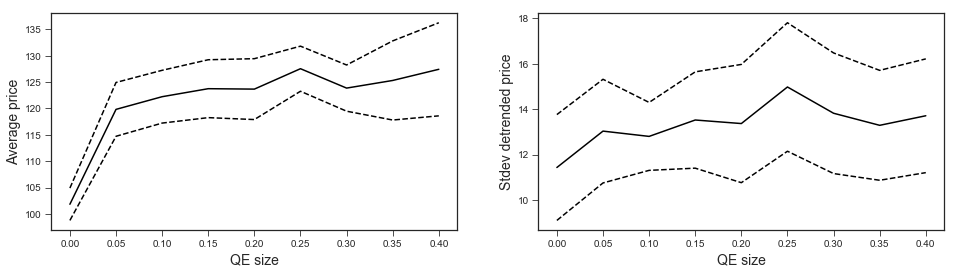

In [35]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=[16,4])

ax1.plot(qe_size, p_averages, 'k')
ax1.plot(qe_size, p_conf_uppers, 'k--')
ax1.plot(qe_size, p_conf_lowers, 'k--')

ax1.set_ylabel('Average price', fontsize='14')

ax2.plot(qe_size, av_stdev_qe_downswing, 'k')
ax2.plot(qe_size, ns_conf_uppers, 'k--')
ax2.plot(qe_size, ns_conf_lowers, 'k--')

ax2.set_ylabel('Stdev detrended price', fontsize='14')


for ax in (ax1, ax2):
    ax.set_xlabel('QE size', fontsize='14')
    

fig.savefig('QEbust.png', dpi=200, bbox_inches = 'tight', pad_inches = 0)

# Next, can QT cool down asset price upswings?

QT boom

In [44]:
s_idx = 5
scenarios[5]

'BOOMQT'

In [45]:
#qe_downswing_prices = [prices[0]]
qt_upswing_prices = []
for e in range((s_idx) * experiments, (s_idx+1) * experiments):
    #print(e)
    qt_upswing_prices.append(prices[e])

In [46]:
p_averages_qtu = []
p_conf_uppers_qtu = []
p_conf_lowers_qtu = []

av_stdev_qt_upswing = []
ns_conf_uppers_qtu = []
ns_conf_lowers_qtu = []
for idx, exp_pr in enumerate(qt_upswing_prices):
    p_averages_qtu.append(np.mean(qt_upswing_prices[idx].mean()))
    upper, lower = confidence_interval(qt_upswing_prices[idx].mean(), np.mean(qt_upswing_prices[idx].mean()))
    p_conf_uppers_qtu.append(upper)
    p_conf_lowers_qtu.append(lower)
    
    # detrend serie
    stock_cycle, stock_trend = sm.tsa.filters.hpfilter(qt_upswing_prices[idx], lamb=100000000)
    
    av_stdev_qt_upswing.append(np.mean(stock_cycle.std()))
    upper, lower = confidence_interval(stock_cycle.std(), np.mean(stock_cycle.std()))
    ns_conf_uppers_qtu.append(upper)
    ns_conf_lowers_qtu.append(lower)

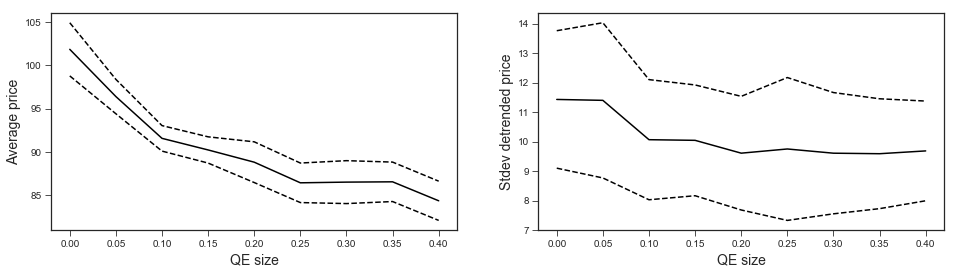

In [47]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=[16,4])

ax1.plot(qe_size, p_averages_qtu, 'k')
ax1.plot(qe_size, p_conf_uppers_qtu, 'k--')
ax1.plot(qe_size, p_conf_lowers_qtu, 'k--')

ax1.set_ylabel('Average price', fontsize='14')

ax2.plot(qe_size, av_stdev_qt_upswing, 'k')
ax2.plot(qe_size, ns_conf_uppers_qtu, 'k--')
ax2.plot(qe_size, ns_conf_lowers_qtu, 'k--')

ax2.set_ylabel('Stdev detrended price', fontsize='14')


for ax in (ax1, ax2):
    ax.set_xlabel('QE size', fontsize='14')
    

fig.savefig('QTboom.png', dpi=200, bbox_inches = 'tight', pad_inches = 0)

## Then, Can a QE-QT mix stabilize the asset price cycle?  

In [49]:
s_idx = 1
scenarios[s_idx]

'BLR'

In [50]:
#qe_downswing_prices = [prices[0]]
blr_prices = []
for e in range((s_idx) * experiments, (s_idx+1) * experiments):
    #print(e)
    blr_prices.append(prices[e])

In [51]:
p_averages_blr = []
p_conf_uppers_blr = []
p_conf_lowers_blr = []

av_stdev_blr = []
ns_conf_uppers_blr = []
ns_conf_lowers_blr = []
for idx, exp_pr in enumerate(blr_prices):
    p_averages_blr.append(np.mean(blr_prices[idx].mean()))
    upper, lower = confidence_interval(blr_prices[idx].mean(), np.mean(blr_prices[idx].mean()))
    p_conf_uppers_blr.append(upper)
    p_conf_lowers_blr.append(lower)
    
    # detrend serie
    stock_cycle, stock_trend = sm.tsa.filters.hpfilter(blr_prices[idx], lamb=100000000)
    
    av_stdev_blr.append(np.mean(stock_cycle.std()))
    upper, lower = confidence_interval(stock_cycle.std(), np.mean(stock_cycle.std()))
    ns_conf_uppers_blr.append(upper)
    ns_conf_lowers_blr.append(lower)

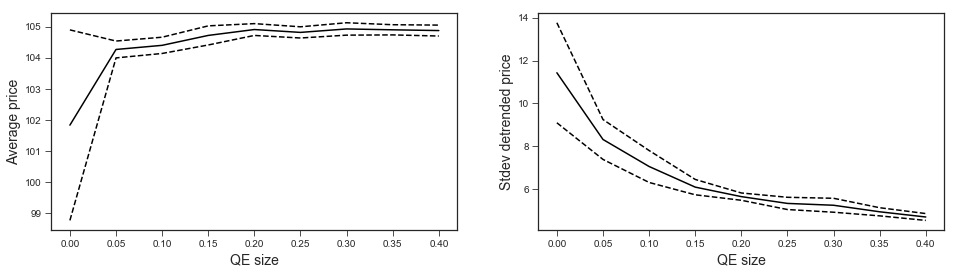

In [52]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=[16,4])

ax1.plot(qe_size, p_averages_blr, 'k')
ax1.plot(qe_size, p_conf_uppers_blr, 'k--')
ax1.plot(qe_size, p_conf_lowers_blr, 'k--')

ax1.set_ylabel('Average price', fontsize='14')

ax2.plot(qe_size, av_stdev_blr, 'k')
ax2.plot(qe_size, ns_conf_uppers_blr, 'k--')
ax2.plot(qe_size, ns_conf_lowers_blr, 'k--')

ax2.set_ylabel('Stdev detrended price', fontsize='14')


for ax in (ax1, ax2):
    ax.set_xlabel('QE size', fontsize='14')
    

fig.savefig('BLR.png', dpi=200, bbox_inches = 'tight', pad_inches = 0)

# What if the timing is wrong? 

## a QE in an upswing

In [53]:
s_idx = 4
scenarios[s_idx]

'BOOMQE'

In [54]:
#qe_downswing_prices = [prices[0]]
qe_upswing_prices = []
for e in range((s_idx) * experiments, (s_idx+1) * experiments):
    #print(e)
    qe_upswing_prices.append(prices[e])

In [55]:
p_averages_qeu = []
p_conf_uppers_qeu = []
p_conf_lowers_qeu = []

av_stdev_qe_upswing = []
ns_conf_uppers_qeu = []
ns_conf_lowers_qeu = []
for idx, exp_pr in enumerate(qe_upswing_prices):
    p_averages_qeu.append(np.mean(qe_upswing_prices[idx].mean()))
    upper, lower = confidence_interval(qe_upswing_prices[idx].mean(), np.mean(qe_upswing_prices[idx].mean()))
    p_conf_uppers_qeu.append(upper)
    p_conf_lowers_qeu.append(lower)
    
    # detrend serie
    stock_cycle, stock_trend = sm.tsa.filters.hpfilter(qe_upswing_prices[idx], lamb=100000000)
    
    av_stdev_qe_upswing.append(np.mean(stock_cycle.std()))
    upper, lower = confidence_interval(stock_cycle.std(), np.mean(stock_cycle.std()))
    ns_conf_uppers_qeu.append(upper)
    ns_conf_lowers_qeu.append(lower)

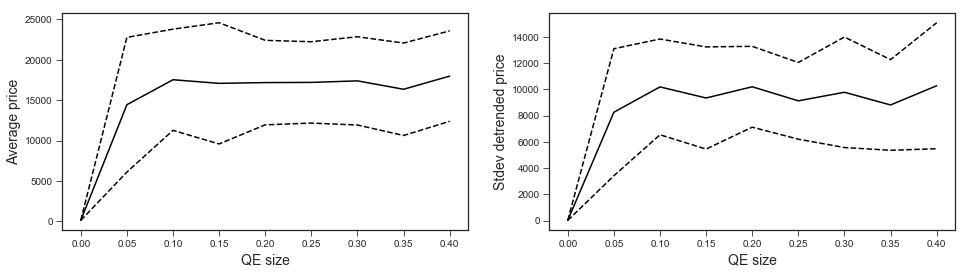

In [56]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=[16,4])

ax1.plot(qe_size, p_averages_qeu, 'k')
ax1.plot(qe_size, p_conf_uppers_qeu, 'k--')
ax1.plot(qe_size, p_conf_lowers_qeu, 'k--')

ax1.set_ylabel('Average price', fontsize='14')

ax2.plot(qe_size, av_stdev_qe_upswing, 'k')
ax2.plot(qe_size, ns_conf_uppers_qeu, 'k--')
ax2.plot(qe_size, ns_conf_lowers_qeu, 'k--')

ax2.set_ylabel('Stdev detrended price', fontsize='14')


for ax in (ax1, ax2):
    ax.set_xlabel('QE size', fontsize='14')
    

fig.savefig('QEboom.png', dpi=200, bbox_inches = 'tight', pad_inches = 0)

## b QT in a downswing

In [57]:
s_idx = 3
scenarios[s_idx]

'BUSTQT'

In [58]:
#qe_downswing_prices = [prices[0]]
qt_downswing_prices = []
for e in range((s_idx) * experiments, (s_idx+1) * experiments):
    #print(e)
    qt_downswing_prices.append(prices[e])

In [59]:
p_averages_qtd = []
p_conf_uppers_qtd = []
p_conf_lowers_qtd = []

av_stdev_qtd = []
ns_conf_uppers_qtd = []
ns_conf_lowers_qtd = []
for idx, exp_pr in enumerate(qt_downswing_prices):
    p_averages_qtd.append(np.mean(qt_downswing_prices[idx].mean()))
    upper, lower = confidence_interval(qt_downswing_prices[idx].mean(), np.mean(qt_downswing_prices[idx].mean()))
    p_conf_uppers_qtd.append(upper)
    p_conf_lowers_qtd.append(lower)
    
    # detrend serie
    stock_cycle, stock_trend = sm.tsa.filters.hpfilter(qt_downswing_prices[idx], lamb=100000000)
    
    av_stdev_qtd.append(np.mean(stock_cycle.std()))
    upper, lower = confidence_interval(stock_cycle.std(), np.mean(stock_cycle.std()))
    ns_conf_uppers_qtd.append(upper)
    ns_conf_lowers_qtd.append(lower)

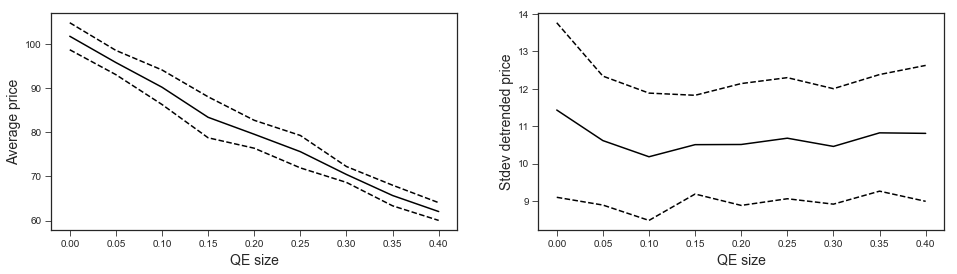

In [60]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=[16,4])

ax1.plot(qe_size, p_averages_qtd, 'k')
ax1.plot(qe_size, p_conf_uppers_qtd, 'k--')
ax1.plot(qe_size, p_conf_lowers_qtd, 'k--')

ax1.set_ylabel('Average price', fontsize='14')

ax2.plot(qe_size, av_stdev_qtd, 'k')
ax2.plot(qe_size, ns_conf_uppers_qtd, 'k--')
ax2.plot(qe_size, ns_conf_lowers_qtd, 'k--')

ax2.set_ylabel('Stdev detrended price', fontsize='14')


for ax in (ax1, ax2):
    ax.set_xlabel('QE size', fontsize='14')
    

fig.savefig('QTbust.png', dpi=200, bbox_inches = 'tight', pad_inches = 0)

## Stupid policy graph summary

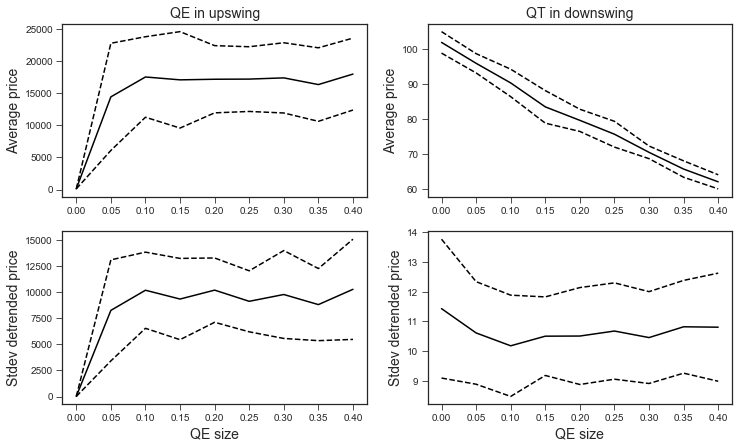

In [67]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=[12,7])

ax1.plot(qe_size, p_averages_qeu, 'k')
ax1.plot(qe_size, p_conf_uppers_qeu, 'k--')
ax1.plot(qe_size, p_conf_lowers_qeu, 'k--')

ax1.set_ylabel('Average price', fontsize='14')
ax1.set_title('QE in upswing', fontsize='14')

ax2.plot(qe_size, p_averages_qtd, 'k')
ax2.plot(qe_size, p_conf_uppers_qtd, 'k--')
ax2.plot(qe_size, p_conf_lowers_qtd, 'k--')
ax2.set_title('QT in downswing', fontsize='14')
ax2.set_ylabel('Average price', fontsize='14')

ax3.plot(qe_size, av_stdev_qe_upswing, 'k')
ax3.plot(qe_size, ns_conf_uppers_qeu, 'k--')
ax3.plot(qe_size, ns_conf_lowers_qeu, 'k--')

ax3.set_ylabel('Stdev detrended price', fontsize='14')

ax4.plot(qe_size, av_stdev_qtd, 'k')
ax4.plot(qe_size, ns_conf_uppers_qtd, 'k--')
ax4.plot(qe_size, ns_conf_lowers_qtd, 'k--')

ax4.set_ylabel('Stdev detrended price', fontsize='14')


for ax in (ax3, ax4):
    ax.set_xlabel('QE size', fontsize='14')
    

fig.savefig('QEboomQTbust.png', dpi=200, bbox_inches = 'tight', pad_inches = 0)